# Analysis of the Regulatory Market model

> Initial results for my Regulatory Markets model

In [1]:
#| default_exp analysis_reg_market

In [2]:
#| hide
#| export
from gh_pages_example.conditions import *
from gh_pages_example.data_utils import *
from gh_pages_example.methods import *
from gh_pages_example.models import *
from gh_pages_example.model_utils import *
from gh_pages_example.payoffs import *
from gh_pages_example.plot_utils import *
from gh_pages_example.types import *
from gh_pages_example.utils import *

import copy
import typing
import warnings

import chaospy
import fastcore.test
import ipywidgets
from ipywidgets import interact
import matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import *
import nptyping
import numpy as np
import pandas
import scipy
import seaborn as sns

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


In [3]:
#| hide
sns.set_theme(style='darkgrid',palette='deep' ,font='sans-serif', font_scale=1.4)
plt.rcParams["axes.grid"] = False

## Fast prototyping (before placing in main body of notebook)

### A through analysis of risk dominance thresholds for different models.

The v5 model is the model I'm most confident in. It's fairly general and I
have a fair degree of trust in the equations I've coded up.

The v6 model is a more general version of the v5 model but the equations are more
complex, so it's quite possible that I've made some errors when coding it. Moreover,
the model is too complicated for inclusion in the main paper, so at best I would
include the model's results inthe supplementary information.

#### New analysis functions

In [4]:
def compute_df_likelihoods(df, dists, result_name="data_likelihood"):
    """Compute the likelihood of each row of data in `df` given a list, `dists`
    of dictionaries containing sampling functions for a set of variables
    specified by column names.
    
    While each sampler can be fairly general, the likelihoods computed
    for different samplers are multiplied together (i.e. assumed we sampled
    those values independently).
    """
    df = copy.deepcopy(df)
    df[result_name] = np.prod([dist["sampler"](df[dist["columns"]].values)
                               for dist in dists],
                              axis=0)
    return df


In [5]:
def compute_frequencies(df):
    df = copy.deepcopy(df)
    df['AU_frequency'] = (df['HQ-AU_frequency']
                        + df['LQ-AU_frequency']
                        + df['LQ-VS_frequency'])
    df['LQ_frequency'] = (df['LQ-AS_frequency']
                        + df['LQ-AU_frequency']
                        + df['LQ-VS_frequency'])
    df['AU_frequency_uncaught'] = (df['AU_frequency']
                                * ((1- df['LQ_frequency']) * (1 - df['pfo_h'])
                                    + df['LQ_frequency'] * (1 - df['pfo_l'])))
    return df

def compute_frequencies_hq_only(df):
    df = copy.deepcopy(df)
    df['AU_frequency'] = (df['HQ-AU_frequency'])
    df['LQ_frequency'] = (df['HQ-AS_frequency'] * 0)
    df['AU_frequency_uncaught'] = (df['AU_frequency'] * (1 - df['pfo_h']))
    return df

def compute_welfare_change(df, df_baseline):
    df["game_welfare_baseline"] = df_baseline["game_welfare"].values
    df["welfare_change"] = df.game_welfare - df.game_welfare_baseline
    return df

def compute_weighted_welfare_change(group, distribution):
    interp = {k: scipy.interpolate.NearestNDInterpolator(group[["s", "pr"]],
                                                        group[k])
                    for k in ['welfare_change']}
    abscissas = distribution.sample(1000, rule="sobol")
    weights = abscissas[0, :]**0 * 1 / abscissas.shape[1]
    z = interp['welfare_change'](abscissas.T)
    result = np.dot(z, weights)
    return result

In [6]:
def welfare_baseline(df):
    df = copy.deepcopy(df)
    welfare = np.where(df['p'] < 1 / (3 * df['s']),
                       df['b'] + df['B']/df['W'] - 2 * df['c'],
                       (df['p'] * (df['b'] + df['s'] * df['B']/df['W'])
                        - (1 - df['p']) * df['externality'])
                       )
    df['game_welfare'] = welfare
    return df

In [7]:
def plot_useful_figs1(df, strategy_set):
    df = copy.deepcopy(df)
    # interp1 = scipy.interpolate.NearestNDInterpolator(df[["s", "pr"]],
    #                                                   df.AU_frequency)
    # grid = build_grid_from_axes([np.arange(1, 5, 0.1),
    #                              np.arange(0, 1, 0.01)])
    # z1 = interp1(grid)
    # interp2 = scipy.interpolate.NearestNDInterpolator(df[["s", "pr"]],
    #                                                   df.AU_frequency_uncaught)
    # z2 = interp2(grid)
    # interp0 = scipy.interpolate.NearestNDInterpolator(df[["s", "pr"]],
    #                                                   df.LQ_frequency)
    # more_frequencies = {k: scipy.interpolate.LinearNDInterpolator(df[["s", "pr"]], df[k])(grid)
    #                     for k in ['HQ-AS_frequency',
    #                               'HQ-AU_frequency',
    #                               'HQ-VS_frequency',
    #                               'LQ-AS_frequency',
    #                               'LQ-AU_frequency',
    #                               'LQ-VS_frequency']}
    # z0 = interp0(grid)
    # temp_df = pandas.DataFrame({"s": grid[:, 0],
    #                             "pr": grid[:, 1],
    #                             "AU_frequency": z1,
    #                             "LQ_frequency": z0,
    #                             "AU_frequency_uncaught": z2,
    #                             **more_frequencies
    #                             })

    df = df.sort_values(["s"])
    temp_df2 = df[df.pr == df.pr.unique()[0]].sort_values(
        ['s']).drop_duplicates(subset="s")
    interp3 = scipy.interpolate.CubicSpline(temp_df2["s"],
                                            temp_df2.threshold_society_prefers_safety)
    saxis = np.arange(1, 5, 0.1)
    z3 = interp3(saxis)
    interp4 = scipy.interpolate.CubicSpline(temp_df2["s"],
                                            temp_df2.threshold_risk_dominant_safety)
    z4 = interp4(saxis)
    interp5 = scipy.interpolate.CubicSpline(temp_df2["s"],
                                            temp_df2.threshold_as_risk_dominates_au)
    z5 = np.clip(1 - interp5(saxis), 0, 1)

    temp_df = df

    table = temp_df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='AU Frequency',
                 cmap='inferno',
                 interpolation="nearest"
                 )

    # Add threshold boundaries to convey dilemma region
    plt.plot(saxis, z3)
    plt.plot(saxis, z4)
    # plt.plot(saxis, z5)

    table = temp_df.pivot_table(index='pr', columns='s', values='LQ_frequency')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='LQ Frequency',
                 cmap='inferno',
                 )

    plot_strategy_distribution(temp_df[temp_df.s == temp_df.s.unique()[10]].sort_values(['pr']),
                               strategy_set,
                               x="pr",
                               thresholds=None,
                               )

    table = temp_df.pivot_table(
        index='pr', columns='s', values='AU_frequency_uncaught')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='AU Frequency uncaught',
                 cmap='inferno',
                 )
    return df

def plot_useful_figs1a(df):
    df = copy.deepcopy(df)
    df = df.sort_values(["s"])
    temp_df2 = df[df.pr == df.pr.unique()[0]].sort_values(
        ['s']).drop_duplicates(subset="s")
    interp3 = scipy.interpolate.CubicSpline(temp_df2["s"],
                                            temp_df2.threshold_society_prefers_safety)
    saxis = np.arange(1, 5, 0.1)
    z3 = interp3(saxis)
    interp4 = scipy.interpolate.CubicSpline(temp_df2["s"],
                                            temp_df2.threshold_risk_dominant_safety)
    z4 = interp4(saxis)
    interp5 = scipy.interpolate.CubicSpline(temp_df2["s"],
                                            temp_df2.threshold_as_risk_dominates_au)
    z5 = np.clip(1 - interp5(saxis), 0, 1)

    temp_df = df

    table = temp_df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='AU Frequency',
                 cmap='inferno',
                 interpolation="nearest"
                 )

    # Add threshold boundaries to convey dilemma region
    plt.plot(saxis, z3)
    plt.plot(saxis, z4)
    plt.plot(saxis, z5)

    table = temp_df.pivot_table(index='pr', columns='s', values='LQ_frequency')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='LQ Frequency',
                 cmap='inferno',
                 )

    return df

def plot_useful_figs2(df):

    df = copy.deepcopy(df)
    grid = build_grid_from_axes([np.arange(1, 5, 0.1),
                                 np.arange(0, 1, 0.01)])
    interp_vals = {k: scipy.interpolate.LinearNDInterpolator(df[["s", "pr"]], df[k])(grid)
                   for k in ['game_welfare_baseline',
                             'game_welfare',
                             'welfare_change']}
    temp_df = pandas.DataFrame({"s": grid[:, 0],
                                "pr": grid[:, 1],
                                **interp_vals
                                })
    temp_df = df
    table = temp_df.pivot_table(
        index='pr', columns='s', values='game_welfare_baseline')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='Game Welfare Baseline',
                 cmap='inferno',
                 zmin=df.game_welfare_baseline.min(),
                 zmax=df.game_welfare_baseline.max()
                 )

    table = temp_df.pivot_table(index='pr', columns='s', values='game_welfare')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='Game Welfare',
                 cmap='inferno',
                 zmin=df.game_welfare_baseline.min(),
                 zmax=df.game_welfare_baseline.max()
                 )

    table = temp_df.pivot_table(
        index='pr', columns='s', values='welfare_change')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='Δ Welfare',
                 cmap='seismic_r',
                 zmin=None,
                 zmax=None,
                 # This norm throws an error if the data is all 0
                 norm=mpl.colors.CenteredNorm()
                 )
    return df

def plot_useful_figs2a(df):

    df = copy.deepcopy(df)
    grid = build_grid_from_axes([np.arange(1, 5, 0.1),
                                 np.arange(0, 1, 0.01)])
    interp_vals = {k: scipy.interpolate.LinearNDInterpolator(df[["s", "pr"]], df[k])(grid)
                   for k in ['game_welfare_baseline',
                             'game_welfare',
                             'welfare_change']}
    temp_df = pandas.DataFrame({"s": grid[:, 0],
                                "pr": grid[:, 1],
                                **interp_vals
                                })
    temp_df = df

    table = temp_df.pivot_table(
        index='pr', columns='s', values='welfare_change')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='Δ Welfare',
                 cmap='seismic_r',
                 zmin=None,
                 zmax=None,
                 # This norm throws an error if the data is all 0
                 norm=mpl.colors.CenteredNorm()
                 )
    return df

def plot_useful_figs3(df):
    temp_df = df.groupby(
        ['pfo_h', 'g']).weighted_welfare_change.mean().reset_index()
    table = temp_df.pivot_table(index='pfo_h',
                                columns='g',
                                values='weighted_welfare_change')
    plot_heatmap(table,
                 xlabel='government incentive, g',
                 ylabel='detection rate (high quality), ph',
                 zlabel='Expected Δ Welfare',
                 cmap='inferno',
                 zmin=None,
                 zmax=None,
                 norm=mpl.colors.CenteredNorm()
                 )

    temp_df = temp_df[temp_df["weighted_welfare_change"] >= 0]
    if temp_df.shape[0] == 0:
        print("No positive welfare changes")
        return df
    table = temp_df.pivot_table(index='pfo_h',
                                columns='g',
                                values='weighted_welfare_change')
    plot_heatmap(table,
                 xlabel='government incentive, g',
                 ylabel='detection rate (high quality), ph',
                 zlabel='Expected Δ Welfare',
                 cmap='inferno',
                 zmin=None,
                 zmax=None,
                 #  norm=mpl.colors.CenteredNorm()
                 )
    return df

def plot_useful_figs4(df):
    plot_data = df[(df.s == 1) & (df.p == 1)]
    fig, ax = plt.subplots()
    # When the threshold * s is nearly constant, we can focus on
    # a simplification of the threshold in our diagrams.
    ax.plot(plot_data['pfo_h'],
            plot_data['s'] * plot_data['threshold_as_risk_dominates_au'],
            label="new_threshold * s")
    # ax.plot(plot_data['s'], plot_data['threshold_as_risk_dominates_au_alt'])
    ax.plot(plot_data['pfo_h'],
            1/3 * plot_data['pfo_h']**0,
            label="baseline_threshold")
    ax.plot(plot_data['pfo_h'],
            1 * plot_data['pfo_h']**0,
            label="society_prefers_safe")
    ax.legend()

    fig, ax = plt.subplots()
    for i, pfo in enumerate(df.pfo_h.unique()):
        plot_data = df[df.pfo_h == pfo]
        if i == 0:
            ax.plot(plot_data['s'],
                    1 - 1/(3 * plot_data['s']),
                    label="baseline_threshold")
            ax.plot(plot_data['s'],
                    1 - 1/(plot_data['s'])**(0.5**df.collective_risk.unique()[0]),
                    label="society_prefers_safe")
        if pfo>0:
            ax.plot(plot_data['s'],
                    np.clip(
                        1 - plot_data['threshold_as_risk_dominates_au'], 0, 1),
                    dashes=[4, 4],
                    label=f"new_threshold: pfo_h={np.round(pfo, decimals=2)}")
    plt.xlabel('Speed advantage, s')
    plt.ylabel('Risk of an AI disaster, pr')
    ax.legend(fontsize=12)

    df["deviance_from_se"] = np.abs(np.clip(1
                                            - df['threshold_as_risk_dominates_au'],
                                            0,
                                            1)
                                    - np.clip(1 - 1/(df['s']), 0, 1))

    fig, ax = plt.subplots()
    plot_data = df.groupby(["pfo_h"])["deviance_from_se"].mean().reset_index()
    ax.plot(plot_data['pfo_h'],
            plot_data["deviance_from_se"],)
    ax.set_ylim(bottom=0)
    plt.xlabel('detection rate for high quality regulators, pfo_h')
    plt.ylabel("Deviance from Social optimum")

    return df


#### Some experiments with plotting different parameter distributions

Copulas are a convenient way to capture stochastic dependencies between different variables.

We can control the strength of the dependence, but do note that Chaospy can only capture very
simple dependence structures (the kind that would see dissaproval for serious work because
of their alleged role in the 2007-8 financial crisis)

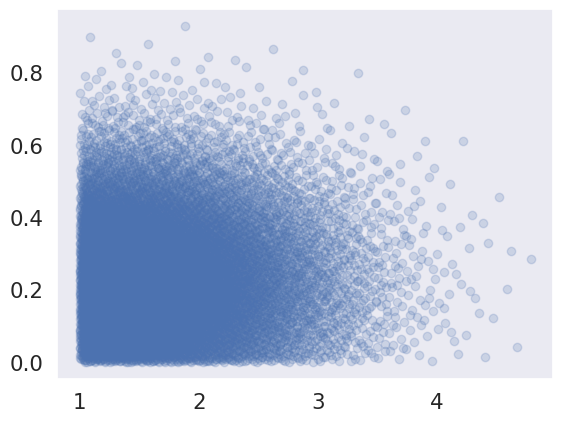

In [8]:
dist1 = chaospy.TruncNormal(lower=1, upper=5, mu=1.1, sigma=1)
dist2 = chaospy.TruncNormal(mu=0.2, sigma=0.2, lower=0, upper=1)
distx = chaospy.J(dist1, dist2)
plt.scatter(*distx.sample(10000, rule="sobol"), alpha=0.2)

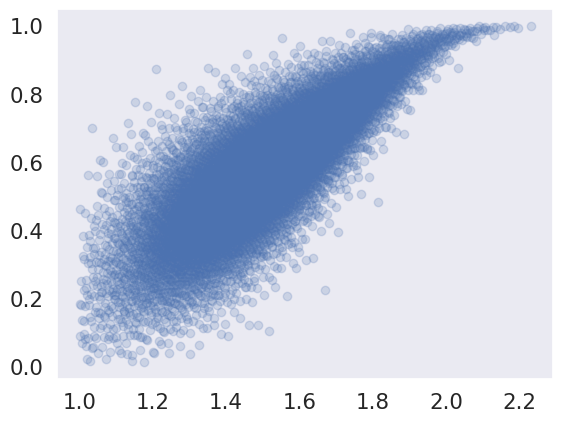

In [9]:
dist1 = chaospy.TruncNormal(mu=1.5, sigma=0.2, lower=1, upper=5)
dist2 = chaospy.TruncNormal(mu=0.5, sigma=0.2, lower=0, upper=1)
distx = chaospy.J(dist1, dist2)
distx = chaospy.Gumbel(distx, theta=2)
plt.scatter(*distx.sample(10000, rule="sobol"), alpha=0.2)

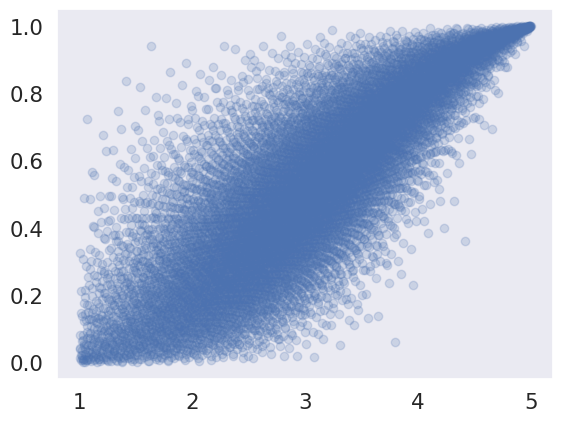

In [10]:
dist1 = chaospy.TruncNormal(mu=3, sigma=1, lower=1, upper=5)
dist2 = chaospy.TruncNormal(mu=0.2, sigma=0.5, lower=0, upper=1)
distx = chaospy.J(dist1, dist2)
distx = chaospy.Gumbel(distx, theta=2)
plt.scatter(*distx.sample(10000, rule="sobol"), alpha=0.2)

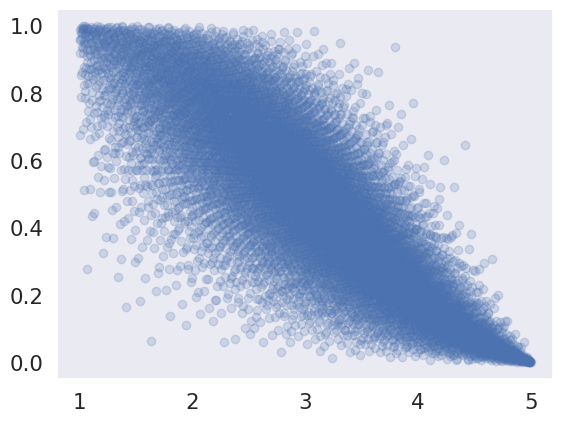

In [11]:
dist1 = chaospy.TruncNormal(mu=3, sigma=1, lower=1, upper=5)
dist2 = chaospy.TruncNormal(mu=0.2, sigma=0.5, lower=0, upper=1)
distx = chaospy.J(dist1, dist2)
distx = chaospy.Gumbel(distx, theta=2)
x, y = distx.sample(10000, rule="sobol")
plt.scatter(x, 1 - y, alpha=0.2)

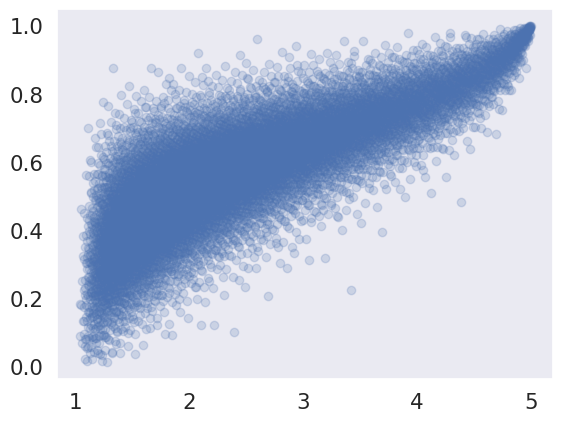

In [12]:
dist1 = chaospy.LogNormal(shift=1, mu=0.5, sigma=1)
dist1 = chaospy.Trunc(dist1, right=5)
dist2 = chaospy.TruncNormal(mu=0.5, sigma=0.2, lower=0, upper=1)
distx = chaospy.J(dist1, dist2)
distx = chaospy.Gumbel(distx, theta=2)
plt.scatter(*distx.sample(10000, rule="sobol"), alpha=0.2)

#### Model info we tend not to vary

In [8]:
Z = {"S2": 50, "S1": 50}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3], }
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"], }
models = {"dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v5_reward_mixed",
          "game_welfare_rule": "regulatory_markets_v1_reward_mixed",
          "risk_dominance_rule": "reg-market-v5-p_threshold",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }
models['pfo'] = 0 # We need this parameter to calculate some analytical boundaries.

#### Some model sanity checks

In [45]:
models_baseline = {**models,
                   **build_reg_market(pfo_h=0.8,
                                      g=1.4,
                                      incentive_mix=1,
                                      phi_h=1,
                                      phi2_h=1,
                                      β = 0.02 # np.arange(0.01, 0.1, 0.01)
                                      )
                   }
models_baseline['β'] = {"S1": models_baseline['β'],
                        "S2": models_baseline['β']*10}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models_baseline['phi_h'] = models_baseline['phi_h']  / models_baseline['s']
models_baseline['phi2_h'] = models_baseline['phi2_h'] / models_baseline['s']
results_baseline = thread_macro({**models_baseline,
                                 "sd-method": "quantecon",
                                 },
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                find_ergodic_distribution,
                                calculate_sd_helper,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

In [26]:
beta = 0.1
N = 50
payoff_standard = 1
(1 + sum(2**(-payoff_standard * beta * n) for n in range(1,N)))**-1
(1 + sum(2**(payoff_standard * beta * n) for n in range(1,N)))**-1

0.0023152729850417146

We first check whether some of the problematic transition matrices are really irreducible. If they are not (i.e. they are degenerate) we anticpate seeing artifacts in our plots. We also plot the Markov Chain diagram in case it is useful for analysing the transition matrices and then discuss what the optimal choices of beta will be.

In [42]:
P = results_baseline['transition_matrix'][5]
P, \
gth_solve(P), \
gth_solve(P) @ P

(array([[0.933, 0.   , 0.007, 0.06 , 0.   , 0.   ],
        [0.119, 0.751, 0.119, 0.   , 0.011, 0.   ],
        [0.007, 0.   , 0.993, 0.   , 0.   , 0.001],
        [0.   , 0.   , 0.   , 1.   , 0.   , 0.   ],
        [0.   , 0.004, 0.   , 0.018, 0.971, 0.007],
        [0.   , 0.   , 0.026, 0.018, 0.007, 0.949]]),
 array([0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 1., 0., 0.]))

In [41]:
P = results_baseline['transition_matrix'][25]
results_baseline['p'][25], results_baseline['s'][25], \
P, \
gth_solve(P), \
gth_solve(P) @ P

(0.5,
 1.0,
 array([[0.933, 0.   , 0.007, 0.06 , 0.   , 0.   ],
        [0.082, 0.826, 0.082, 0.   , 0.011, 0.   ],
        [0.007, 0.   , 0.993, 0.   , 0.   , 0.001],
        [0.   , 0.   , 0.   , 0.942, 0.029, 0.029],
        [0.   , 0.004, 0.   , 0.   , 0.99 , 0.007],
        [0.   , 0.   , 0.026, 0.   , 0.007, 0.967]]),
 array([0.058, 0.005, 0.519, 0.061, 0.244, 0.112]),
 array([0.058, 0.005, 0.519, 0.061, 0.244, 0.112]))

In [22]:
P = results_baseline['transition_matrix'][15]
P, \
gth_solve(P), \
gth_solve(P) @ P

(array([[9.82823211e-01, 6.83760443e-05, 6.66666667e-03, 1.04417459e-02,
         0.00000000e+00, 0.00000000e+00],
        [6.12177659e-04, 9.88333899e-01, 6.12177659e-04, 0.00000000e+00,
         1.04417459e-02, 0.00000000e+00],
        [6.66666667e-03, 6.83760443e-05, 9.82823211e-01, 0.00000000e+00,
         0.00000000e+00, 1.04417459e-02],
        [3.91890311e-03, 0.00000000e+00, 0.00000000e+00, 9.95944345e-01,
         6.83760443e-05, 6.83760443e-05],
        [0.00000000e+00, 3.91890311e-03, 0.00000000e+00, 6.12177659e-04,
         9.88802253e-01, 6.66666667e-03],
        [0.00000000e+00, 0.00000000e+00, 3.91890311e-03, 6.12177659e-04,
         6.66666667e-03, 9.88802253e-01]]),
 array([0.12212574, 0.05808698, 0.09267907, 0.36854904, 0.16917005,
        0.18938912]),
 array([0.12212574, 0.05808698, 0.09267907, 0.36854904, 0.16917005,
        0.18938912]))

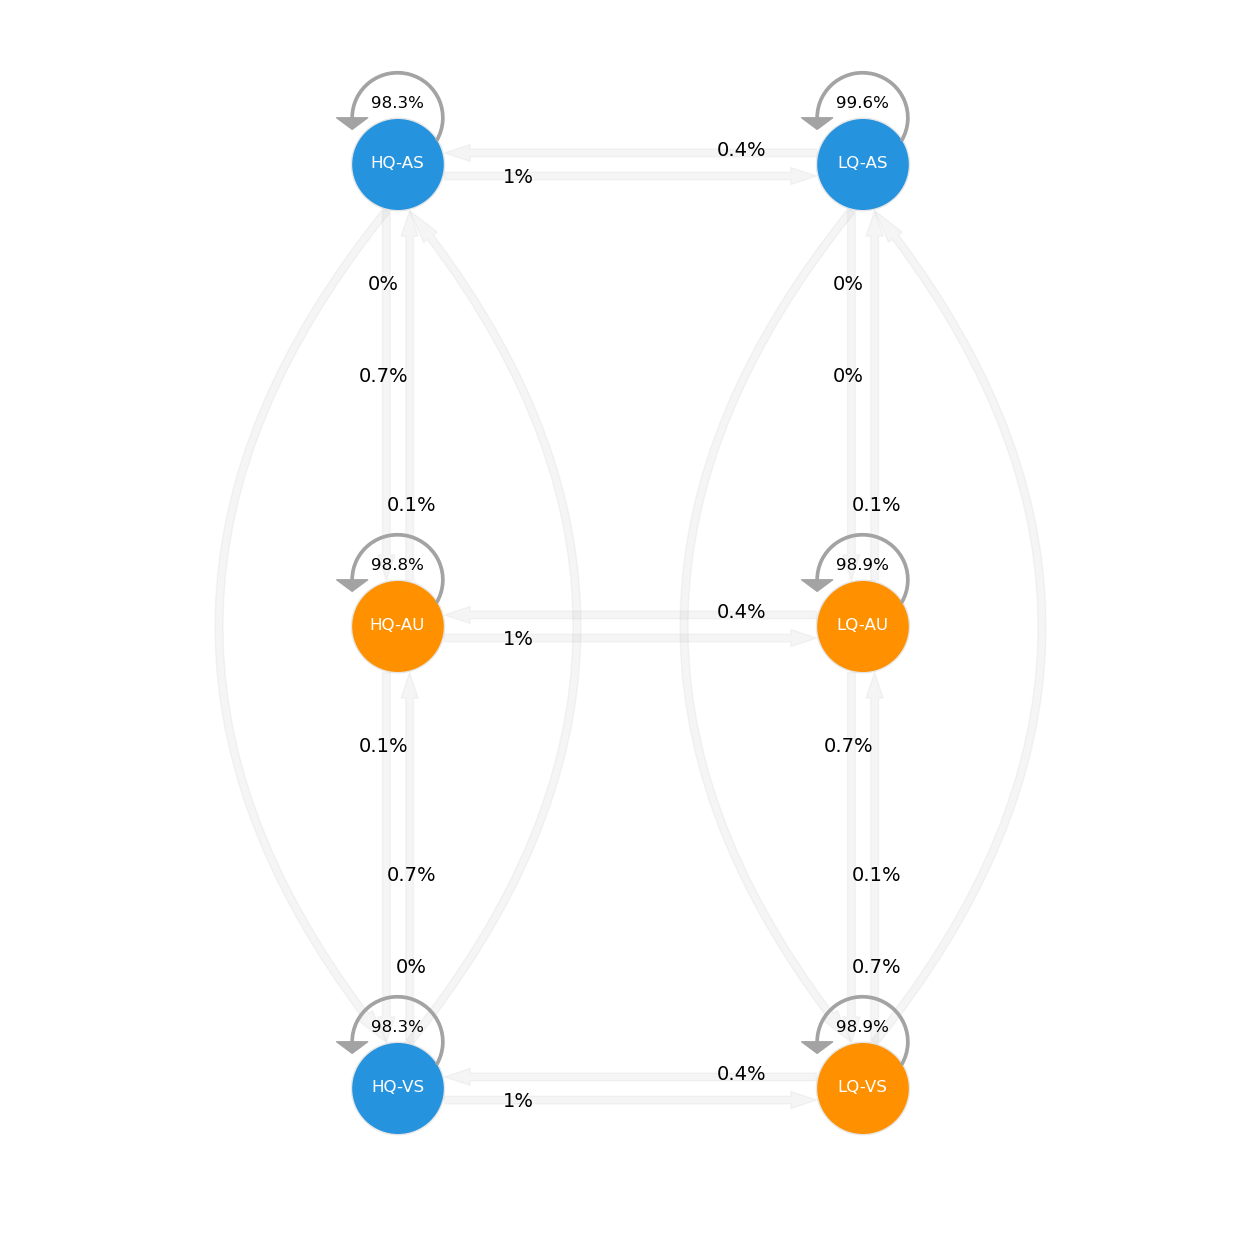

In [23]:
mc = MarkovChain(P,
                 ['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS'],
                 percentages=True,
                #  self_arrows=False,
                #  annotate=False,
                 n_columns=2,
                 node_facecolor= ["#2693de", "#ff9000", "#2693de",
                                  "#2693de", "#ff9000", "#ff9000"],
                 transparency_func=lambda p:max(p**0.5, 0.1) if p>1e-100 else 0)
mc.draw()

We should choose beta so that when faced with a large improvement in payoffs,
equivalent to doubling the speed of AI developmet for safe companies (100),
that players will adopt the strategy with > 90% probability when faced with it
(we can also consider 75%, 95%, and perhaps 99%).  

 We also want to report how likely the same players are to accept other payoff improvements given that beta

0.010986122886681096
0.021972245773362195
0.029444389791664395
0.0459511985013459


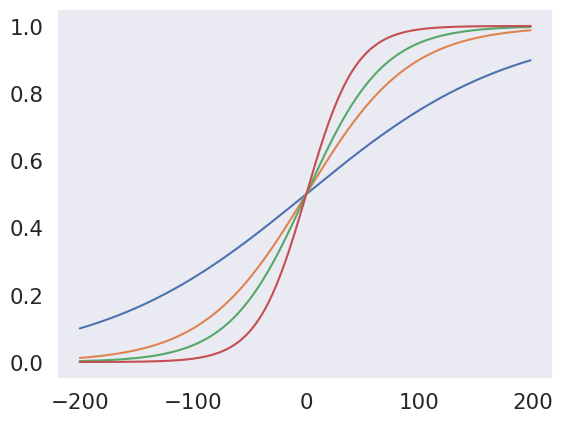

In [18]:
for x in [0.75, 0.9, 0.95, 0.99]:
    payoff_standard = 100
    # (1 + np.exp(-payoff_standard*beta))**-1 > x
    # np.exp(-*beta) < (1-x)/x
    # payoff_standard*beta > ln(x) - ln(1-x)
    target = np.log(x) - np.log(1-x)
    # target = np.log2(x) - np.log2(1-x)
    # The calibrated value of beta would then be
    beta = target / payoff_standard
    print(beta)
    x = np.arange(-200, 200, 2)
    y = (1 + np.exp(-beta*x))**-1
    plt.plot(x, y)

A quick justification for the payoff_standard above. The largest and smallest payoffs
can be as far as 500 units of payoff apart. A standard of 100 seems apprpriate in this case
as average payoffs will usually have a difference substantially smaller than this (although note that we might even be willing to raise the standard slightly higher if it were needed to avoid computational issues since we are playing it quite safe here).

In [19]:
smallest_payoffs = [np.min(v1)
                    for v in results_baseline['payoffs'].values()
                    for v1 in v.values()]
largest_payoffs = [np.max(v1)
                   for v in results_baseline['payoffs'].values()
                   for v1 in v.values()]
np.min(smallest_payoffs), np.max(largest_payoffs)

(-1.0, 503.33333333333366)

Note above that we assumed that the payoff_standard would be 100. What if we were more interested in normalising our payoffs so that a payoff standard of 1 was relevant?

The plots below suggest that for a set of reasonable calibrations of a general model, we may wish to test values for beta in {1, 2, 3, 5}

1.0986122886681096
2.1972245773362196
2.9444389791664394
4.59511985013459


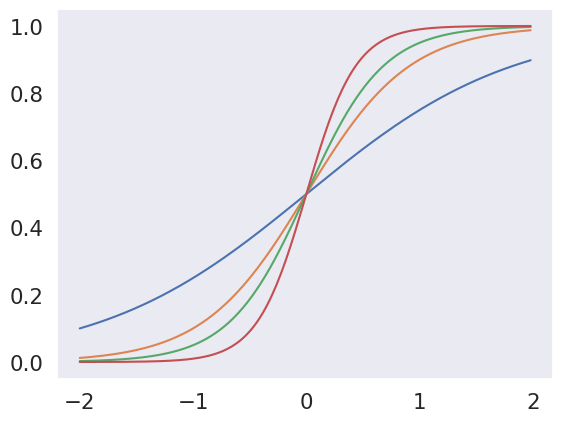

In [20]:
for x in [0.75, 0.9, 0.95, 0.99]:
    payoff_standard = 1
    # (1 + np.exp(-payoff_standard*beta))**-1 > x
    # np.exp(-*beta) < (1-x)/x
    # payoff_standard*beta > ln(x) - ln(1-x)
    target = np.log(x) - np.log(1-x)
    # target = np.log2(x) - np.log2(1-x)
    # The calibrated value of beta would then be
    beta = target / payoff_standard
    print(beta)
    x = np.arange(-2, 2, 0.02)
    y = (1 + np.exp(-beta*x))**-1
    plt.plot(x, y)

By continuity we know that the AU frequency in the middle region has to be between the top and bottom region. Rather than being a solid coloured region, this is an artifact of numerical issues in computing the stationary distribution, we anticipate that we have a flatter gradient around the risk dominance boundary, that extend further out as implied by the figures below.

Unfortunately, we know that regulators receive vastly different payoffs. Choosing a learning rate which is suitable for both is therefore impossible in the current system. This is unfortunate, since it means our model implicitly assumes regulators are far less motivated than companies to learn from their peers. However, evidence points in both ways. Regulators are very likely to learn from their peers, at least before they establish their method for doing things.

We can (optionally) standardise their payoffs and allow assymetric beta variables. Beta can depend on the sector, and we would need to check which sector is running each time in our equations. Shouldn't be too difficut to manage this.

We need to make sure that we can still handle the beta properly during model creation. Currently, we have to do it outside of the model creator

It turns out to be very difficult to ensure that both beta values are appropriate while avoiding numerical issues.

This only happens in some portions of the parameter space which are in general degenerate (i.e. other fixation rates fall to zero). 
This highlights the importance of first checking with values of beta which incur no numerical difficulties, before increasing beta further.

In [46]:
test_df = compute_frequencies(df_baseline)
test_df['β'] = test_df.get('β', 1)
@interact(β=test_df.β.unique())
def dsair_plot(β):
    temp_df = test_df[test_df.β == β]
    table = temp_df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='AU Frequency',
                 cmap='inferno',
                 interpolation="nearest"
                 )

interactive(children=(Dropdown(description='β', options=(1,), value=1), Output()), _dom_classes=('widget-inter…

In [44]:
test_df = compute_frequencies(df_baseline)
test_df['β'] = test_df.get('β', 1)
@interact(β=test_df.β.unique())
def dsair_plot(β):
    temp_df = test_df[test_df.β == β]
    table = temp_df.pivot_table(index='pr', columns='s', values='AU_frequency')
    plot_heatmap(table,
                 xlabel='Speed advantage, s',
                 ylabel='Risk of an AI disaster, pr',
                 zlabel='AU Frequency',
                 cmap='inferno',
                 interpolation="nearest"
                 )

interactive(children=(Dropdown(description='β', options=(1,), value=1), Output()), _dom_classes=('widget-inter…

β    s     p  b  c      B    W  pfo_l  pfo_h  λ  ...  \
0      0.01  1.0  0.00  4  1  10000  100      0      0  0  ...   
14683  0.08  1.0  0.92  4  1  10000  100      0      0  0  ...   
14684  0.08  1.0  0.94  4  1  10000  100      0      0  0  ...   
14685  0.08  1.0  0.96  4  1  10000  100      0      0  0  ...   
14686  0.08  1.0  0.98  4  1  10000  100      0      0  0  ...   
...     ...  ...   ... .. ..    ...  ...    ...    ... ..  ...   
4168   0.02  5.0  0.74  4  1  10000  100      0      0  0  ...   
4169   0.02  5.0  0.76  4  1  10000  100      0      0  0  ...   
4170   0.02  5.0  0.78  4  1  10000  100      0      0  0  ...   
4150   0.02  5.0  0.38  4  1  10000  100      0      0  0  ...   
18818  0.09  5.0  1.00  4  1  10000  100      0      0  0  ...   

       HQ-AS_frequency  HQ-AU_frequency  HQ-VS_frequency  LQ-AS_frequency  \
0             0.256148         0.000407         0.123338     5.874604e-01   
14683         0.000013         0.018754         0.000689     5.199272e-07   
14684         0.000013         0.018757         0.000686     5.131819e-07   
14685         0.000013         0.018759         0.000683     5.075428e-07   
14686         0.000013         0.018761         0.000681     5.028170e-07   
...                ...              ...              ...              ...   
4168          0.000060         0.269662         0.003170     9.419509e-07   
4169          0.000060         0.269663         0.003169     9.411618e-07   
4170          0.000060         0.269663         0.003168     9.405172e-07   
4150          0.000068         0.269469         0.003356     1.119596e-06   
18818         0.000008         0.011540         0.000461     3.622744e-07   

       LQ-AU_frequency  LQ-VS_frequency    pr  AU_frequency  LQ_frequency  \
0             0.004883         0.027763  1.00      0.033053      0.620106   
14683         0.507296         0.473248  0.08      0.999298      0.980545   
14684         0.507302         0.473243  0.06      0.999301      0.980545   
14685         0.507306         0.473238  0.04      0.999304      0.980545   
14686         0.507310         0.473234  0.02      0.999306      0.980545   
...                ...              ...   ...           ...           ...   
4168          0.444200         0.282908  0.26      0.996769      0.727108   
4169          0.444200         0.282907  0.24      0.996770      0.727108   
4170          0.444201         0.282907  0.22      0.996771      0.727108   
4150          0.444085         0.283022  0.62      0.996576      0.727108   
18818         0.505738         0.482253  0.00      0.999530      0.987991   

       AU_frequency_uncaught  
0                   0.033053  
14683               0.999298  
14684               0.999301  
14685               0.999304  
14686               0.999306  
...                      ...  
4168                0.996769  
4169                0.996770  
4170                0.996771  
4150                0.996576  
18818               0.999530  

[18819 rows x 36 columns]

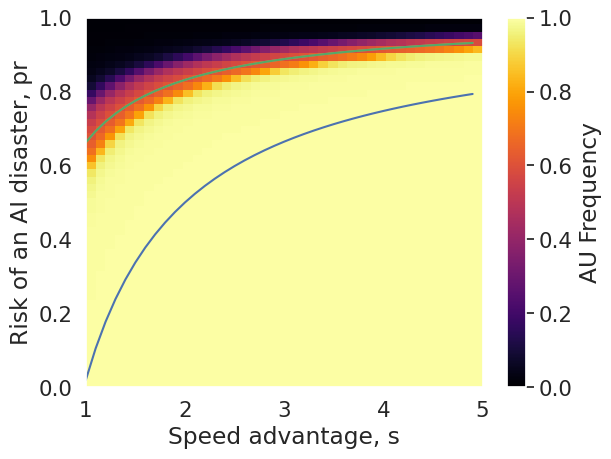

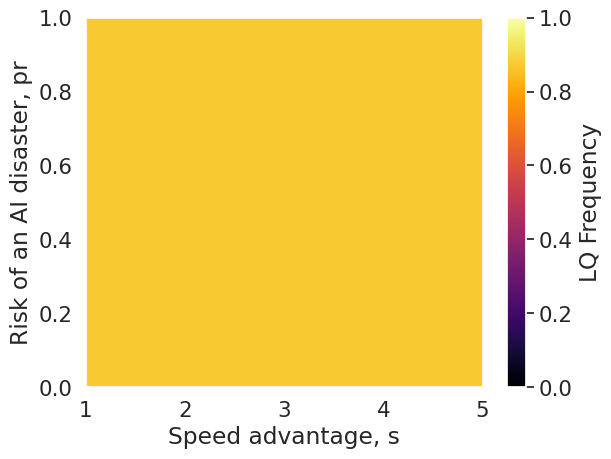

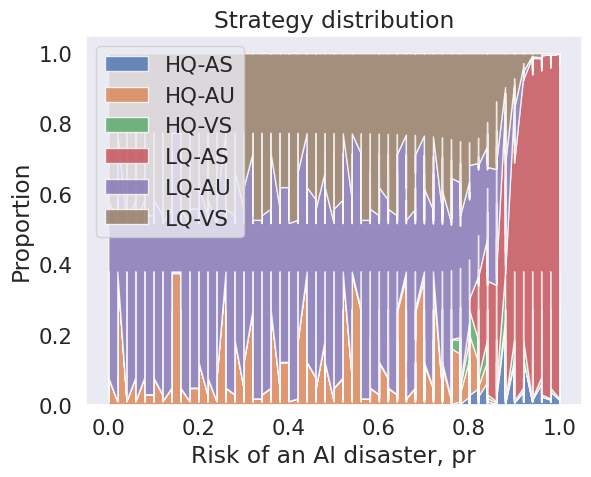

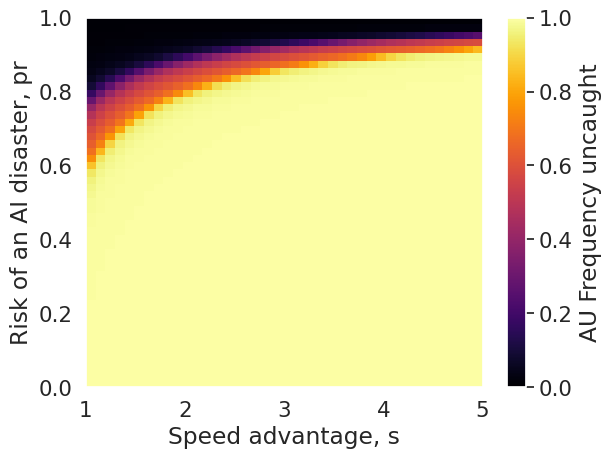

In [22]:
thread_macro(df_baseline,
             compute_frequencies,
             (plot_useful_figs1, results_baseline['strategy_set']),
             )

In [23]:
models = {**models,
          **build_reg_market(pfo_h=np.arange(0,1,0.01),
                             incentive_mix=1,
                             phi_h = 1,
                             phi2_h = 1,
                             g=1.1)
          }

In [24]:
models = {**models,
          **build_reg_market(pfo_h=np.arange(0,1,0.01),
                             incentive_mix=1,
                             phi_h = 1,
                             phi2_h = 1,
                             g=1.1)
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'β': (209100,),
 'pfo_h': (209100,),
 's': (209100,),
 'p': (209100,),
 'b': (209100,),
 'c': (209100,),
 'B': (209100,),
 'W': (209100,),
 'pfo_l': (209100,),
 'λ': (209100,),
 'r_l': (209100,),
 'r_h': (209100,),
 'g': (209100,),
 'phi_h': (209100,),
 'phi2_h': (209100,),
 'externality': (209100,),
 'decisiveness': (209100,),
 'incentive_mix': (209100,),
 'collective_risk': (209100,)}

In [25]:
results = thread_macro(models,
                       risk_dominance,
                       )
df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))


β  pfo_h    s     p  b  c      B    W  pfo_l  λ  ...  phi_h  phi2_h  \
0       1   0.00  1.0  0.00  4  1  10000  100      0  0  ...    1.0     1.0   
1       1   0.00  1.0  0.02  4  1  10000  100      0  0  ...    1.0     1.0   
2       1   0.00  1.0  0.04  4  1  10000  100      0  0  ...    1.0     1.0   
3       1   0.00  1.0  0.06  4  1  10000  100      0  0  ...    1.0     1.0   
4       1   0.00  1.0  0.08  4  1  10000  100      0  0  ...    1.0     1.0   
...    ..    ...  ...   ... .. ..    ...  ...    ... ..  ...    ...     ...   
209095  1   0.99  5.0  0.92  4  1  10000  100      0  0  ...    0.2     0.2   
209096  1   0.99  5.0  0.94  4  1  10000  100      0  0  ...    0.2     0.2   
209097  1   0.99  5.0  0.96  4  1  10000  100      0  0  ...    0.2     0.2   
209098  1   0.99  5.0  0.98  4  1  10000  100      0  0  ...    0.2     0.2   
209099  1   0.99  5.0  1.00  4  1  10000  100      0  0  ...    0.2     0.2   

        externality  decisiveness  incentive_mix  collective_risk  \
0                 0             1              1                0   
1                 0             1              1                0   
2                 0             1              1                0   
3                 0             1              1                0   
4                 0             1              1                0   
...             ...           ...            ...              ...   
209095            0             1              1                0   
209096            0             1              1                0   
209097            0             1              1                0   
209098            0             1              1                0   
209099            0             1              1                0   

        threshold_as_risk_dominates_au  threshold_as_risk_dominates_au_alt  \
0                             0.337662                            0.337662   
1                             0.337662                            0.337662   
2                             0.337662                            0.337662   
3                             0.337662                            0.337662   
4                             0.337662                            0.337662   
...                                ...                                 ...   
209095                        2.735251                            2.735251   
209096                        2.735251                            2.735251   
209097                        2.735251                            2.735251   
209098                        2.735251                            2.735251   
209099                        2.735251                            2.735251   

          pr  deviance_from_se  
0       1.00          0.662338  
1       0.98          0.662338  
2       0.96          0.662338  
3       0.94          0.662338  
4       0.92          0.662338  
...      ...               ...  
209095  0.08          0.800000  
209096  0.06          0.800000  
209097  0.04          0.800000  
209098  0.02          0.800000  
209099  0.00          0.800000  

[209100 rows x 23 columns]

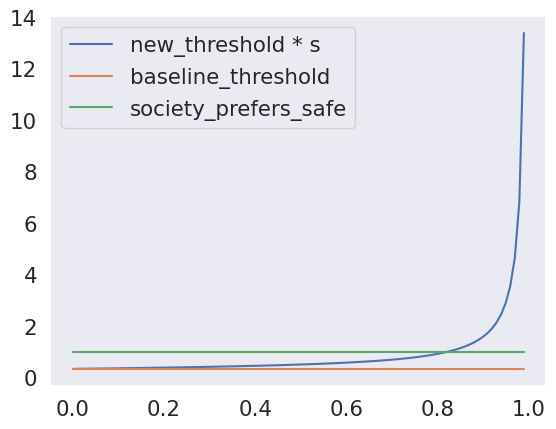

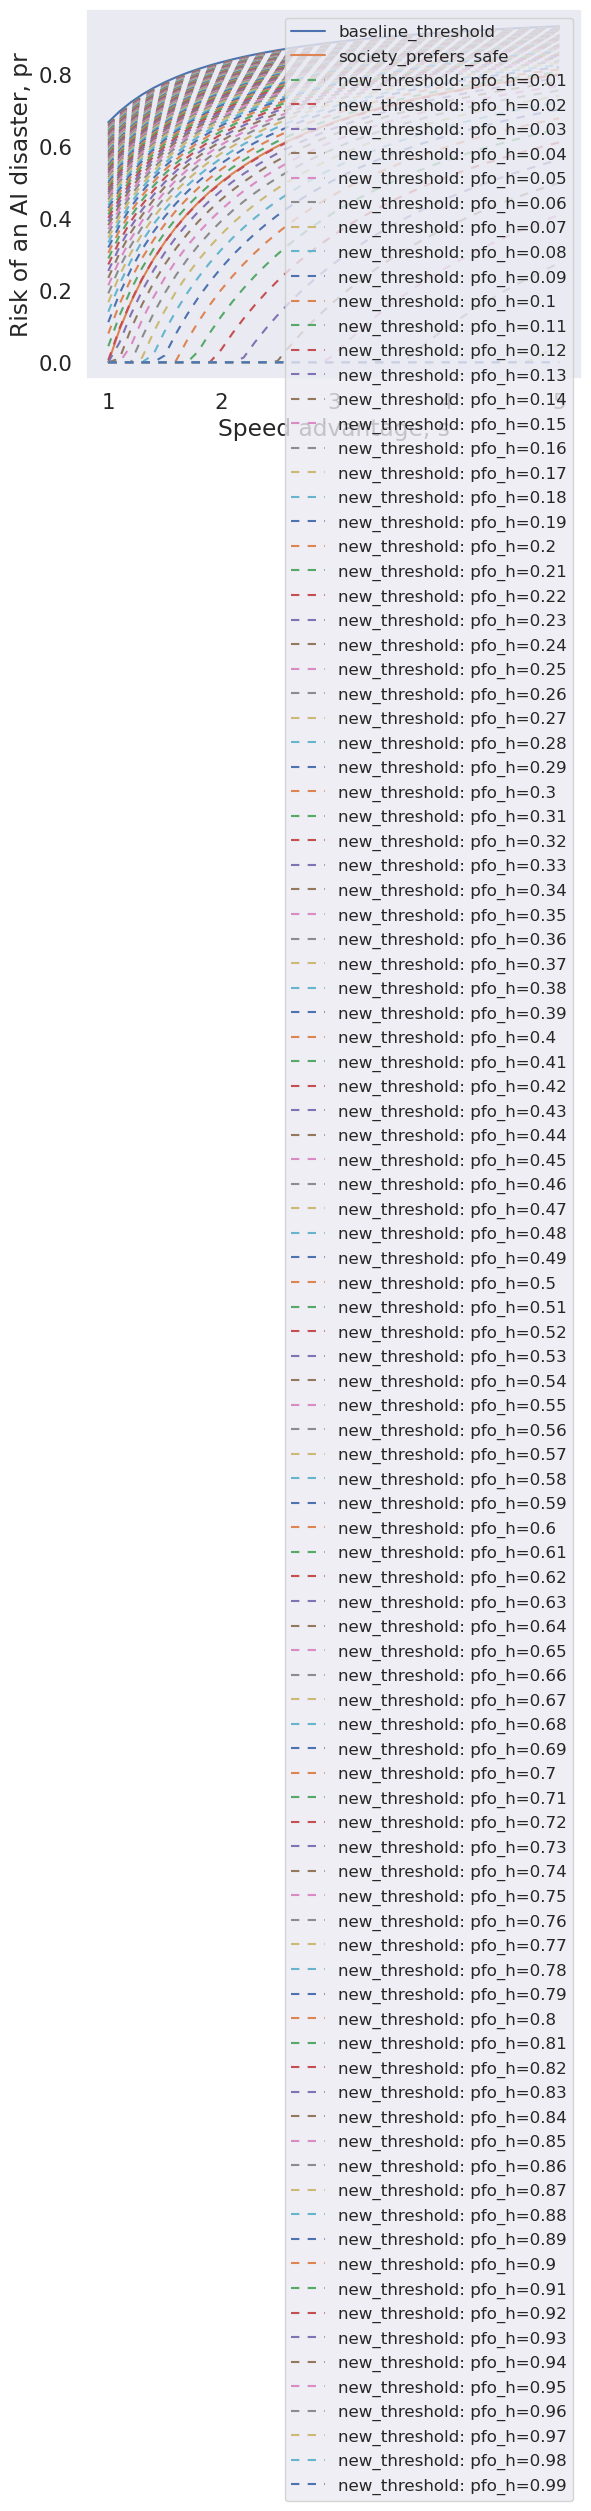

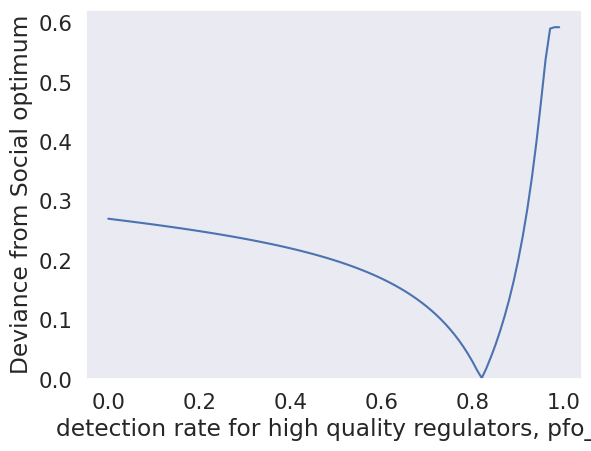

In [26]:
plot_useful_figs4(df)

#### Our main set of models

In [11]:
models = {**models,
          **build_reg_market(pfo_h=np.arange(0,1,0.05),
                             g=np.arange(1,3,0.2),
                             incentive_mix=1,
                             s=np.arange(1,5,0.2),
                             p=np.arange(0,1.1,0.05),
                             phi_h = np.array([0, 0.2, 1]),
                             phi2_h = np.array([0, 0.2, 1]),
                             collective_risk=np.array([0, 1]),
                             β=1/50,
                             )
          }
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s': (1584000,),
 'p': (1584000,),
 'pfo_h': (1584000,),
 'g': (1584000,),
 'phi_h': (1584000,),
 'phi2_h': (1584000,),
 'collective_risk': (1584000,),
 'b': (1584000,),
 'c': (1584000,),
 'B': (1584000,),
 'W': (1584000,),
 'pfo_l': (1584000,),
 'λ': (1584000,),
 'r_l': (1584000,),
 'r_h': (1584000,),
 'externality': (1584000,),
 'decisiveness': (1584000,),
 'incentive_mix': (1584000,)}

In [58]:
results = thread_macro(models,
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare
                       )

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:67: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:70: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:38: 

In [59]:
df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)

In [60]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro(models_baseline,
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                find_ergodic_distribution,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:67: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:70: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:38: 

Debug results - check that extra arrays of different shapes haven't been added accidentally.

In [61]:
{k: results[k].shape for k,v in results.items() if isinstance(v, np.ndarray)}

{'s': (1584000,),
 'p': (1584000,),
 'pfo_h': (1584000,),
 'g': (1584000,),
 'phi_h': (1584000,),
 'phi2_h': (1584000,),
 'collective_risk': (1584000,),
 'b': (1584000,),
 'c': (1584000,),
 'B': (1584000,),
 'W': (1584000,),
 'pfo_l': (1584000,),
 'λ': (1584000,),
 'r_l': (1584000,),
 'r_h': (1584000,),
 'externality': (1584000,),
 'decisiveness': (1584000,),
 'incentive_mix': (1584000,),
 'threshold_as_risk_dominates_au': (1584000,),
 'threshold_as_risk_dominates_au_alt': (1584000,),
 'payoffs_sr': (1584000, 2, 2),
 'threshold_risk_dominant_safety': (1584000,),
 'threshold_risk_dominant_safety_alt': (1584000,),
 'threshold_society_prefers_safety': (1584000,),
 'threshold_society_prefers_safety_alt': (1584000,),
 'transition_matrix': (1584000, 6, 6),
 'ergodic': (1584000, 6),
 'game_welfare': (1584000,)}

### Welfare comparisons

We now have data which we can use to complete most of our other plots

In [62]:
df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)

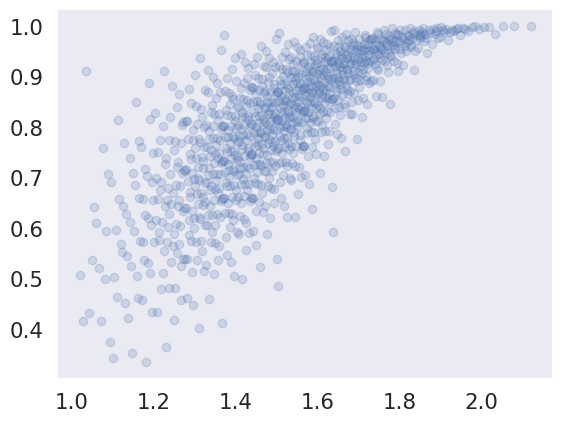

In [63]:
dist1 = chaospy.TruncNormal(mu=1.5, sigma=0.2, lower=1, upper=5)
dist2 = chaospy.TruncNormal(mu=0.8, sigma=0.2, lower=0, upper=1)
distx = chaospy.J(dist1, dist2)
distx = chaospy.Gumbel(distx, theta=2)
distribution=distx
abscissas = distribution.sample(1000, rule="sobol")
weights = abscissas[0, :]**0 * 1 / abscissas.shape[1]
plt.scatter(*abscissas, alpha=0.2)

In [64]:
@interact
def plot_interactive1(g = df.g.unique(),
                      pfo_h = df.pfo_h.unique(),
                      phi_h = df.phi_h.unique(),
                      phi2_h = df.phi2_h.unique()):
    plot_data = df[(df.g==g) 
                   & (df.pfo_h==pfo_h)
                   & (df.phi_h == phi_h)
                   & (df.phi2_h == phi2_h)]
    plot_useful_figs1(plot_data,
                      results['strategy_set'])
    plot_useful_figs2(plot_data)
    print({"new_welfare": plot_data["game_welfare"].mean(),
           "old_welfare": df_baseline["game_welfare"].mean()})
    return df

interactive(children=(Dropdown(description='g', options=(1.0, 1.2, 1.4, 1.5999999999999999, 1.7999999999999998…

Remember to multiply by s and round before grouping.

In [65]:
df['phi_h_s'] = np.round(df.phi_h * df.s, decimals=2)
df['phi2_h_s'] = np.round(df.phi2_h * df.s, decimals=2)

In [66]:
@interact
def plot_interactive1(g = df.g.unique(),
                      pfo_h = df.pfo_h.unique(),
                      phi_h_s = df.phi_h_s.unique(),
                      phi2_h_s = df.phi2_h_s.unique(),
                      collective_risk=df.collective_risk.unique()):
    plot_data = df[(df.g==g)
                   & (df.pfo_h==pfo_h)
                   & (df.phi_h_s == phi_h_s)
                   & (df.phi2_h_s == phi2_h_s)
                   & (df.collective_risk==collective_risk)]
    plot_useful_figs1(plot_data,
                      results['strategy_set'])
    plot_useful_figs2(plot_data)
    print({"new_welfare": plot_data["game_welfare"].mean(),
           "old_welfare": df_baseline[(df.collective_risk==collective_risk)
                                      ]["game_welfare"].mean()})
    return df

interactive(children=(Dropdown(description='g', options=(1.0, 1.2, 1.4, 1.5999999999999999, 1.7999999999999998…

In [67]:
group_vars = ['pfo_h', 'g', 'phi_h', 'phi2_h', 'collective_risk']
group_vars = ['pfo_h', 'g', 'phi_h_s', 'phi2_h_s', 'collective_risk']
result = []
for index, group in list(df.groupby(group_vars)):
    result.append(compute_weighted_welfare_change(group, distribution))

In [68]:
grouped_df = df.groupby(group_vars)['welfare_change'].mean().reset_index()
grouped_df["weighted_welfare_change"] = result

In [ ]:
grouped_df["weighted_welfare_change"]

0        0.670601
1        2.903439
2        0.670601
3        2.903439
4        0.670601
          ...    
3595    12.309330
3596     5.563514
3597    12.309330
3598     5.563514
3599    12.309330
Name: weighted_welfare_change, Length: 3600, dtype: float64

In [ ]:
# @interact
# def plot_interactive2(phi_h=df.phi_h.unique(),
#                       phi2_h=df.phi2_h.unique(),
#                       ):
#     plot_data = df[(df.phi_h==phi_h)
#                    & (df.phi2_h==phi2_h)]
    
#     plot_data['weighted_welfare_change'] = plot_data.welfare_change
#     plot_useful_figs3(plot_data)
    
#     plot_data = grouped_df[(grouped_df.phi_h==phi_h)
#                    & (grouped_df.phi2_h==phi2_h)]
    
#     plot_useful_figs3(plot_data)
#     return df

In [ ]:
np.round(results['transition_matrix'][100], decimals=4)

array([[0.7826, 0.    , 0.0067, 0.2107, 0.    , 0.    ],
       [0.2349, 0.3195, 0.2349, 0.    , 0.2107, 0.    ],
       [0.0067, 0.    , 0.9933, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 1.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.2349, 0.7584, 0.0067],
       [0.    , 0.    , 0.2107, 0.2349, 0.0067, 0.5477]])

In [ ]:
results['strategy_set']

['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS']

In [69]:
@interact
def plot_interactive2(phi_h_s=df.phi_h_s.unique(),
                      phi2_h_s=df.phi2_h_s.unique(),
                      collective_risk=df.collective_risk.unique(),
                      ):
    plot_data = df[(df.phi_h_s==phi_h_s)
                   & (df.phi2_h_s==phi2_h_s)
                   & (df.collective_risk==collective_risk)]
    
    plot_data['weighted_welfare_change'] = plot_data.welfare_change
    plot_useful_figs3(plot_data)
    
    plot_data = grouped_df[(grouped_df.phi_h_s==phi_h_s)
                           & (grouped_df.phi2_h_s==phi2_h_s)
                           & (grouped_df.collective_risk==collective_risk)]
    
    plot_useful_figs3(plot_data)
    return df

interactive(children=(Dropdown(description='phi_h_s', options=(0.0, 0.2, 1.0), value=0.0), Dropdown(descriptio…

We can run these results for multiple different externality values.

In [70]:
@interact
def plot_interactive3(scalar=[20, 10, 5, 2, 1],
                      results=ipywidgets.fixed(results),
                      results_baseline=ipywidgets.fixed(results_baseline),
                      ):
    results['externality'] = results['s'] * results['B'] / (results['W'] * scalar)
    results = compute_game_welfare(results)
    df["externality"] = results["externality"]
    df["game_welfare"] = results["game_welfare"]
    
    results_baseline['externality'] = results_baseline['s'] * results_baseline['B'] / (results_baseline['W'] * scalar)
    results_baseline = compute_game_welfare(results_baseline)
    df_baseline["externality"] = results_baseline["externality"]
    df_baseline["game_welfare"] = results_baseline["game_welfare"]
    
    df['welfare_change'] = df.game_welfare - df_baseline.game_welfare
    # OR
    # df_baseline = welfare_baseline(df_baseline)
    
    df['weighted_welfare_change'] = df.welfare_change
    plot_useful_figs3(df)
    return df

interactive(children=(Dropdown(description='scalar', options=(20, 10, 5, 2, 1), value=20), Output()), _dom_cla…

### Paper-ready figures

It is time to choose a set of plots above to render in more detail for inclusion in the paper

#### Set 1

A record of the values for the saved images for this set

<!-- models = {**models,
          **build_reg_market(pfo_h=np.arange(0,1,0.01),
                             g=np.arange(1,3,0.05),
                             incentive_mix=1,
                             s=np.arange(1,5,0.2),
                             p=np.arange(0,1.1,0.05),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

models = {**models,
          **build_reg_market(pfo_h=np.arange(0,1,0.01),
                             g=np.arange(1,3,0.05),
                             incentive_mix=1,
                             s=np.arange(1,5,0.2),
                             p=np.arange(0,1.1,0.05),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

models = {**models,
          **build_reg_market(pfo_h=np.arange(0,1,0.01),
                             g=np.arange(1,3,0.05),
                             incentive_mix=1,
                             s=np.arange(1,5,0.2),
                             p=np.arange(0,1.1,0.05),
                             phi_h = np.array([0]),
                             phi2_h = np.array([0]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

models = {**models,
          **build_reg_market(pfo_h=np.arange(0,1,0.01),
                             g=np.arange(1,3,0.05),
                             incentive_mix=1,
                             s=np.arange(1,5,0.2),
                             p=np.arange(0,1.1,0.05),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             β=1/50,
                             )
          }
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

 -->

In [19]:
models = {**models,
          **build_reg_market(pfo_h=np.arange(0,1,0.01),
                             g=np.arange(1,3,0.05),
                             incentive_mix=1,
                             s=np.arange(1,5,0.2),
                             p=np.arange(0,1.1,0.05),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             β=1/50,
                             )
          }
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s': (1760000,),
 'p': (1760000,),
 'phi_h': (1760000,),
 'phi2_h': (1760000,),
 'collective_risk': (1760000,),
 'b': (1760000,),
 'c': (1760000,),
 'B': (1760000,),
 'W': (1760000,),
 'pfo_l': (1760000,),
 'pfo_h': (1760000,),
 'λ': (1760000,),
 'r_l': (1760000,),
 'r_h': (1760000,),
 'g': (1760000,),
 'externality': (1760000,),
 'decisiveness': (1760000,),
 'incentive_mix': (1760000,)}

In [20]:
results = thread_macro({**models, "sd-method": "quantecon"},
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       calculate_sd_helper,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)


/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

s     p     phi_h    phi2_h  collective_risk  b  c      B    W  \
0        1.0  0.00  0.500000  0.500000              0.0  4  1  10000  100   
1        1.0  0.00  0.500000  0.500000              0.0  4  1  10000  100   
2        1.0  0.00  0.500000  0.500000              0.0  4  1  10000  100   
3        1.0  0.00  0.500000  0.500000              0.0  4  1  10000  100   
4        1.0  0.00  0.500000  0.500000              0.0  4  1  10000  100   
...      ...   ...       ...       ...              ... .. ..    ...  ...   
1759995  4.8  1.05  0.104167  0.104167              0.0  4  1  10000  100   
1759996  4.8  1.05  0.104167  0.104167              0.0  4  1  10000  100   
1759997  4.8  1.05  0.104167  0.104167              0.0  4  1  10000  100   
1759998  4.8  1.05  0.104167  0.104167              0.0  4  1  10000  100   
1759999  4.8  1.05  0.104167  0.104167              0.0  4  1  10000  100   

         pfo_l  ...  LQ-AS_frequency  LQ-AU_frequency  LQ-VS_frequency    pr  \
0            0  ...         1.000000     1.401894e-11     1.317050e-11  1.00   
1            0  ...         1.000000     1.328796e-11     8.292806e-12  1.00   
2            0  ...         1.000000     1.293405e-11     5.931186e-12  1.00   
3            0  ...         1.000000     1.275612e-11     4.743912e-12  1.00   
4            0  ...         1.000000     1.264720e-11     4.017082e-12  1.00   
...        ...  ...              ...              ...              ...   ...   
1759995      0  ...         0.011957     1.237158e-02     1.232879e-02 -0.05   
1759996      0  ...         0.011958     1.233248e-02     1.229325e-02 -0.05   
1759997      0  ...         0.011959     1.229725e-02     1.226128e-02 -0.05   
1759998      0  ...         0.011959     1.226547e-02     1.223249e-02 -0.05   
1759999      0  ...         0.011960     1.223681e-02     1.220655e-02 -0.05   

         AU_frequency  LQ_frequency  AU_frequency_uncaught  \
0        2.718943e-11      1.000000           2.718943e-11   
1        2.158077e-11      1.000000           2.158077e-11   
2        1.886523e-11      1.000000           1.886523e-11   
3        1.750003e-11      1.000000           1.750003e-11   
4        1.666428e-11      1.000000           1.666428e-11   
...               ...           ...                    ...   
1759995  3.604132e-02      0.036657           1.668378e-03   
1759996  3.596764e-02      0.036584           1.662343e-03   
1759997  3.590129e-02      0.036517           1.656918e-03   
1759998  3.584150e-02      0.036457           1.652036e-03   
1759999  3.578760e-02      0.036403           1.647642e-03   

         game_welfare_baseline  welfare_change  weighted_welfare_change  
0                        102.0       -1.000000                -1.000000  
1                        102.0       -1.050000                -1.050000  
2                        102.0       -1.100000                -1.100000  
3                        102.0       -1.150000                -1.150000  
4                        102.0       -1.200000                -1.200000  
...                        ...             ...                      ...  
1759995                  508.2     -399.303916              -399.303916  
1759996                  508.2     -399.382678              -399.382678  
1759997                  508.2     -399.458408              -399.458408  
1759998                  508.2     -399.531420              -399.531420  
1759999                  508.2     -399.601995              -399.601995  

[1760000 rows x 38 columns]

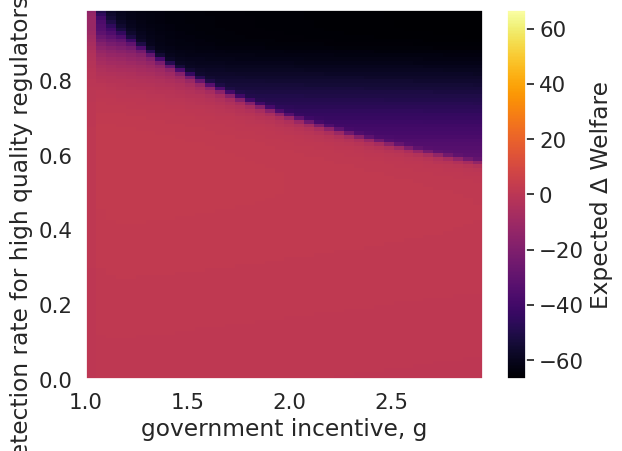

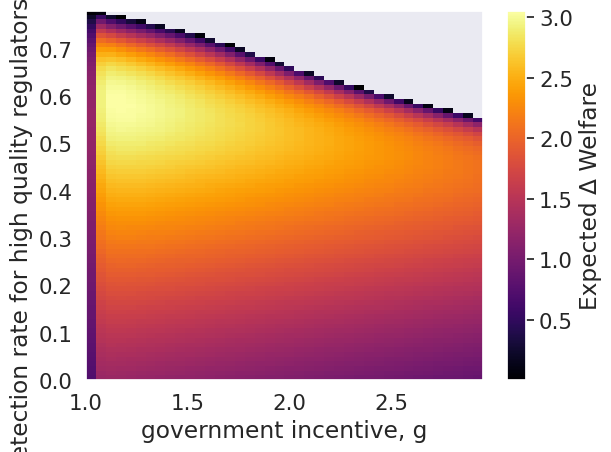

In [21]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro({**models_baseline, "sd-method": "quantecon"},
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                calculate_sd_helper,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)
plot_data = df
plot_data['weighted_welfare_change'] = plot_data.welfare_change
# plot_useful_figs1(plot_data,
#                     results['strategy_set'])
# plot_useful_figs2(plot_data)
# print({"new_welfare": plot_data["game_welfare"].mean(),
#         "old_welfare": df_baseline["game_welfare"].mean()})
plot_useful_figs3(plot_data)

s     p     phi_h    phi2_h  collective_risk  b  c      B    W  \
0        1.0  0.00  0.500000  0.500000              0.0  4  1  10000  100   
1        1.0  0.00  0.500000  0.500000              0.0  4  1  10000  100   
2        1.0  0.00  0.500000  0.500000              0.0  4  1  10000  100   
3        1.0  0.00  0.500000  0.500000              0.0  4  1  10000  100   
4        1.0  0.00  0.500000  0.500000              0.0  4  1  10000  100   
...      ...   ...       ...       ...              ... .. ..    ...  ...   
1759995  4.8  1.05  0.104167  0.104167              0.0  4  1  10000  100   
1759996  4.8  1.05  0.104167  0.104167              0.0  4  1  10000  100   
1759997  4.8  1.05  0.104167  0.104167              0.0  4  1  10000  100   
1759998  4.8  1.05  0.104167  0.104167              0.0  4  1  10000  100   
1759999  4.8  1.05  0.104167  0.104167              0.0  4  1  10000  100   

         pfo_l  ...  LQ-AS_frequency  LQ-AU_frequency  LQ-VS_frequency    pr  \
0            0  ...         1.000000     1.401894e-11     1.317050e-11  1.00   
1            0  ...         1.000000     1.328796e-11     8.292806e-12  1.00   
2            0  ...         1.000000     1.293405e-11     5.931186e-12  1.00   
3            0  ...         1.000000     1.275612e-11     4.743912e-12  1.00   
4            0  ...         1.000000     1.264720e-11     4.017082e-12  1.00   
...        ...  ...              ...              ...              ...   ...   
1759995      0  ...         0.011957     1.237158e-02     1.232879e-02 -0.05   
1759996      0  ...         0.011958     1.233248e-02     1.229325e-02 -0.05   
1759997      0  ...         0.011959     1.229725e-02     1.226128e-02 -0.05   
1759998      0  ...         0.011959     1.226547e-02     1.223249e-02 -0.05   
1759999      0  ...         0.011960     1.223681e-02     1.220655e-02 -0.05   

         AU_frequency  LQ_frequency  AU_frequency_uncaught  \
0        2.718943e-11      1.000000           2.718943e-11   
1        2.158077e-11      1.000000           2.158077e-11   
2        1.886523e-11      1.000000           1.886523e-11   
3        1.750003e-11      1.000000           1.750003e-11   
4        1.666428e-11      1.000000           1.666428e-11   
...               ...           ...                    ...   
1759995  3.604132e-02      0.036657           1.668378e-03   
1759996  3.596764e-02      0.036584           1.662343e-03   
1759997  3.590129e-02      0.036517           1.656918e-03   
1759998  3.584150e-02      0.036457           1.652036e-03   
1759999  3.578760e-02      0.036403           1.647642e-03   

         game_welfare_baseline  welfare_change  weighted_welfare_change  
0                        102.0       -1.000000                -1.000000  
1                        102.0       -1.050000                -1.050000  
2                        102.0       -1.100000                -1.100000  
3                        102.0       -1.150000                -1.150000  
4                        102.0       -1.200000                -1.200000  
...                        ...             ...                      ...  
1759995                  508.2     -399.303916              -399.303916  
1759996                  508.2     -399.382678              -399.382678  
1759997                  508.2     -399.458408              -399.458408  
1759998                  508.2     -399.531420              -399.531420  
1759999                  508.2     -399.601995              -399.601995  

[1760000 rows x 38 columns]

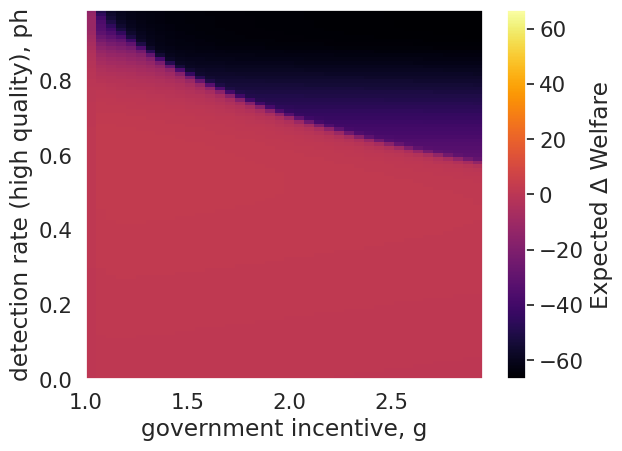

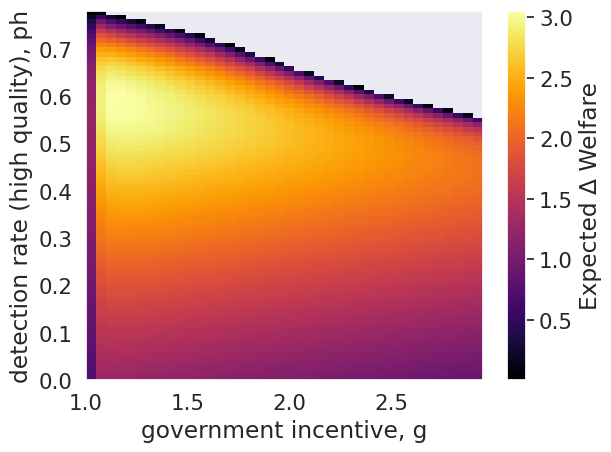

In [28]:
plot_useful_figs3(plot_data)

#### Set 2

A record of the values chosen for the second set of images

<!-- models = {**models,
          **build_reg_market(pfo_h=0.6,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}


models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             β =1/50,
                             )
          }
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

models = {**models,
          **build_reg_market(pfo_h=0.6,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             β =1/50,
                             )
          }
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

 -->

In [16]:
models = {**models,
          **build_reg_market(pfo_h=0.6,
                             g=1.2,
                             incentive_mix=0,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             β =1/50,
                             )
          }
models['Z'] = {"S1": 50, "S2": 50}
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s': (8181,),
 'p': (8181,),
 'phi_h': (8181,),
 'phi2_h': (8181,),
 'collective_risk': (8181,),
 'b': (8181,),
 'c': (8181,),
 'B': (8181,),
 'W': (8181,),
 'pfo_l': (8181,),
 'pfo_h': (8181,),
 'λ': (8181,),
 'r_l': (8181,),
 'r_h': (8181,),
 'g': (8181,),
 'externality': (8181,),
 'decisiveness': (8181,),
 'incentive_mix': (8181,)}

In [17]:
results = thread_macro({**models, "sd-method": "quantecon"},
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       calculate_sd_helper,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)


/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

{'new_welfare': 163.44309122361804, 'old_welfare': 163.44309122359383}


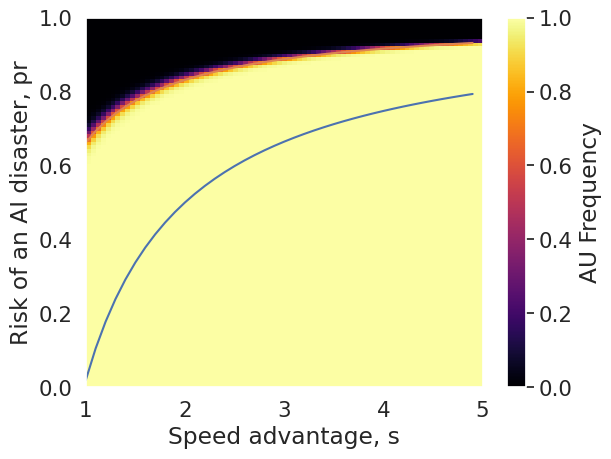

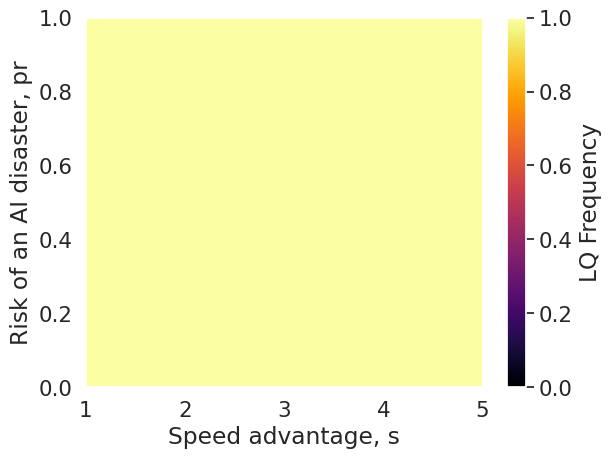

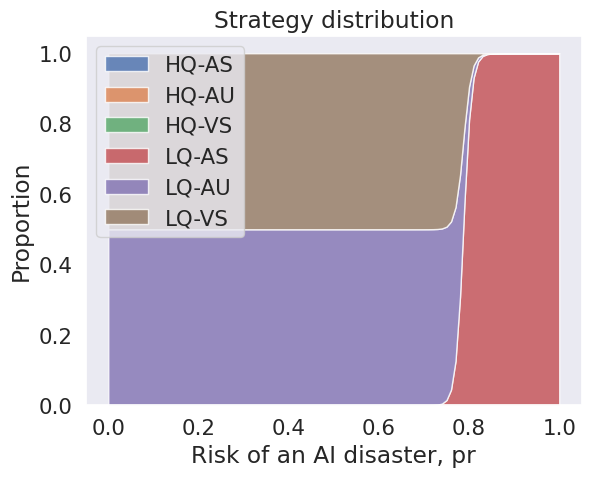

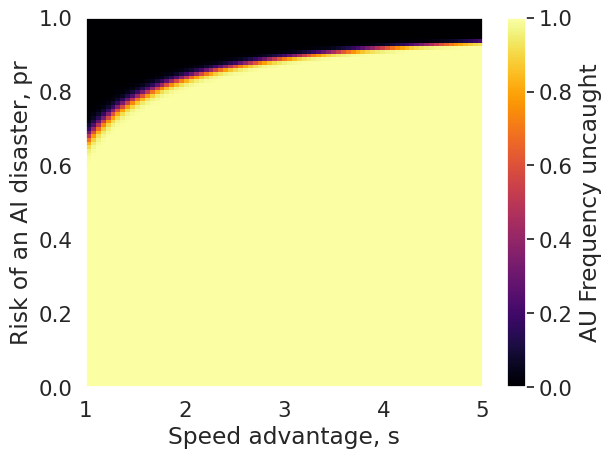

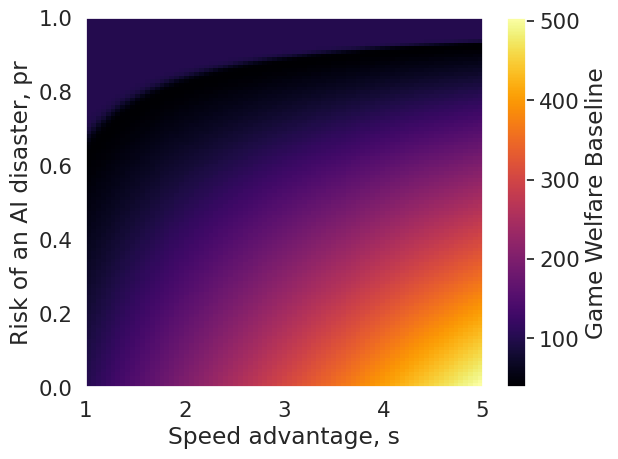

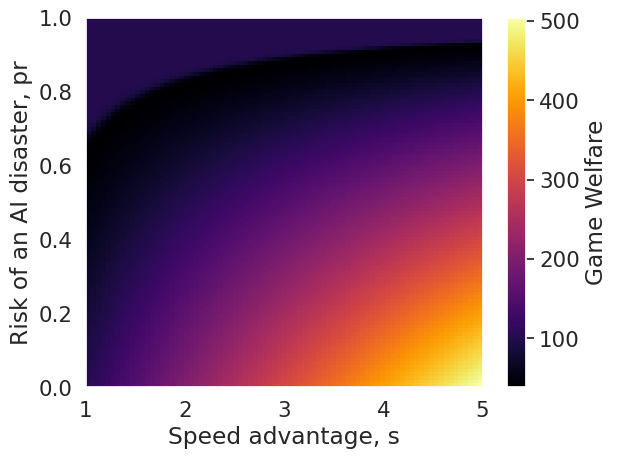

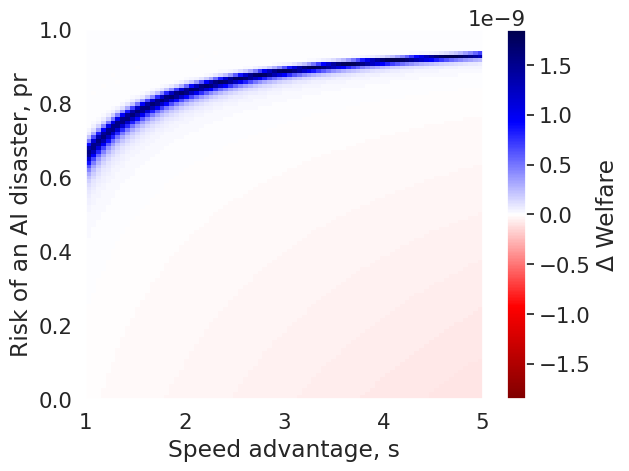

In [18]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro({**models_baseline, "sd-method": "quantecon"},
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                calculate_sd_helper,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)
plot_data = df
plot_data['weighted_welfare_change'] = plot_data.welfare_change
plot_useful_figs1(plot_data,
                    results['strategy_set'])
plot_useful_figs2(plot_data)
print({"new_welfare": plot_data["game_welfare"].mean(),
        "old_welfare": df_baseline["game_welfare"].mean()})

#### Set 3

A record of the values chosen for the third set of images

<!-- models = {**models,
          **build_reg_market(pfo_h=0.6,
                             g=1.2,
                             incentive_mix=0,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}


models = {**models,
          **build_reg_market(pfo_h=0.6,
                             g=1.2,
                             incentive_mix=0,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             β =1/50,
                             )
          }
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=0,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             β =1/50,
                             )
          }
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

 -->

In [69]:
models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=0,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             β =1/50,
                             )
          }
models['Z'] = {"S1": 50, "S2": 50}
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s': (8181,),
 'p': (8181,),
 'pfo_h': (8181,),
 'g': (8181,),
 'phi_h': (8181,),
 'phi2_h': (8181,),
 'collective_risk': (8181,),
 'b': (8181,),
 'c': (8181,),
 'B': (8181,),
 'W': (8181,),
 'pfo_l': (8181,),
 'λ': (8181,),
 'r_l': (8181,),
 'r_h': (8181,),
 'externality': (8181,),
 'decisiveness': (8181,),
 'incentive_mix': (8181,)}

In [70]:
results = thread_macro({**models, "sd-method": "quantecon"},
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       calculate_sd_helper,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)


/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

{'new_welfare': 162.97745885194317, 'old_welfare': 163.44309122359383}


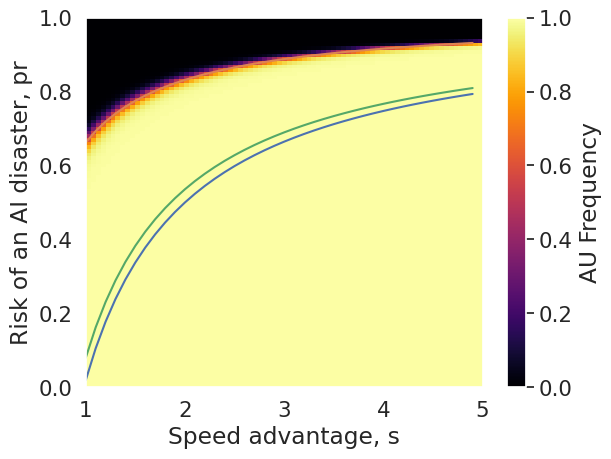

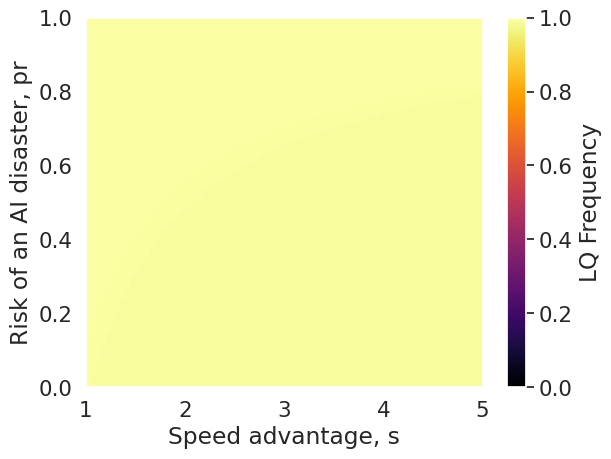

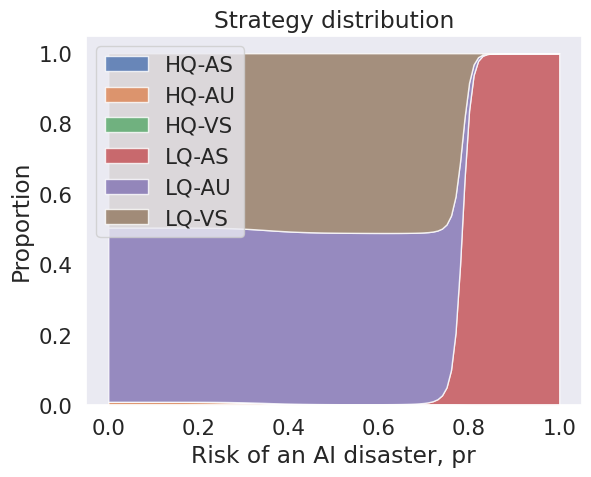

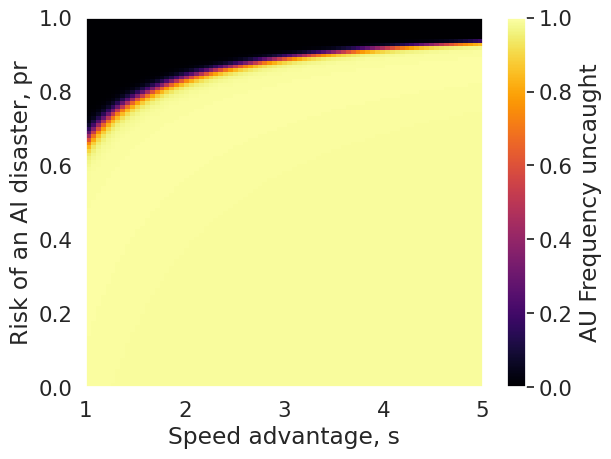

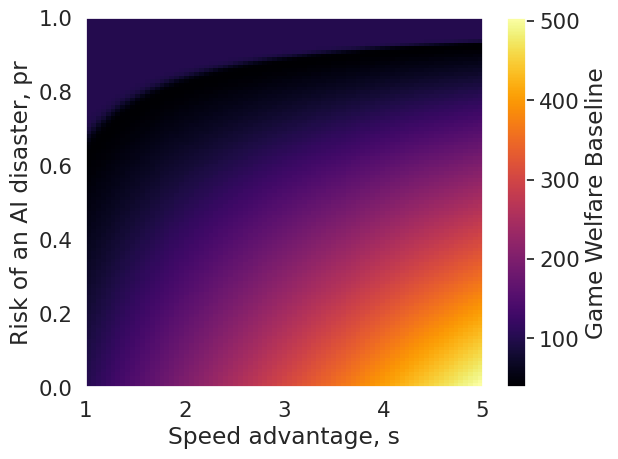

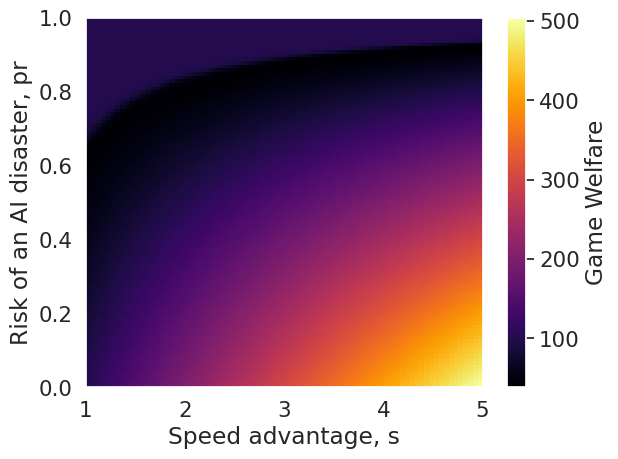

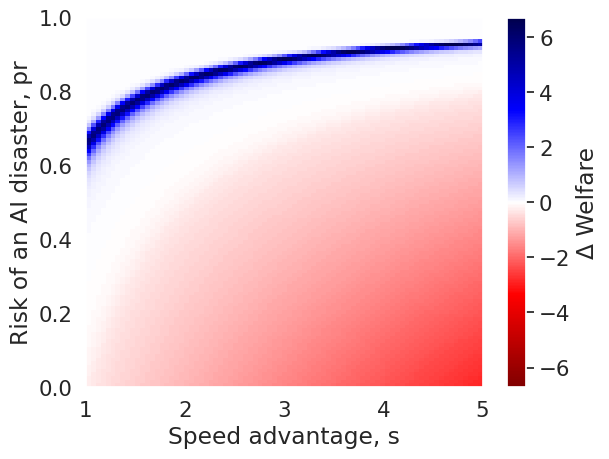

In [71]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro({**models_baseline, "sd-method": "quantecon"},
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                calculate_sd_helper,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)
plot_data = df
plot_data['weighted_welfare_change'] = plot_data.welfare_change
plot_useful_figs1(plot_data,
                    results['strategy_set'])
plot_useful_figs2(plot_data)
print({"new_welfare": plot_data["game_welfare"].mean(),
        "old_welfare": df_baseline["game_welfare"].mean()})

#### Set 4

A record of the values chosen for the fourth set of images

<!-- models = {**models,
          **build_reg_market(pfo_h=np.arange(0, 1, 0.2),
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)} -->

In [ ]:
models = {**models,
          **build_reg_market(pfo_h=np.arange(0, 1, 0.2),
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'β': (40905,),
 's': (40905,),
 'p': (40905,),
 'pfo_h': (40905,),
 'g': (40905,),
 'phi_h': (40905,),
 'phi2_h': (40905,),
 'collective_risk': (40905,),
 'b': (40905,),
 'c': (40905,),
 'B': (40905,),
 'W': (40905,),
 'pfo_l': (40905,),
 'λ': (40905,),
 'r_l': (40905,),
 'r_h': (40905,),
 'externality': (40905,),
 'decisiveness': (40905,),
 'incentive_mix': (40905,)}

In [ ]:
results = thread_macro(models,
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)


/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

In [ ]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro(models_baseline,
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                find_ergodic_distribution,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)
plot_data = df
plot_data['weighted_welfare_change'] = plot_data.welfare_change

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

β    s    p  pfo_h    g  phi_h  phi2_h  collective_risk  b  c  ...  \
0      1  1.0  0.0    0.0  1.2    0.5     0.5              0.0  4  1  ...   
1      1  1.0  0.0    0.2  1.2    0.5     0.5              0.0  4  1  ...   
2      1  1.0  0.0    0.4  1.2    0.5     0.5              0.0  4  1  ...   
3      1  1.0  0.0    0.6  1.2    0.5     0.5              0.0  4  1  ...   
4      1  1.0  0.0    0.8  1.2    0.5     0.5              0.0  4  1  ...   
...   ..  ...  ...    ...  ...    ...     ...              ... .. ..  ...   
40900  1  5.0  1.0    0.0  1.2    0.1     0.1              0.0  4  1  ...   
40901  1  5.0  1.0    0.2  1.2    0.1     0.1              0.0  4  1  ...   
40902  1  5.0  1.0    0.4  1.2    0.1     0.1              0.0  4  1  ...   
40903  1  5.0  1.0    0.6  1.2    0.1     0.1              0.0  4  1  ...   
40904  1  5.0  1.0    0.8  1.2    0.1     0.1              0.0  4  1  ...   

       LQ-AU_frequency  LQ-VS_frequency   pr  AU_frequency  LQ_frequency  \
0         2.320271e-17     4.050888e-19  1.0  5.016872e-17      1.000000   
1         8.184665e-18     1.088356e-19  1.0  1.804541e-17      1.000000   
2         7.541885e-18     9.884458e-20  1.0  1.746406e-17      1.000000   
3         6.275980e-18     1.666154e-19  1.0  1.693285e-17      1.000000   
4         6.219969e-18     1.639638e-19  1.0  2.825274e-17      1.000000   
...                ...              ...  ...           ...           ...   
40900     8.725343e-01     8.699438e-02  0.0  9.842892e-01      0.959588   
40901     8.718983e-01     8.693097e-02  0.0  9.843007e-01      0.958888   
40902     8.695095e-01     8.669280e-02  0.0  9.843437e-01      0.956261   
40903     8.627355e-01     8.601741e-02  0.0  9.844656e-01      0.948811   
40904     8.303200e-01     8.278549e-02  0.0  9.850493e-01      0.913162   

       AU_frequency_uncaught  game_welfare_baseline  welfare_change  \
0               5.016872e-17                  102.0       -1.200000   
1               1.804541e-17                  102.0       -1.200000   
2               1.746406e-17                  102.0       -1.200000   
3               1.693285e-17                  102.0       -1.200000   
4               2.825274e-17                  102.0       -1.200000   
...                      ...                    ...             ...   
40900           9.842892e-01                  504.0       -6.334594   
40901           9.762074e-01                  504.0       -6.792537   
40902           9.671221e-01                  504.0       -8.356820   
40903           9.542296e-01                  504.0      -12.100350   
40904           9.166174e-01                  504.0      -26.932100   

       weighted_welfare_change  deviance_from_se  
0                    -1.200000          0.662338  
1                    -1.200000          0.557989  
2                    -1.200000          0.399949  
3                    -1.200000          0.103672  
4                    -1.200000          0.000000  
...                        ...               ...  
40900                -6.334594          0.132921  
40901                -6.792537          0.111468  
40902                -8.356820          0.079043  
40903               -12.100350          0.018356  
40904               -26.932100          0.156695  

[40905 rows x 40 columns]

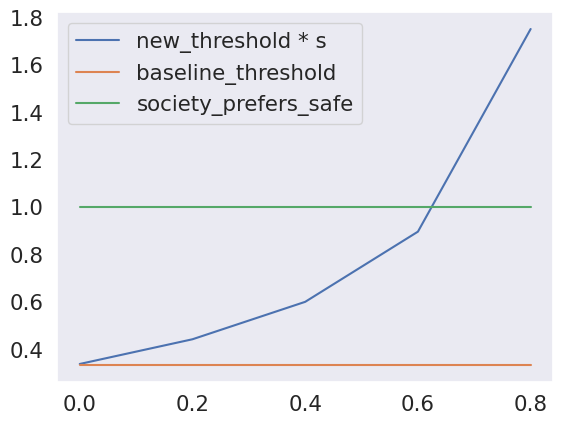

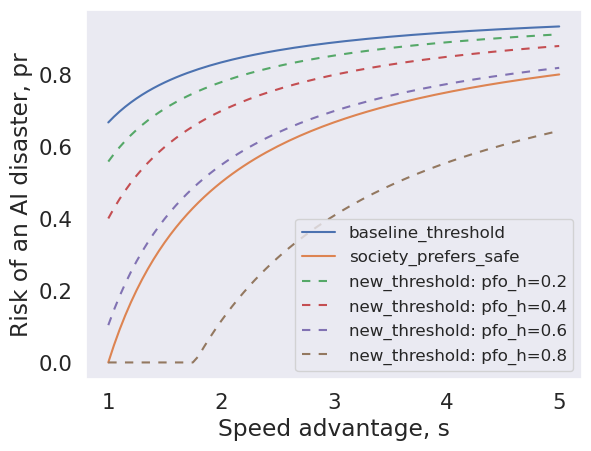

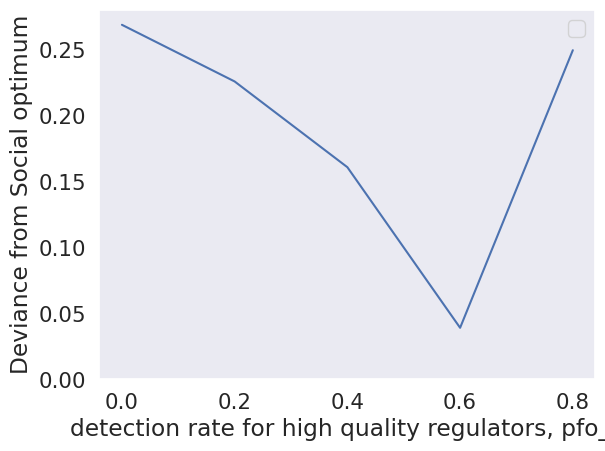

In [ ]:
plot_useful_figs4(plot_data)

#### Set 5

A record of the values chosen for the fifth set of images

<!-- models = {**models,
          **build_reg_market(pfo_h=np.arange(0, 1, 0.2),
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([1]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)} -->

In [ ]:
models = {**models,
          **build_reg_market(pfo_h=np.arange(0, 1, 0.2),
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([1]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'β': (40905,),
 's': (40905,),
 'p': (40905,),
 'pfo_h': (40905,),
 'phi_h': (40905,),
 'phi2_h': (40905,),
 'collective_risk': (40905,),
 'b': (40905,),
 'c': (40905,),
 'B': (40905,),
 'W': (40905,),
 'pfo_l': (40905,),
 'λ': (40905,),
 'r_l': (40905,),
 'r_h': (40905,),
 'g': (40905,),
 'externality': (40905,),
 'decisiveness': (40905,),
 'incentive_mix': (40905,)}

In [ ]:
results = thread_macro(models,
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)


/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:67: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:70: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:38: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:41: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:220: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 

In [ ]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro(models_baseline,
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                find_ergodic_distribution,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)
plot_data = df
plot_data['weighted_welfare_change'] = plot_data.welfare_change

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:67: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:70: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:38: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:41: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:220: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 

β    s    p  pfo_h  phi_h  phi2_h  collective_risk  b  c      B  ...  \
0      1  1.0  0.0    0.0    0.5     0.5              1.0  4  1  10000  ...   
1      1  1.0  0.0    0.2    0.5     0.5              1.0  4  1  10000  ...   
2      1  1.0  0.0    0.4    0.5     0.5              1.0  4  1  10000  ...   
3      1  1.0  0.0    0.6    0.5     0.5              1.0  4  1  10000  ...   
4      1  1.0  0.0    0.8    0.5     0.5              1.0  4  1  10000  ...   
...   ..  ...  ...    ...    ...     ...              ... .. ..    ...  ...   
40900  1  5.0  1.0    0.0    0.1     0.1              1.0  4  1  10000  ...   
40901  1  5.0  1.0    0.2    0.1     0.1              1.0  4  1  10000  ...   
40902  1  5.0  1.0    0.4    0.1     0.1              1.0  4  1  10000  ...   
40903  1  5.0  1.0    0.6    0.1     0.1              1.0  4  1  10000  ...   
40904  1  5.0  1.0    0.8    0.1     0.1              1.0  4  1  10000  ...   

       LQ-AU_frequency  LQ-VS_frequency   pr  AU_frequency  LQ_frequency  \
0         2.263223e-16     1.408466e-17  1.0  2.968633e-16      1.000000   
1         3.658149e-17     7.635630e-18  1.0  5.385206e-17      1.000000   
2         3.456141e-17     7.239185e-18  1.0  5.176664e-17      1.000000   
3         2.797363e-17     6.640218e-18  1.0  4.498033e-17      1.000000   
4         2.814411e-17     6.096103e-18  1.0  5.613558e-17      1.000000   
...                ...              ...  ...           ...           ...   
40900     8.725343e-01     8.699438e-02  0.0  9.842892e-01      0.959588   
40901     8.718983e-01     8.693097e-02  0.0  9.843007e-01      0.958888   
40902     8.695095e-01     8.669280e-02  0.0  9.843437e-01      0.956261   
40903     8.627355e-01     8.601741e-02  0.0  9.844656e-01      0.948811   
40904     8.303200e-01     8.278549e-02  0.0  9.850493e-01      0.913162   

       AU_frequency_uncaught  game_welfare_baseline  welfare_change  \
0               2.968633e-16                  102.0       -1.200000   
1               5.385206e-17                  102.0       -1.200000   
2               5.176664e-17                  102.0       -1.200000   
3               4.498033e-17                  102.0       -1.200000   
4               5.613558e-17                  102.0       -1.200000   
...                      ...                    ...             ...   
40900           9.842892e-01                  504.0       -6.334594   
40901           9.762074e-01                  504.0       -6.792537   
40902           9.671221e-01                  504.0       -8.356820   
40903           9.542296e-01                  504.0      -12.100350   
40904           9.166174e-01                  504.0      -26.932100   

       weighted_welfare_change  deviance_from_se  
0                    -1.200000          0.588187  
1                    -1.200000          0.469167  
2                    -1.200000          0.313852  
3                    -1.200000          0.073772  
4                    -1.200000          0.000000  
...                        ...               ...  
40900                -6.334594          0.105050  
40901                -6.792537          0.069640  
40902                -8.356820          0.018448  
40903               -12.100350          0.068453  
40904               -26.932100          0.274525  

[40905 rows x 40 columns]

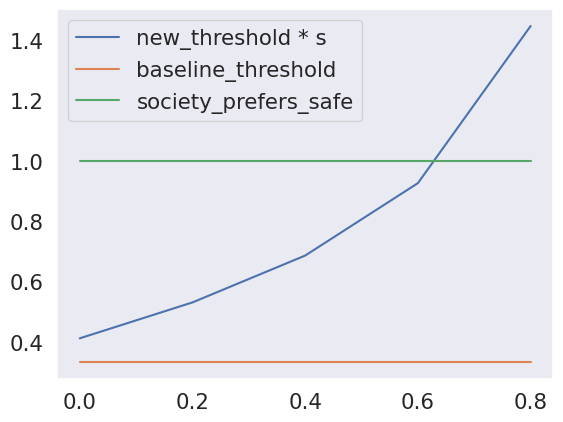

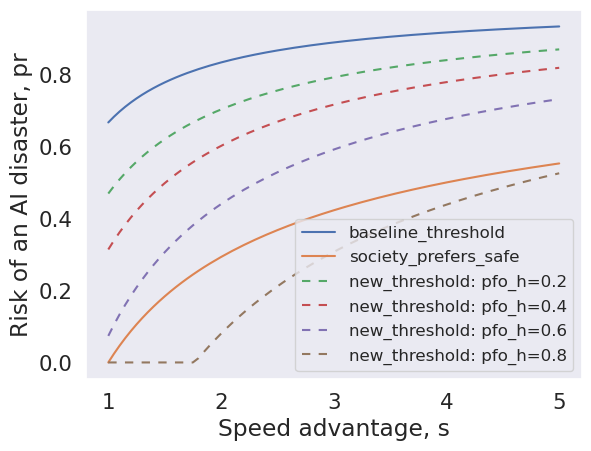

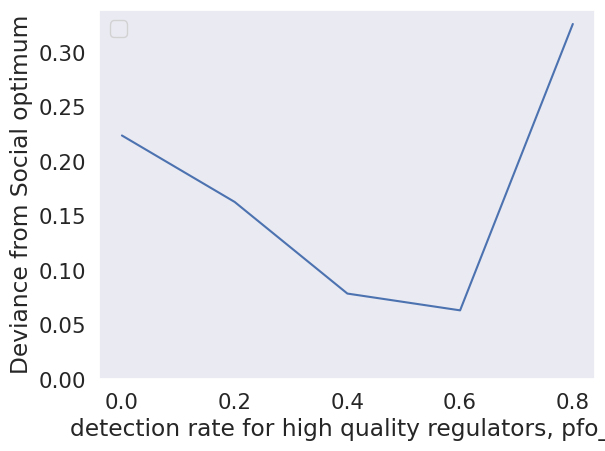

In [ ]:
plot_useful_figs4(plot_data)

#### Set 6

A record of the values chosen for the sixth set of images

<!-- models = {**models,
          **build_reg_market(pfo_h=np.arange(0, 1, 0.2),
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([1]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
# models['phi_h'] = models['phi_h']  / models['s']
# models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}; -->

In [ ]:
models = {**models,
          **build_reg_market(pfo_h=np.arange(0, 1, 0.2),
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([1]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
# models['phi_h'] = models['phi_h']  / models['s']
# models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)};

In [ ]:
results = thread_macro(models,
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)


/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:67: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:70: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:38: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:41: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:220: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 

In [ ]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro(models_baseline,
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                find_ergodic_distribution,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)
plot_data = df
plot_data['weighted_welfare_change'] = plot_data.welfare_change

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:67: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:70: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:38: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:41: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:220: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 

β    s    p  pfo_h  phi_h  phi2_h  collective_risk  b  c      B  ...  \
0      1  1.0  0.0    0.0    0.5     0.5              1.0  4  1  10000  ...   
1      1  1.0  0.0    0.2    0.5     0.5              1.0  4  1  10000  ...   
2      1  1.0  0.0    0.4    0.5     0.5              1.0  4  1  10000  ...   
3      1  1.0  0.0    0.6    0.5     0.5              1.0  4  1  10000  ...   
4      1  1.0  0.0    0.8    0.5     0.5              1.0  4  1  10000  ...   
...   ..  ...  ...    ...    ...     ...              ... .. ..    ...  ...   
40900  1  5.0  1.0    0.0    0.5     0.5              1.0  4  1  10000  ...   
40901  1  5.0  1.0    0.2    0.5     0.5              1.0  4  1  10000  ...   
40902  1  5.0  1.0    0.4    0.5     0.5              1.0  4  1  10000  ...   
40903  1  5.0  1.0    0.6    0.5     0.5              1.0  4  1  10000  ...   
40904  1  5.0  1.0    0.8    0.5     0.5              1.0  4  1  10000  ...   

       LQ-AU_frequency  LQ-VS_frequency   pr  AU_frequency  LQ_frequency  \
0         2.263223e-16     1.408466e-17  1.0  2.968633e-16      1.000000   
1         3.658149e-17     7.635630e-18  1.0  5.385206e-17      1.000000   
2         3.456141e-17     7.239185e-18  1.0  5.176664e-17      1.000000   
3         2.797363e-17     6.640218e-18  1.0  4.498033e-17      1.000000   
4         2.814411e-17     6.096103e-18  1.0  5.613558e-17      1.000000   
...                ...              ...  ...           ...           ...   
40900     8.725343e-01     8.699438e-02  0.0  9.842892e-01      0.959588   
40901     8.718983e-01     8.693097e-02  0.0  9.843007e-01      0.958888   
40902     8.695095e-01     8.669280e-02  0.0  9.843437e-01      0.956261   
40903     8.627355e-01     8.601741e-02  0.0  9.844656e-01      0.948811   
40904     8.303200e-01     8.278549e-02  0.0  9.850493e-01      0.913162   

       AU_frequency_uncaught  game_welfare_baseline  welfare_change  \
0               2.968633e-16                  102.0       -1.200000   
1               5.385206e-17                  102.0       -1.200000   
2               5.176664e-17                  102.0       -1.200000   
3               4.498033e-17                  102.0       -1.200000   
4               5.613558e-17                  102.0       -1.200000   
...                      ...                    ...             ...   
40900           9.842892e-01                  504.0       -6.334594   
40901           9.762074e-01                  504.0       -6.792537   
40902           9.671221e-01                  504.0       -8.356820   
40903           9.542296e-01                  504.0      -12.100350   
40904           9.166174e-01                  504.0      -26.932100   

       weighted_welfare_change  deviance_from_se  
0                    -1.200000          0.588187  
1                    -1.200000          0.469167  
2                    -1.200000          0.313852  
3                    -1.200000          0.073772  
4                    -1.200000          0.000000  
...                        ...               ...  
40900                -6.334594          0.105050  
40901                -6.792537          0.105351  
40902                -8.356820          0.113714  
40903               -12.100350          0.142410  
40904               -26.932100          0.200000  

[40905 rows x 40 columns]

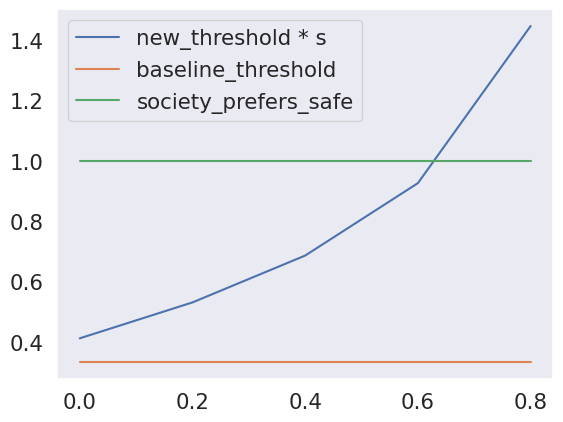

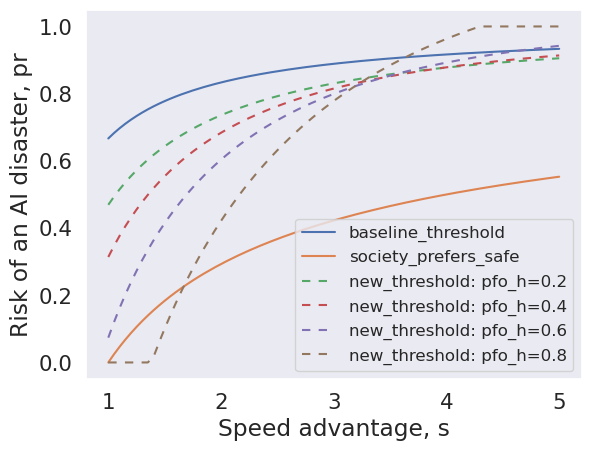

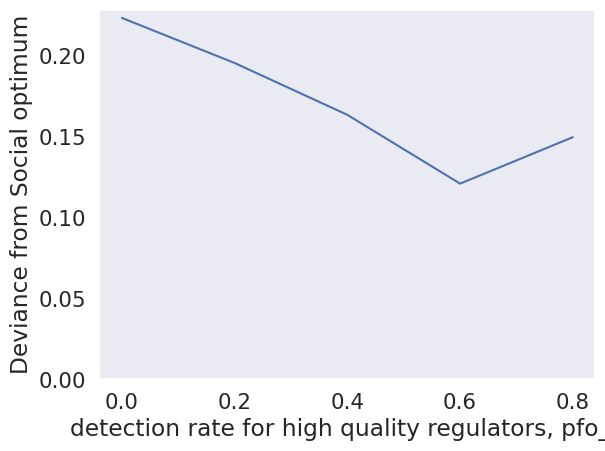

In [ ]:
plot_useful_figs4(plot_data)

#### Set 7

A record of the values chosen for the seventh set of images

<!-- models = {**models,
          **build_reg_market(pfo_h=np.arange(0, 1, 0.2),
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}; -->

In [ ]:
models = {**models,
          **build_reg_market(pfo_h=np.arange(0, 1, 0.2),
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)};

In [ ]:
results = thread_macro(models,
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

In [ ]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro(models_baseline,
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                find_ergodic_distribution,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)
plot_data = df
plot_data['weighted_welfare_change'] = plot_data.welfare_change

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

β    s    p  pfo_h  phi_h  phi2_h  collective_risk  b  c      B  ...  \
0      1  1.0  0.0    0.0    1.0     1.0              0.0  4  1  10000  ...   
1      1  1.0  0.0    0.2    1.0     1.0              0.0  4  1  10000  ...   
2      1  1.0  0.0    0.4    1.0     1.0              0.0  4  1  10000  ...   
3      1  1.0  0.0    0.6    1.0     1.0              0.0  4  1  10000  ...   
4      1  1.0  0.0    0.8    1.0     1.0              0.0  4  1  10000  ...   
...   ..  ...  ...    ...    ...     ...              ... .. ..    ...  ...   
40900  1  5.0  1.0    0.0    0.2     0.2              0.0  4  1  10000  ...   
40901  1  5.0  1.0    0.2    0.2     0.2              0.0  4  1  10000  ...   
40902  1  5.0  1.0    0.4    0.2     0.2              0.0  4  1  10000  ...   
40903  1  5.0  1.0    0.6    0.2     0.2              0.0  4  1  10000  ...   
40904  1  5.0  1.0    0.8    0.2     0.2              0.0  4  1  10000  ...   

       LQ-AU_frequency  LQ-VS_frequency   pr  AU_frequency  LQ_frequency  \
0         2.320271e-17     4.050888e-19  1.0  5.016872e-17      1.000000   
1         8.142096e-18     1.646280e-19  1.0  1.800725e-17      1.000000   
2         7.540947e-18     9.220391e-20  1.0  1.745659e-17      1.000000   
3         6.198475e-18     3.279374e-19  1.0  1.688169e-17      1.000000   
4         6.134357e-18     1.777130e-19  1.0  2.788199e-17      1.000000   
...                ...              ...  ...           ...           ...   
40900     8.725343e-01     8.699438e-02  0.0  9.842892e-01      0.959588   
40901     8.718983e-01     8.693097e-02  0.0  9.843007e-01      0.958888   
40902     8.695095e-01     8.669280e-02  0.0  9.843437e-01      0.956261   
40903     8.627355e-01     8.601741e-02  0.0  9.844656e-01      0.948811   
40904     8.303200e-01     8.278549e-02  0.0  9.850493e-01      0.913162   

       AU_frequency_uncaught  game_welfare_baseline  welfare_change  \
0               5.016872e-17                  102.0       -1.200000   
1               1.800725e-17                  102.0       -1.200000   
2               1.745659e-17                  102.0       -1.200000   
3               1.688169e-17                  102.0       -1.200000   
4               2.788199e-17                  102.0       -1.200000   
...                      ...                    ...             ...   
40900           9.842892e-01                  504.0       -6.334594   
40901           9.762074e-01                  504.0       -6.792537   
40902           9.671221e-01                  504.0       -8.356820   
40903           9.542296e-01                  504.0      -12.100350   
40904           9.166174e-01                  504.0      -26.932100   

       weighted_welfare_change  deviance_from_se  
0                    -1.200000          0.662338  
1                    -1.200000          0.612226  
2                    -1.200000          0.542334  
3                    -1.200000          0.419546  
4                    -1.200000          0.079755  
...                        ...               ...  
40900                -6.334594          0.132921  
40901                -6.792537          0.122534  
40902                -8.356820          0.108114  
40903               -12.100350          0.082887  
40904               -26.932100          0.013292  

[40905 rows x 40 columns]

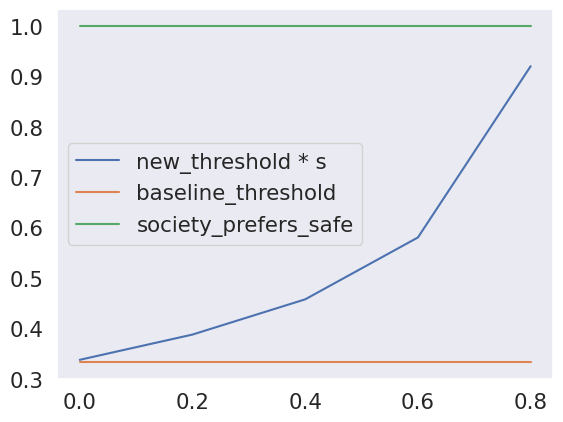

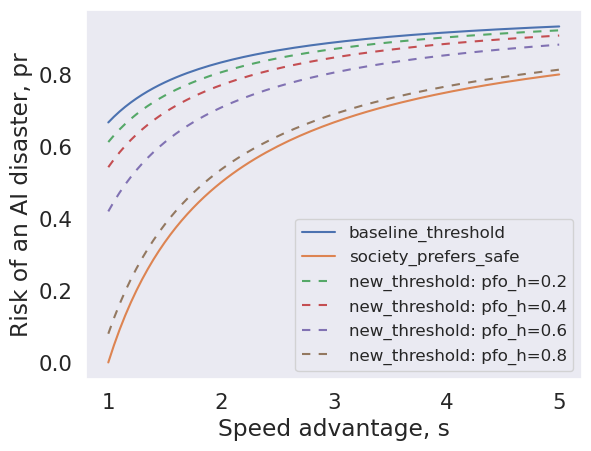

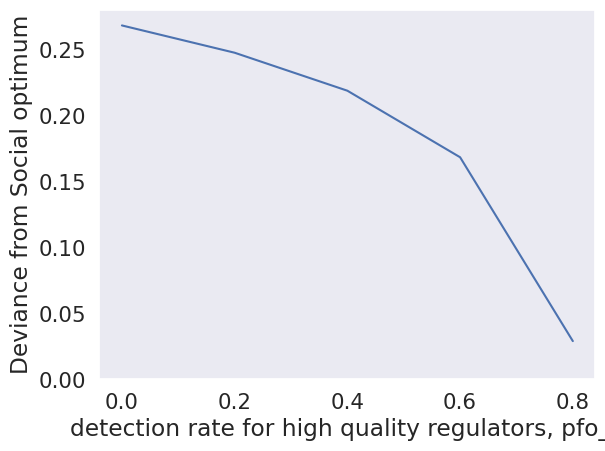

In [ ]:
plot_useful_figs4(plot_data)

#### Set 8

A record of the values chosen for the eighth set of images

<!-- models_gov = {**models,
              "sector_strategies": {"S1": [1, 2, 3],
                                    "S2": [4]},
              **build_reg_market(pfo_h=0.6,
                                 g=1.2,
                                 incentive_mix=1,
                                 s=np.arange(1, 5.05, 0.05),
                                 p=np.arange(0, 1.01, 0.01),
                                 phi_h=np.array([0.5]),
                                 phi2_h=np.array([0.5]),
                                 collective_risk=np.array([0]),
                                 strategy_set=["HQ-AS", "HQ-AU", "HQ-VS"]
                                 )
              }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models_gov['phi_h'] = models_gov['phi_h'] / models_gov['s']
models_gov['phi2_h'] = models_gov['phi2_h'] / models_gov['s']
# Check the size of the created arrays using:
{k: models_gov[k].shape for k,
    v in models_gov.items() if isinstance(v, np.ndarray)}

models_gov = {**models,
              "sector_strategies": {"S1": [1, 2, 3],
                                    "S2": [4]},
              **build_reg_market(pfo_h=0.6,
                                 g=1.2,
                                 incentive_mix=1,
                                 s=np.arange(1, 5.05, 0.05),
                                 p=np.arange(0, 1.01, 0.01),
                                 phi_h=np.array([0.5]),
                                 phi2_h=np.array([0.5]),
                                 collective_risk=np.array([0]),
                                 strategy_set=["HQ-AS", "HQ-AU", "HQ-VS"],
                             β =1/50,
                             )
          }
models_gov['β'] = {"S1": models_gov['β'], "S2": models_gov['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models_gov['phi_h'] = models_gov['phi_h'] / models_gov['s']
models_gov['phi2_h'] = models_gov['phi2_h'] / models_gov['s']
# Check the size of the created arrays using:
{k: models_gov[k].shape for k,
    v in models_gov.items() if isinstance(v, np.ndarray)}

    
models_gov = {**models,
              "sector_strategies": {"S1": [1, 2, 3],
                                    "S2": [4]},
              **build_reg_market(pfo_h=0.8,
                                 g=1.2,
                                 incentive_mix=1,
                                 s=np.arange(1, 5.05, 0.05),
                                 p=np.arange(0, 1.01, 0.01),
                                 phi_h=np.array([1]),
                                 phi2_h=np.array([1]),
                                 collective_risk=np.array([0]),
                                 strategy_set=["HQ-AS", "HQ-AU", "HQ-VS"],
                             β =1/50,
                             )
          }
models_gov['β'] = {"S1": models_gov['β'], "S2": models_gov['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models_gov['phi_h'] = models_gov['phi_h'] / models_gov['s']
models_gov['phi2_h'] = models_gov['phi2_h'] / models_gov['s']
# Check the size of the created arrays using:
{k: models_gov[k].shape for k,
    v in models_gov.items() if isinstance(v, np.ndarray)}

     -->


In [80]:
models_gov = {**models,
              "sector_strategies": {"S1": [1, 2, 3],
                                    "S2": [4]},
              **build_reg_market(pfo_h=0.6,
                                 g=1.2,
                                 incentive_mix=1,
                                 s=np.arange(1, 5.05, 0.05),
                                 p=np.arange(0, 1.01, 0.01),
                                 phi_h=np.array([0.5]),
                                 phi2_h=np.array([0.5]),
                                 collective_risk=np.array([0]),
                                 strategy_set=["HQ-AS", "HQ-AU", "HQ-VS"],
                             β =1/50,
                             )
          }
models['Z'] = {"S1": 10, "S2": 50}
models_gov['β'] = {"S1": models_gov['β'], "S2": models_gov['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models_gov['phi_h'] = models_gov['phi_h'] / models_gov['s']
models_gov['phi2_h'] = models_gov['phi2_h'] / models_gov['s']
# Check the size of the created arrays using:
{k: models_gov[k].shape for k,
    v in models_gov.items() if isinstance(v, np.ndarray)}


{'s': (8181,),
 'p': (8181,),
 'phi_h': (8181,),
 'phi2_h': (8181,),
 'collective_risk': (8181,),
 'b': (8181,),
 'c': (8181,),
 'B': (8181,),
 'W': (8181,),
 'pfo_l': (8181,),
 'pfo_h': (8181,),
 'λ': (8181,),
 'r_l': (8181,),
 'r_h': (8181,),
 'g': (8181,),
 'externality': (8181,),
 'decisiveness': (8181,),
 'incentive_mix': (8181,)}

In [81]:
results = thread_macro({**models_gov, "sd-method": "quantecon"},
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       calculate_sd_helper,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

In [82]:
models_baseline = copy.deepcopy(models_gov)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro({**models_baseline, "sd-method": "quantecon"},
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                calculate_sd_helper,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

df = thread_macro(df,
                  compute_frequencies_hq_only,
                  (compute_welfare_change, df_baseline),)
plot_data = df
plot_data['weighted_welfare_change'] = plot_data.welfare_change

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

{'new_welfare': 134.67375549801125, 'old_welfare': 163.95015105637432}


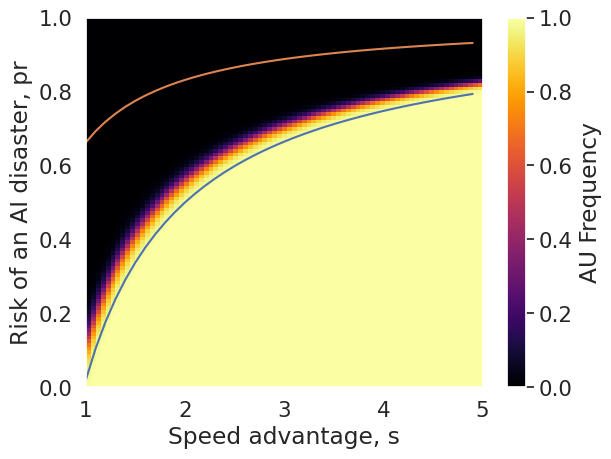

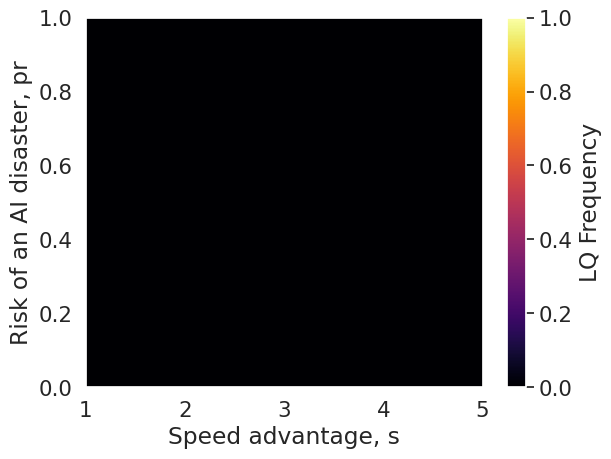

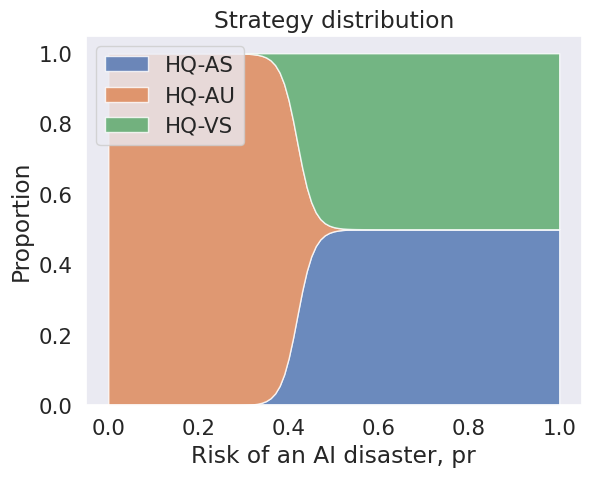

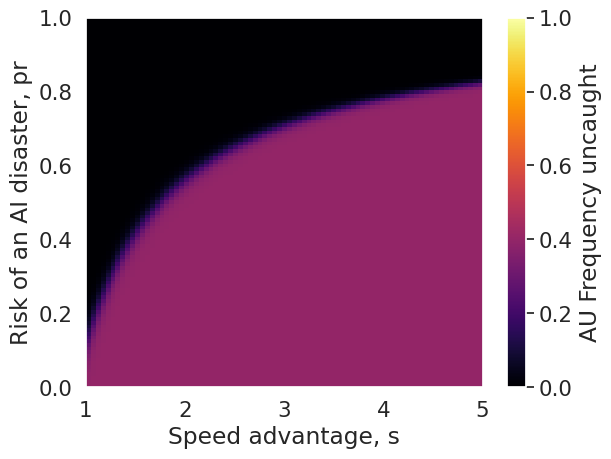

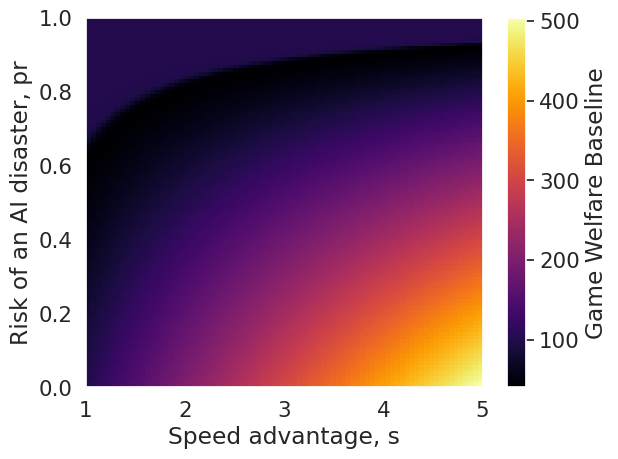

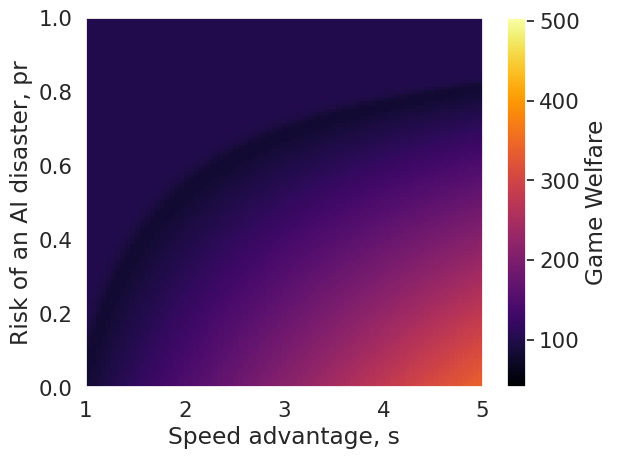

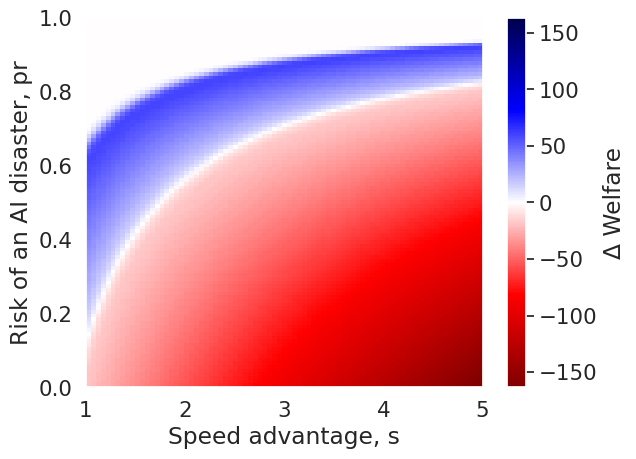

In [83]:
plot_useful_figs1(plot_data,
                    results['strategy_set'])
plot_useful_figs2(plot_data)
print({"new_welfare": plot_data["game_welfare"].mean(),
        "old_welfare": df_baseline["game_welfare"].mean()})

#### Set 9

A record of the values chosen for the ninth
 set of images

<!-- models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0, 1]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)};

models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0, 1]),
                             β =1/50,
                             )
          }
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)};

models = {**models,
          **build_reg_market(pfo_h=0.6,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0, 1]),
                             β =1/50,
                             )
          }
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)};

 -->


In [84]:
models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0, 1]),
                             β =1/50,
                             )
          }
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)};

In [85]:
results = thread_macro({**models, "sd-method": "quantecon"},
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       calculate_sd_helper,
                       compute_game_welfare
                       )
df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)


/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:67: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:70: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:38: 

In [86]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro({**models_baseline, "sd-method": "quantecon"},
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                calculate_sd_helper,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)
df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)
plot_data = df
plot_data['weighted_welfare_change'] = plot_data.welfare_change

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:67: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:70: RuntimeWarning: divide by zero encountered in divide
  -c / b,
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:38: 

Text(-0.02, 0.45, 'Risk of an AI disaster, pr')

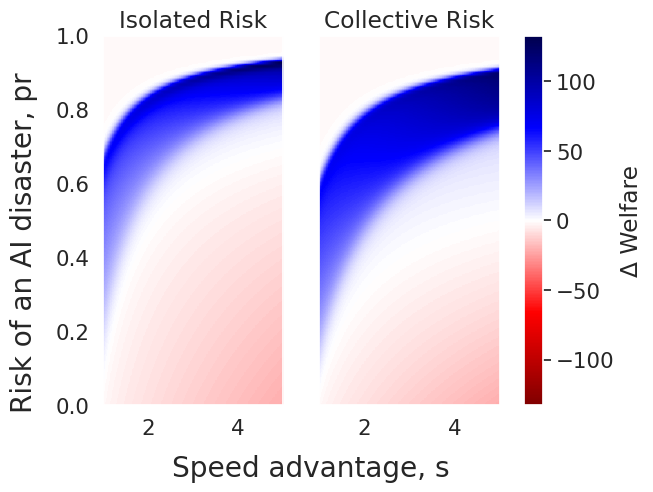

In [89]:
fig, axs = plt.subplots(1,
                        len(df.collective_risk.unique()),
                        sharey=True)
zmax = max(abs(df.welfare_change.min()),
           abs(df.welfare_change.max()))
zmin= -1 * zmax
for i, collective_risk in enumerate(df.collective_risk.unique()):
    table = df[df.collective_risk == collective_risk].pivot_table(
        index='pr', columns='s', values='welfare_change')
    heatmap, ax, im = plot_heatmap(table,
                               figure_object=(fig, axs[i]),
                               xlabel='Speed advantage, s',
                               ylabel=None,
                               zlabel='Δ Welfare',
                               cmap='seismic_r',
                               zmin=zmin,
                               zmax=zmax,
                               set_colorbar=False,
                               set_labels=False,
                               )

cax,kw = mpl.colorbar.make_axes([ax for ax in axs.flat])
cbar = plt.colorbar(im, cax=cax, **kw)
cbar.ax.set_ylabel('Δ Welfare')
axs[0].set_title("Isolated Risk")
axs[1].set_title("Collective Risk")
fig.supxlabel('Speed advantage, s', y=-0.05, x=0.45)
fig.supylabel('Risk of an AI disaster, pr', x=-0.02, y=0.45)
# fig.tight_layout(h_pad=2, v_pad=2,)


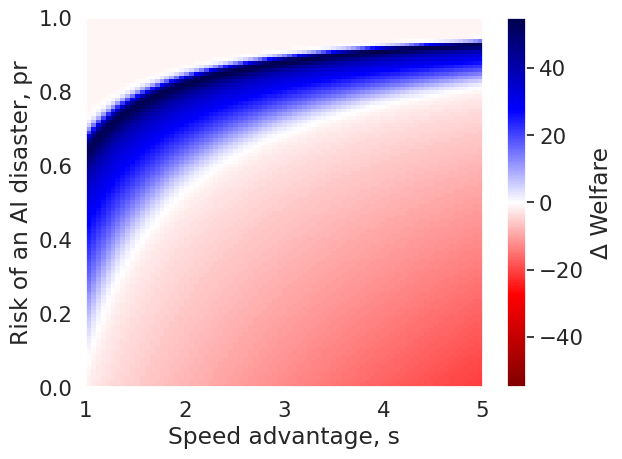

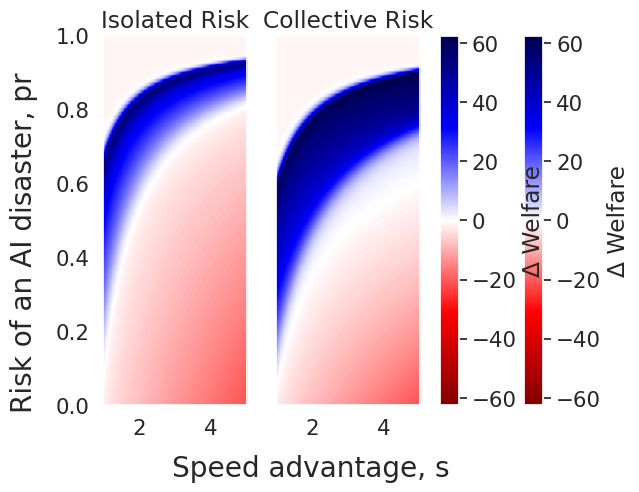

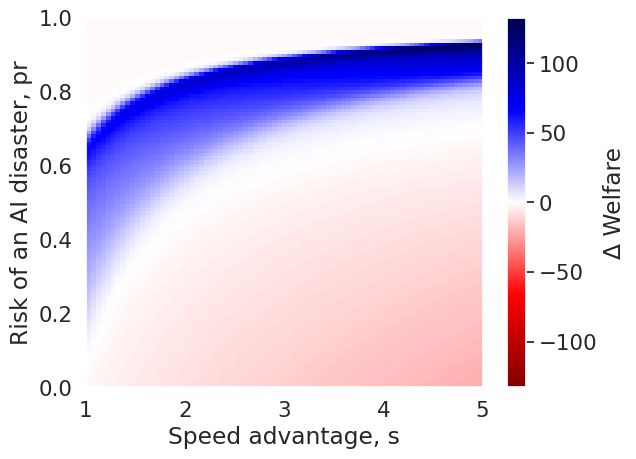

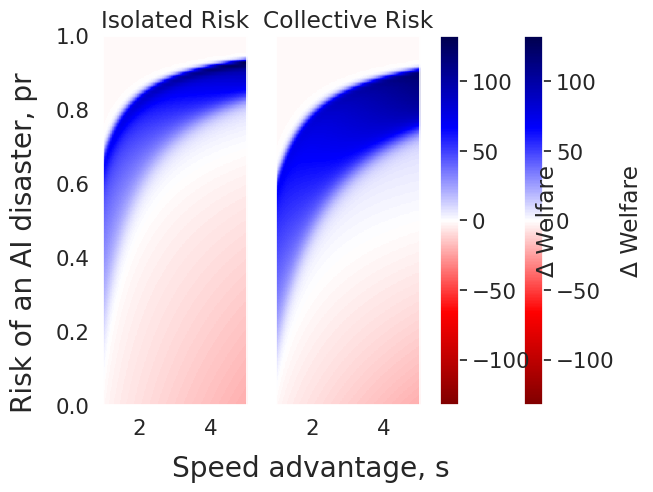

In [88]:
for scalar in [1e100, 5, ]:
    results['externality'] = results['s'] * \
        results['B'] / (results['W'] * scalar)
    results = compute_game_welfare(results)
    df["externality"] = results["externality"]
    df["game_welfare"] = results["game_welfare"]

    results_baseline['externality'] = results_baseline['s'] * \
        results_baseline['B'] / (results_baseline['W'] * scalar)
    results_baseline = compute_game_welfare(results_baseline)
    df_baseline["externality"] = results_baseline["externality"]
    df_baseline["game_welfare"] = results_baseline["game_welfare"]

    df['welfare_change'] = df.game_welfare - df_baseline.game_welfare
    # OR
    # df_baseline = welfare_baseline(df_baseline)

    df['weighted_welfare_change'] = df.welfare_change

    table = df[df.collective_risk == 0].pivot_table(
        index='pr', columns='s', values='welfare_change')
    heatmap, ax, im = plot_heatmap(table,
                                   xlabel='Speed advantage, s',
                                   ylabel='Risk of an AI disaster, pr',
                                   zlabel='Δ Welfare',
                                   cmap='seismic_r',
                                   zmin=None,
                                   zmax=None,
                                   norm=mpl.colors.CenteredNorm()
                                   )
    
    fig, axs = plt.subplots(1,
                            len(df.collective_risk.unique()),
                            sharey=True)
    zmax = max(abs(df.welfare_change.min()),
               abs(df.welfare_change.max()))
    zmin = -1 * zmax
    for i, collective_risk in enumerate(df.collective_risk.unique()):
        table = df[df.collective_risk == collective_risk].pivot_table(
            index='pr', columns='s', values='welfare_change')
        heatmap, ax, im = plot_heatmap(table,
                                       figure_object=(fig, axs[i]),
                                       xlabel='Speed advantage, s',
                                       ylabel=None,
                                       zlabel='Δ Welfare',
                                       cmap='seismic_r',
                                       zmin=zmin,
                                       zmax=zmax,
                                       set_colorbar=False,
                                       set_labels=False,
                                       )

        cax, kw = mpl.colorbar.make_axes([ax for ax in axs.flat])
        cbar = plt.colorbar(im, cax=cax, **kw)
        cbar.ax.set_ylabel('Δ Welfare')
        axs[0].set_title("Isolated Risk")
        axs[1].set_title("Collective Risk")
        fig.supxlabel('Speed advantage, s', y=-0.05, x=0.45)
        fig.supylabel('Risk of an AI disaster, pr', x=-0.02, y=0.45)
        # fig.tight_layout(h_pad=2, v_pad=2,)


A record of the values chosen for the tenth
 set of images

<!-- models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)};
          
models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=0,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)};
          

 -->


#### Set 10

In [33]:
models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)};
results = thread_macro(models,
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

Relative times for g=2: [0.035, 0.005, 0.886, 0.011, 0.044, 0.018]

In [34]:
default_idx = df[(df.s==1.5) & (df.p==0.4)].index[0]
np.round(results['ergodic'][default_idx], decimals=4)

array([0.018, 0.   , 0.575, 0.006, 0.34 , 0.061])

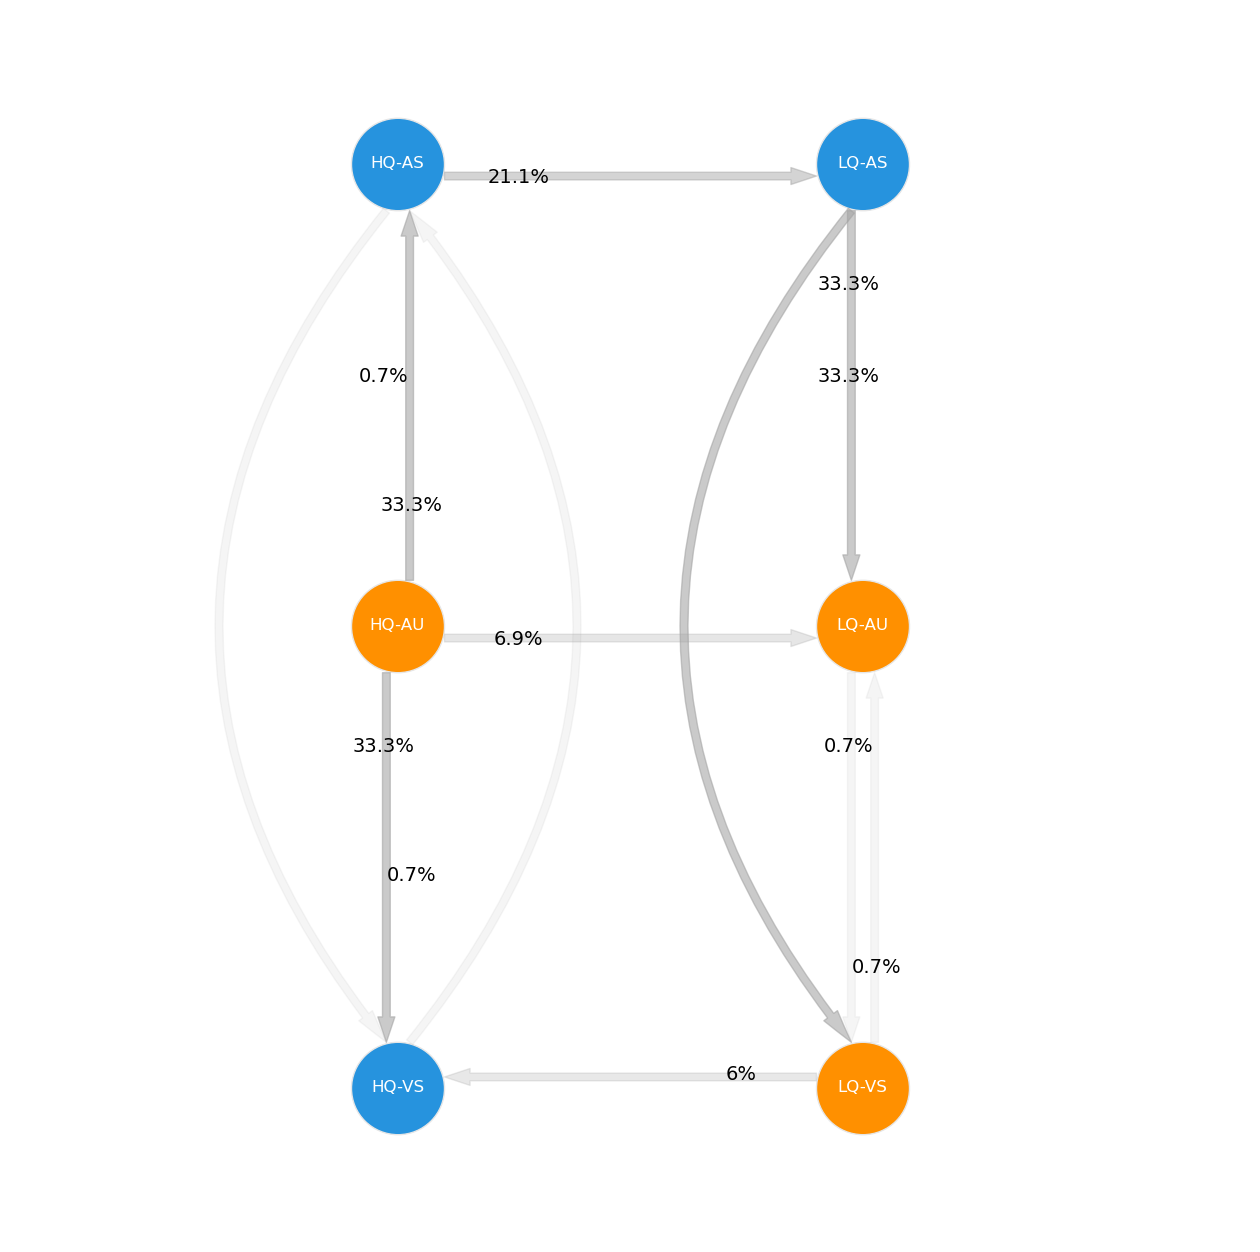

In [35]:
P = np.round(results['transition_matrix'][default_idx], decimals=4)
mc = MarkovChain(P,
                 ['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS'],
                 percentages=True,
                 self_arrows=False,
                #  annotate=False,
                 n_columns=2,
                 node_facecolor= ["#2693de", "#ff9000", "#2693de",
                                  "#2693de", "#ff9000", "#ff9000"],
                 transparency_func=lambda p:max(p**0.5, 0.1))
mc.draw()

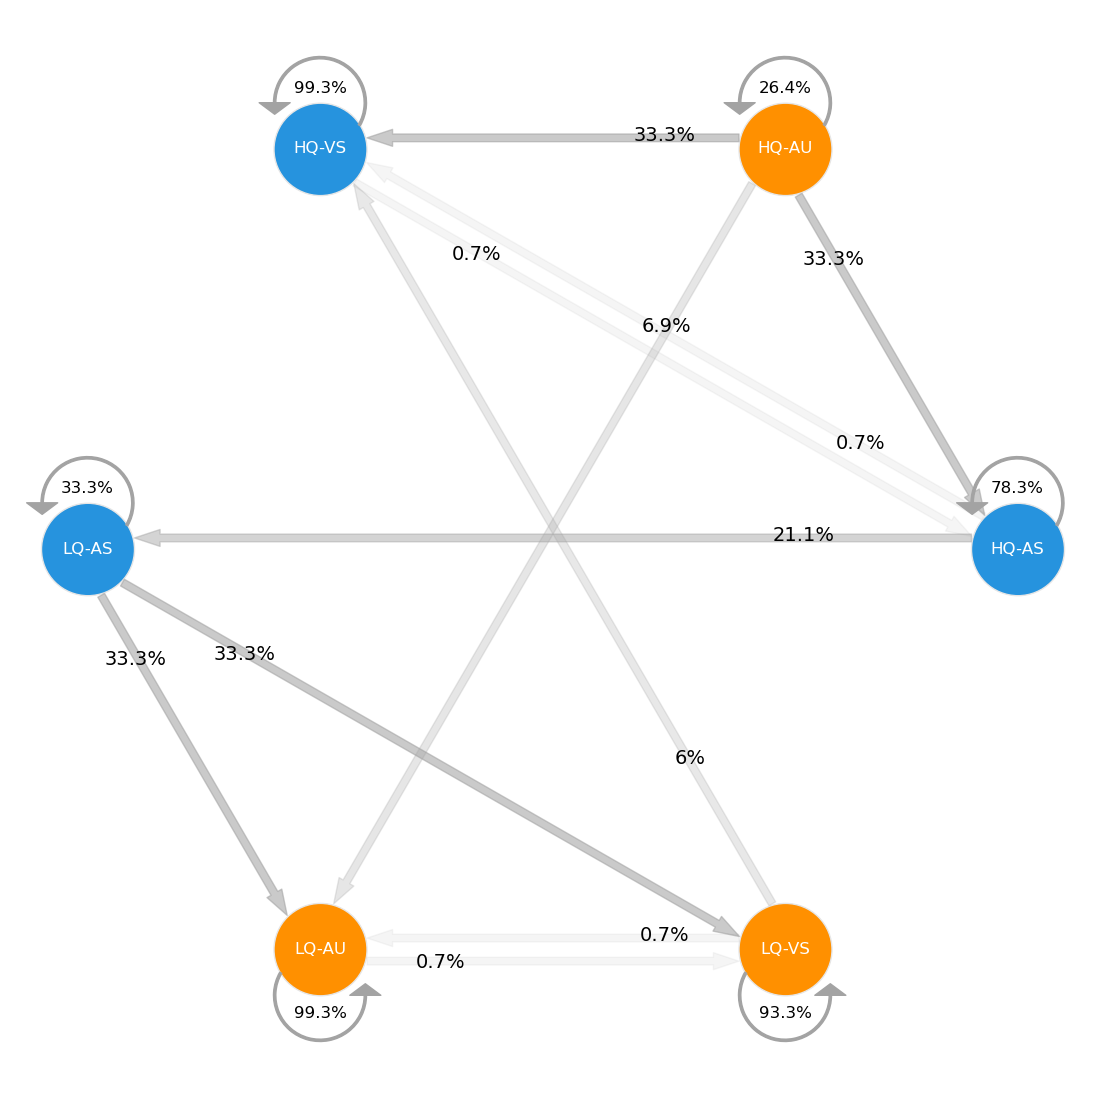

In [ ]:
default_idx = df[(df.s==1.5) & (df.p==0.4)].index[0]
P = np.round(results['transition_matrix'][default_idx], decimals=4)
mc = MarkovChain(P,
                 ['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS'],
                 percentages=True,
                 self_arrows=False,
                 annotate=False,
                 n_columns=2,
                 node_facecolor= ["#2693de", "#ff9000", "#2693de",
                                  "#2693de", "#ff9000", "#ff9000"],
                 transparency_func=lambda p:max(p**0.5, 0.1))
mc.draw()

In [15]:
models = {**models,
          **build_reg_market(pfo_h=0.8,
                             g=1.2,
                             incentive_mix=0,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([1]),
                             phi2_h = np.array([1]),
                             collective_risk=np.array([0]),
                             )
          }
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)};
results = thread_macro(models,
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

In [16]:
np.round(results['ergodic'][default_idx], decimals=4)

array([0.002, 0.001, 0.002, 0.001, 0.445, 0.549])

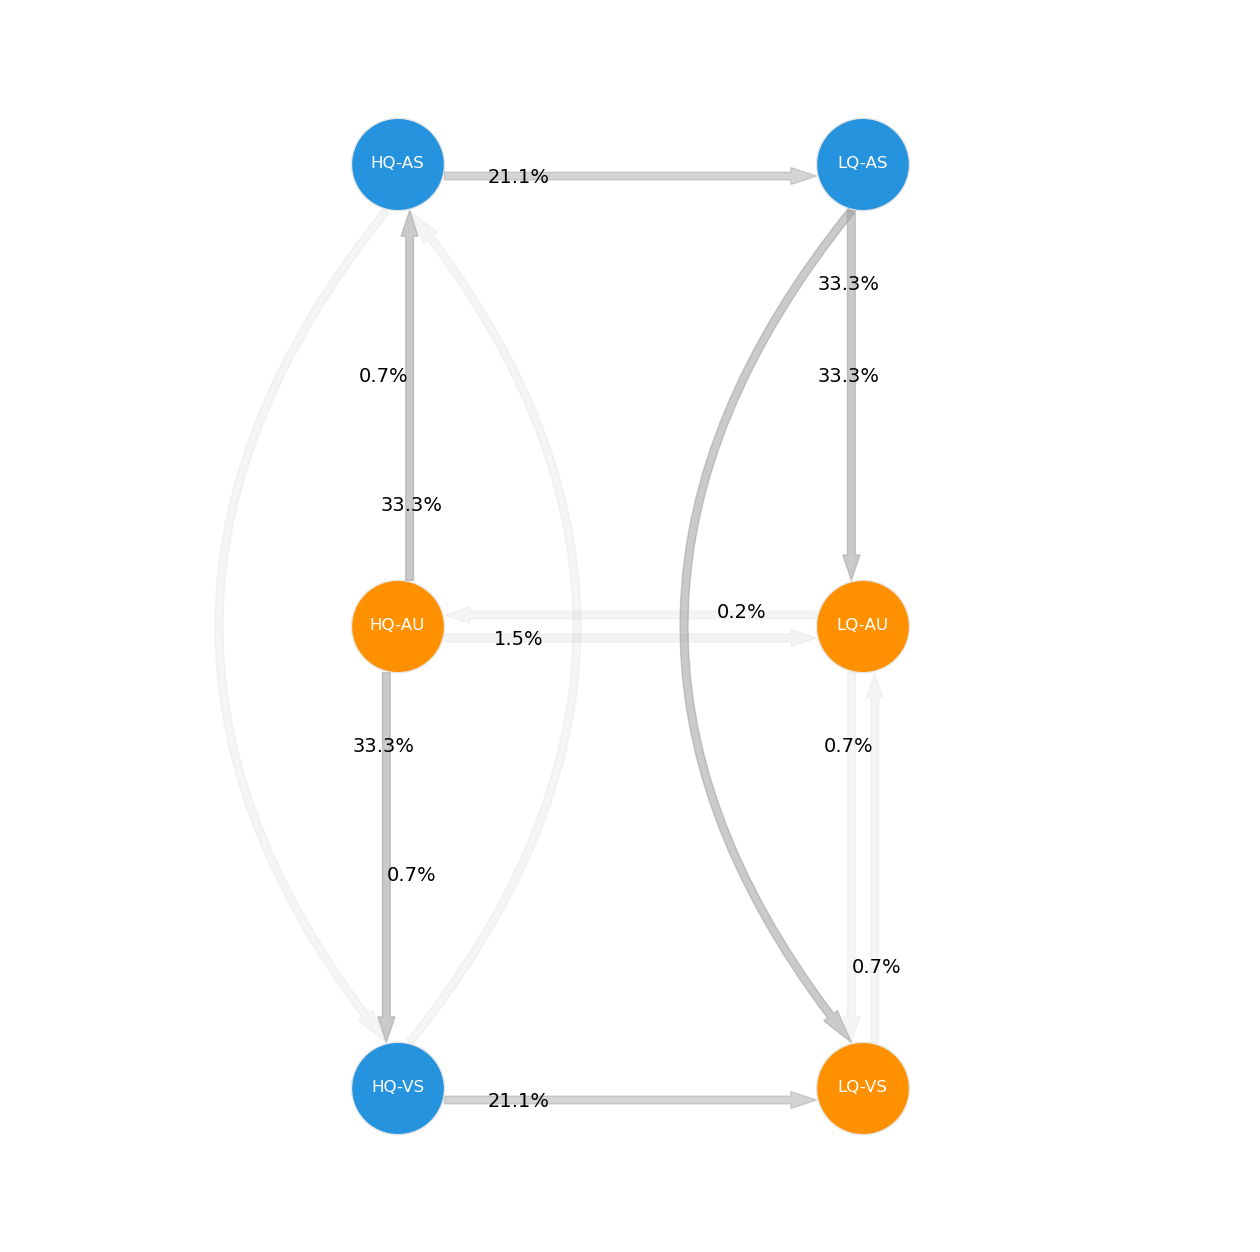

In [18]:
default_idx = df[(df.s==1.5) & (df.p==0.4)].index[0]
P = np.round(results['transition_matrix'][default_idx], decimals=4)
mc = MarkovChain(P,
                 ['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS'],
                 percentages=True,
                 self_arrows=False,
                #  annotate=False,
                 n_columns=2,
                 node_facecolor= ["#2693de", "#ff9000", "#2693de",
                                  "#2693de", "#ff9000", "#ff9000"],
                 transparency_func=lambda p:max(p**0.5, 0.1))
mc.draw()

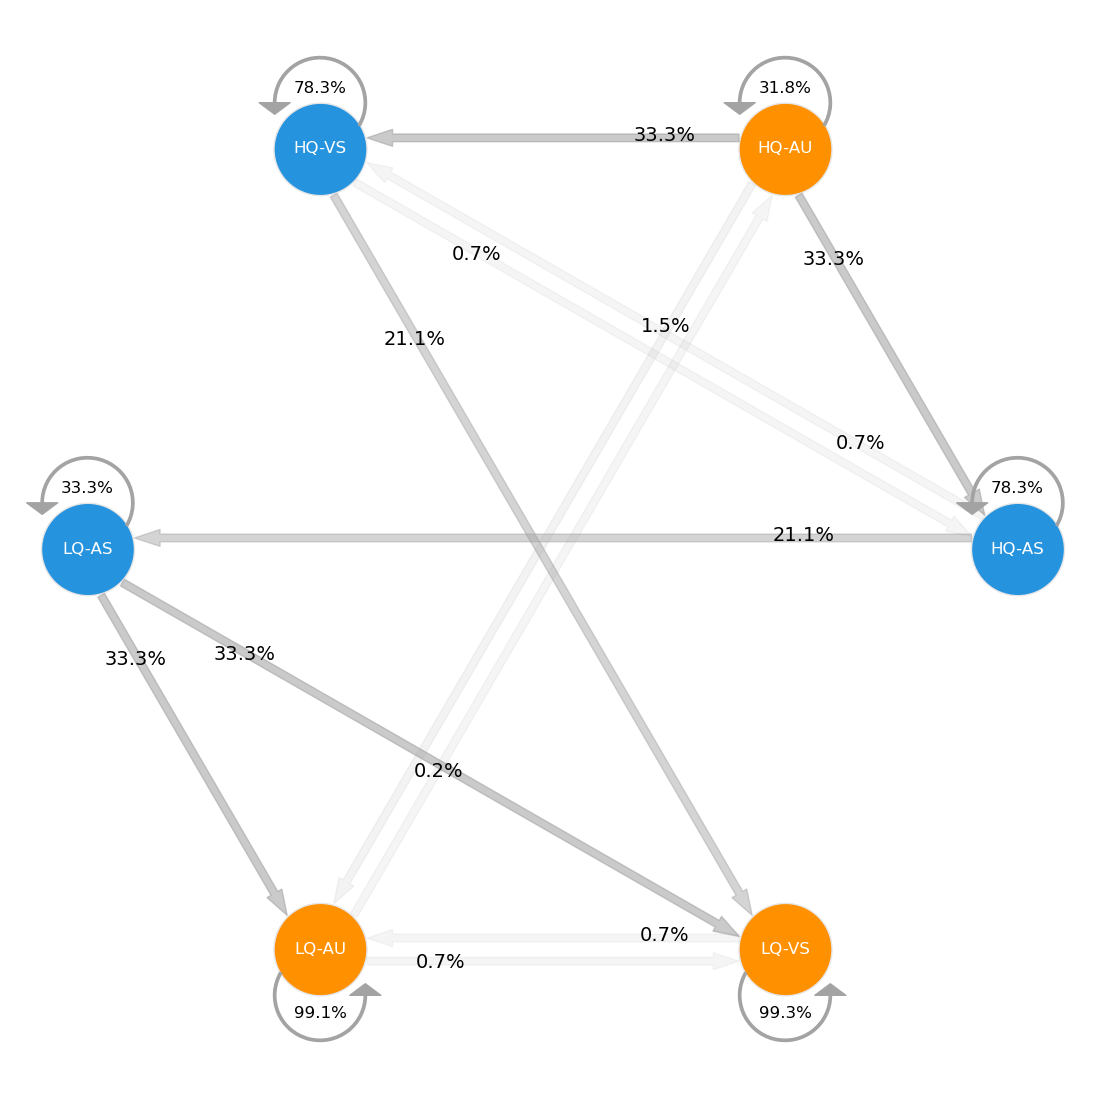

In [ ]:
default_idx = df[(df.s==1.5) & (df.p==0.4)].index[0]
P = np.round(results['transition_matrix'][default_idx], decimals=4)
mc = MarkovChain(P,
                 ['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS'],
                 percentages=True,
                 self_arrows=False,
                 annotate=False,
                 n_columns=2,
                 node_facecolor= ["#2693de", "#ff9000", "#2693de",
                                  "#2693de", "#ff9000", "#ff9000"],
                 transparency_func=lambda p:max(p**0.5, 0.1))
mc.draw()

### Set 11

A record of the values chosen for the second set of images

<!--

 -->

In [36]:
models = {**models,
          **build_reg_market(pfo_h=0.6,
                             g=1.2,
                             incentive_mix=1,
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             β = 1/50, #[1/500, 1/50, 1/5],
                            #  pfo_l=np.arange(0, 0.7, 0.1),
                            #  B=[10**3, 10**4, 10**5],
                            # r_h=np.arange(-2,0.5, 0.5),
                            # λ=[0, 1, 5, 10],
                             )
          }
models['Z'] = {"S1": 50, "S2": 50}
models['β1'] = models['β']
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s': (8181,),
 'p': (8181,),
 'phi_h': (8181,),
 'phi2_h': (8181,),
 'collective_risk': (8181,),
 'b': (8181,),
 'c': (8181,),
 'B': (8181,),
 'W': (8181,),
 'pfo_l': (8181,),
 'pfo_h': (8181,),
 'λ': (8181,),
 'r_l': (8181,),
 'r_h': (8181,),
 'g': (8181,),
 'externality': (8181,),
 'decisiveness': (8181,),
 'incentive_mix': (8181,),
 'β1': (8181,)}

In [37]:
results = thread_macro({**models, "sd-method": "quantecon"},
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       calculate_sd_helper,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)


/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

In [38]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro({**models_baseline, "sd-method": "quantecon"},
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                calculate_sd_helper,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)
df['weighted_welfare_change'] = df.welfare_change

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

In [39]:
var = "β1"
# var = "pfo_l"
# var = "incentive_mix"
# var="B"
# var = "r_h"
# var="λ"
df[var].unique()

array([0.02])

In [ ]:
for v in df[var].unique():
    plot_data = df[df[var] == v]
    plot_useful_figs1a(plot_data)
    plot_useful_figs2a(plot_data)
    print({"new_welfare": plot_data["game_welfare"].mean(),
            "old_welfare": df_baseline[df_baseline[var] == v]["game_welfare"].mean()})

{'new_welfare': 166.8428965200428, 'old_welfare': 163.44309122359383}


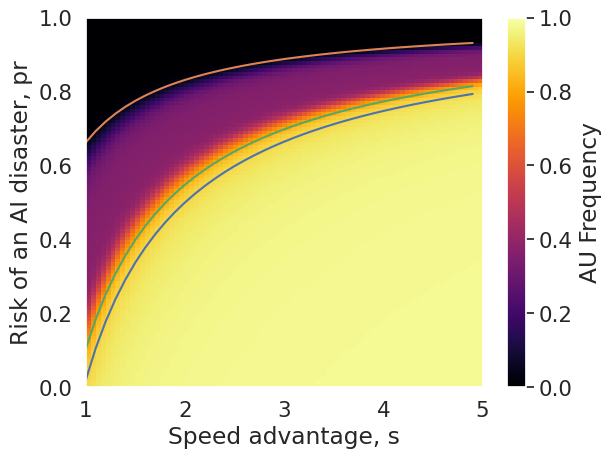

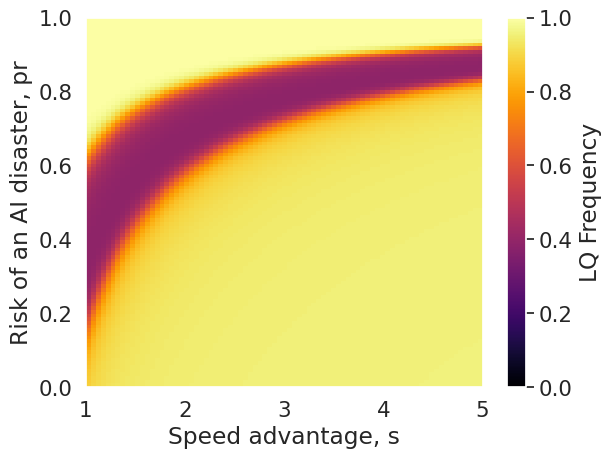

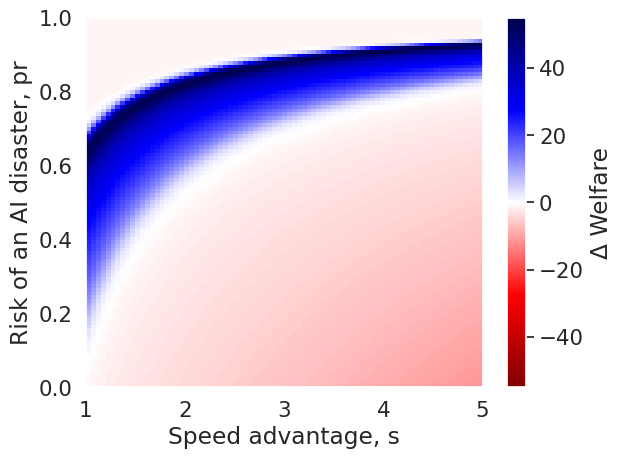

In [106]:
for v in df[var].unique():
    plot_data = df[df[var] == v]
    plot_useful_figs1a(plot_data)
    plot_useful_figs2a(plot_data)
    print({"new_welfare": plot_data["game_welfare"].mean(),
            "old_welfare": df_baseline[df_baseline[var] == v]["game_welfare"].mean()})

### Set 12

In [102]:
models = {**models,
          **build_reg_market(pfo_h=0.6,
                             g=1.8,
                             incentive_mix=[0, 1],
                             s=np.arange(1,5.05,0.05),
                             p=np.arange(0,1.01,0.01),
                             phi_h = np.array([0.5]),
                             phi2_h = np.array([0.5]),
                             collective_risk=np.array([0]),
                             β = 1/50, #[1/500, 1/50, 1/5],
                            #  pfo_l=np.arange(0, 0.7, 0.1),
                            #  B=[10**3, 10**4, 10**5],
                            # r_h=np.arange(-2,0.5, 0.5),
                            # λ=[0, 1, 5, 10],
                             )
          }
models['Z'] = {"S1": 50, "S2": 50}
models['β1'] = models['β']
models['β'] = {"S1": models['β'], "S2": models['β']*100}
# Optionally, we can choose to scale the regulator's impact by the speed advantage.
models['phi_h'] = models['phi_h']  / models['s']
models['phi2_h'] = models['phi2_h'] / models['s']
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s': (16362,),
 'p': (16362,),
 'phi_h': (16362,),
 'phi2_h': (16362,),
 'collective_risk': (16362,),
 'b': (16362,),
 'c': (16362,),
 'B': (16362,),
 'W': (16362,),
 'pfo_l': (16362,),
 'pfo_h': (16362,),
 'λ': (16362,),
 'r_l': (16362,),
 'r_h': (16362,),
 'g': (16362,),
 'externality': (16362,),
 'decisiveness': (16362,),
 'incentive_mix': (16362,),
 'β1': (16362,)}

In [103]:
results = thread_macro({**models, "sd-method": "quantecon"},
                       risk_dominance,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       calculate_sd_helper,
                       compute_game_welfare
                       )

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)


/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

In [104]:
models_baseline = copy.deepcopy(models)
models_baseline['g'] = models_baseline['g'] * 0
models_baseline['pfo_h'] = models_baseline['pfo_h'] * 0
models_baseline['phi_h'] = models_baseline['phi_h'] * 0
models_baseline['phi2_h'] = models_baseline['phi2_h'] * 0
results_baseline = thread_macro({**models_baseline, "sd-method": "quantecon"},
                                risk_dominance,
                                payoffs_sr_pfo_extension,
                                threshold_risk_dominant_safety_dsair,
                                threshold_society_prefers_safety_dsair,
                                create_profiles,
                                apply_profile_filters,
                                build_payoffs,
                                build_transition_matrix,
                                calculate_sd_helper,
                                compute_game_welfare,
                                )
df_baseline = thread_macro(results_baseline,
                  results_to_dataframe_egt,
                  process_dsair_data)

df = thread_macro(df,
                  compute_frequencies,
                  (compute_welfare_change, df_baseline),)
df['weighted_welfare_change'] = df.welfare_change

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:418: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:421: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:68: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:71: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning: invalid value encountered in divide
  (-b + (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning: divide by zero encountered in divide
  (-b - (b**2 - 4*a*c)**0.5)/(2*a))
/mnt/d/Paolo-Work/git/g

In [105]:
default_idx = df[(df.s==1.5)
                 & (df.p==0.4)
                 & (df.incentive_mix==0)].index[0]
np.round(results['ergodic'][default_idx], decimals=4)

array([0.01 , 0.043, 0.01 , 0.021, 0.121, 0.794])

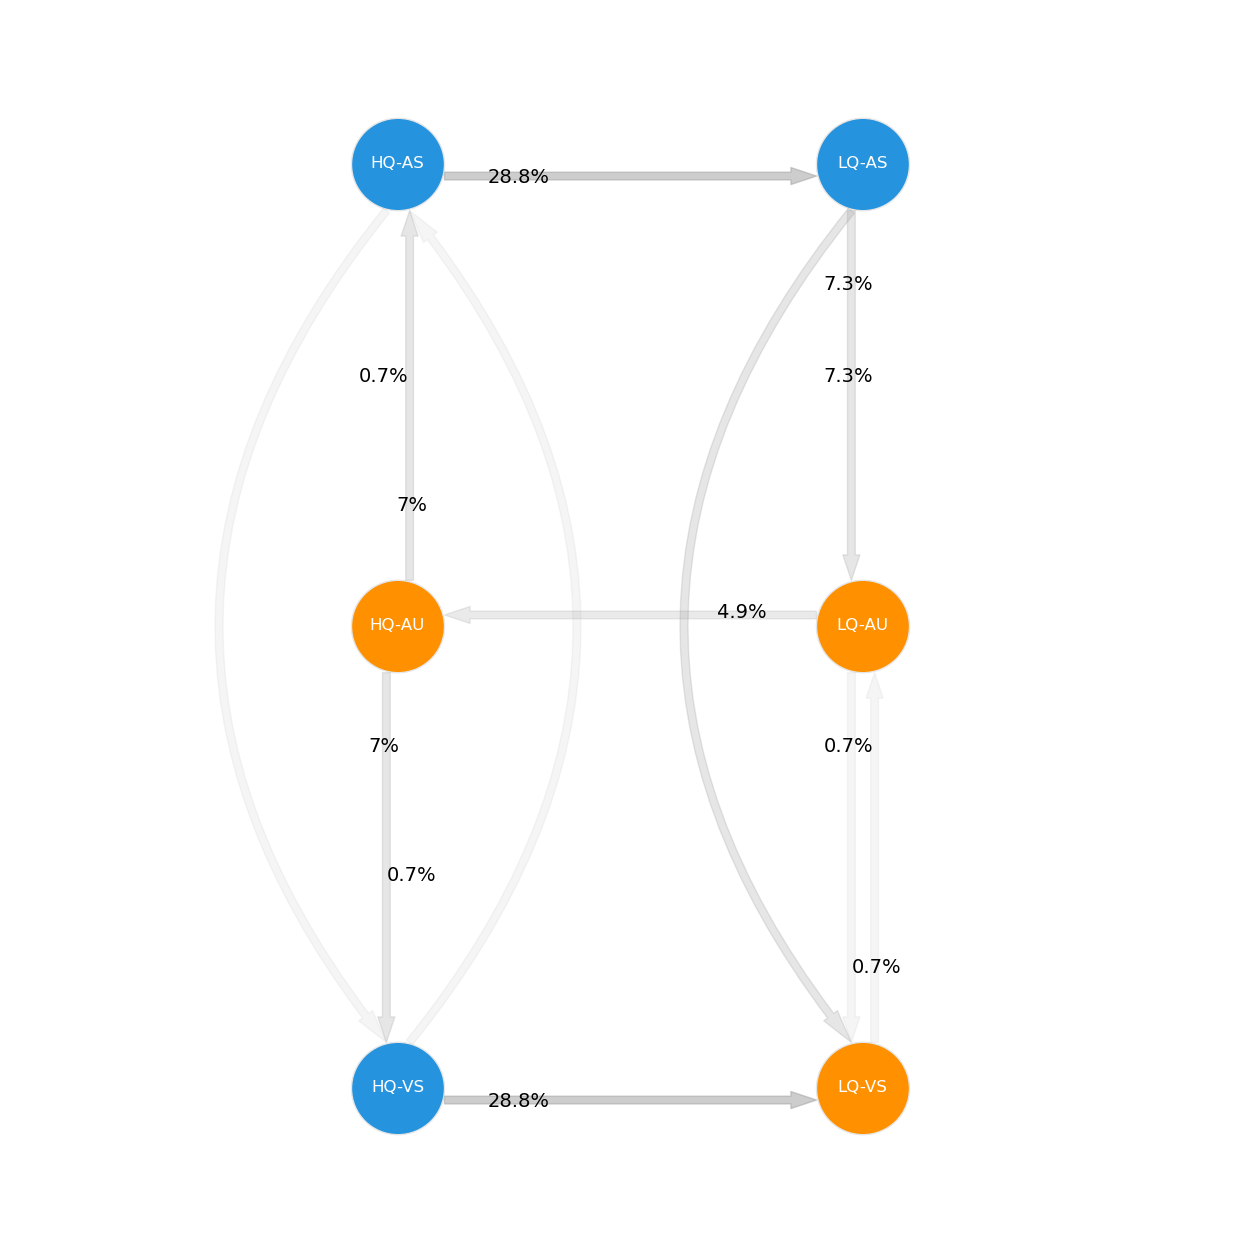

In [106]:
P = np.round(results['transition_matrix'][default_idx], decimals=4)
mc = MarkovChain(P,
                 ['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS'],
                 percentages=True,
                 self_arrows=False,
                #  annotate=False,
                 n_columns=2,
                 node_facecolor= ["#2693de", "#ff9000", "#2693de",
                                  "#2693de", "#ff9000", "#ff9000"],
                 transparency_func=lambda p:max(p**0.5, 0.1))
mc.draw()

In [107]:
default_idx = df[(df.s==1.5)
                 & (df.p==0.4)
                 & (df.incentive_mix==1)].index[0]
np.round(results['ergodic'][default_idx], decimals=4)

array([0.014, 0.   , 0.623, 0.028, 0.32 , 0.015])

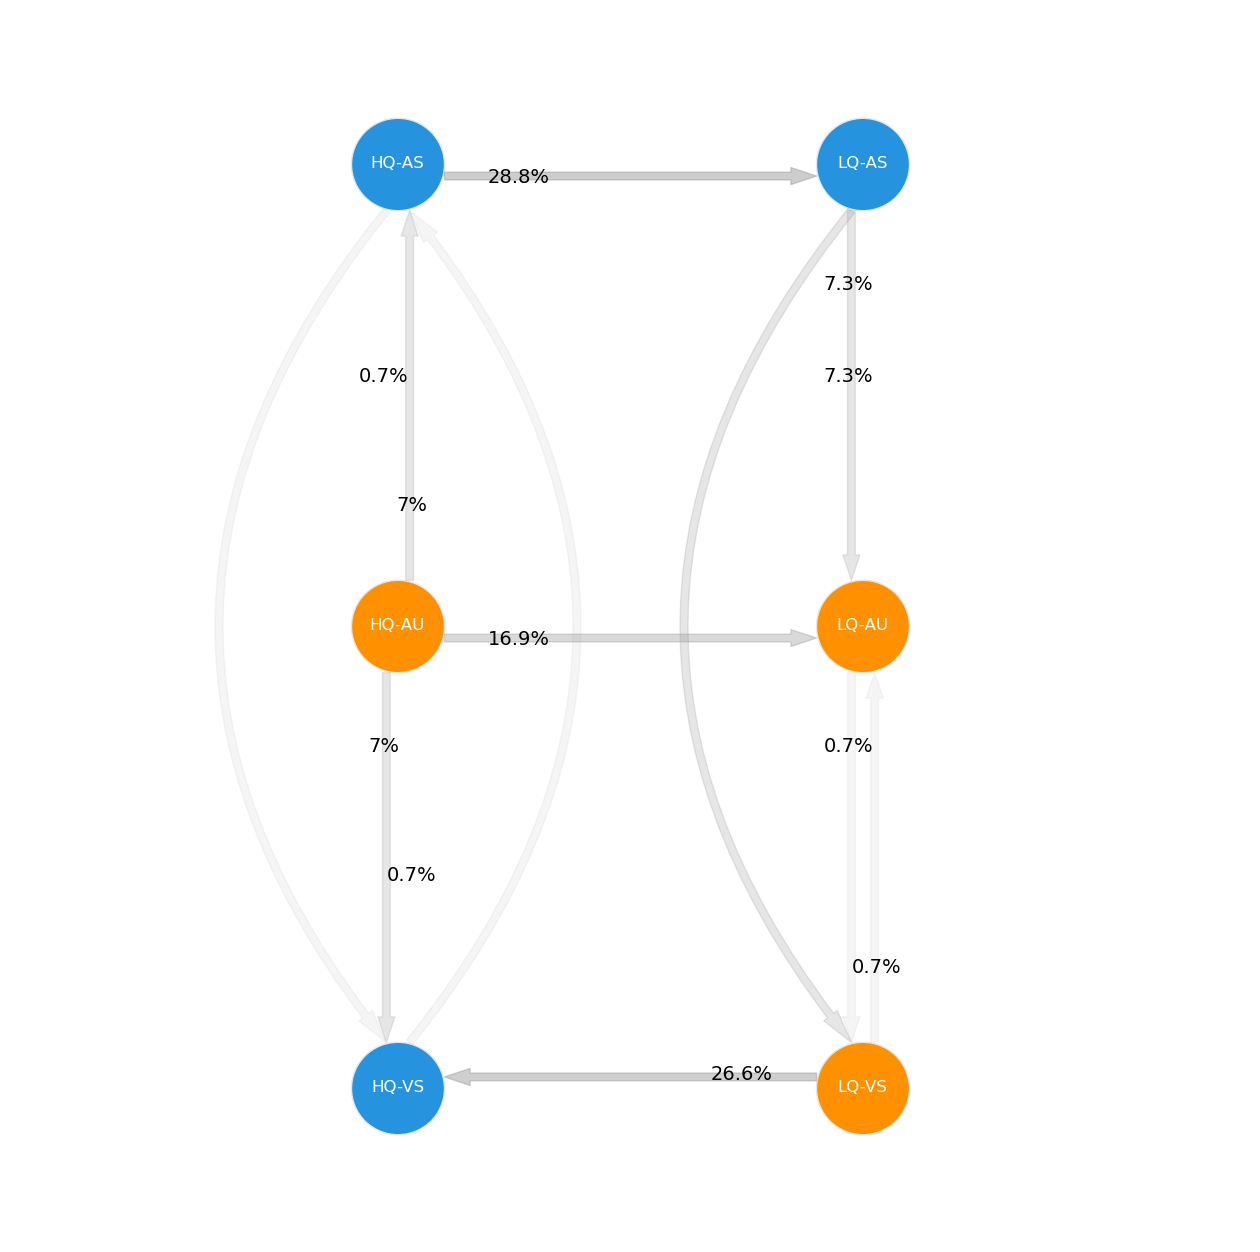

In [108]:
P = np.round(results['transition_matrix'][default_idx], decimals=4)
mc = MarkovChain(P,
                 ['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS'],
                 percentages=True,
                 self_arrows=False,
                #  annotate=False,
                 n_columns=2,
                 node_facecolor= ["#2693de", "#ff9000", "#2693de",
                                  "#2693de", "#ff9000", "#ff9000"],
                 transparency_func=lambda p:max(p**0.5, 0.1))
mc.draw()

{'new_welfare': 128.09190233664407, 'old_welfare': 163.44309122359383}


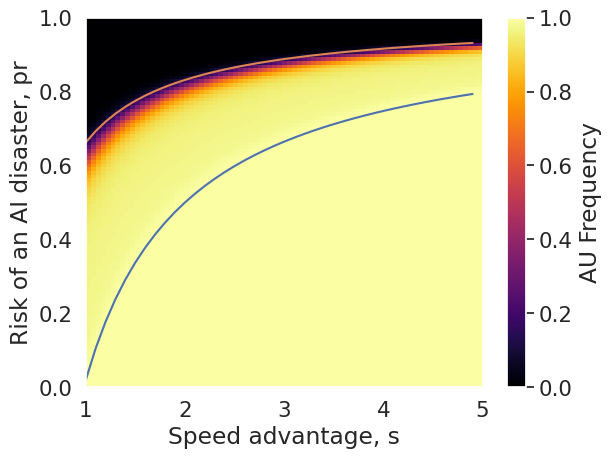

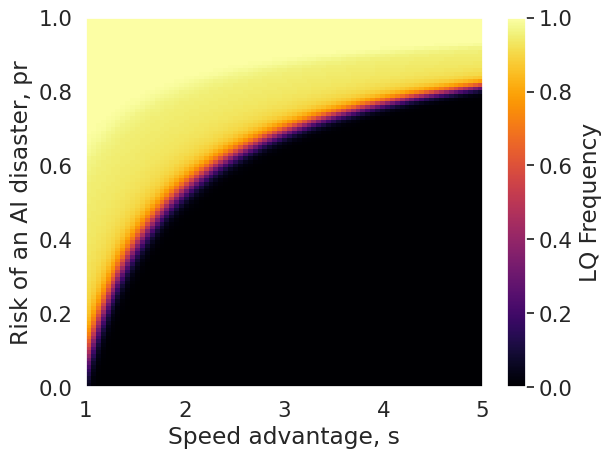

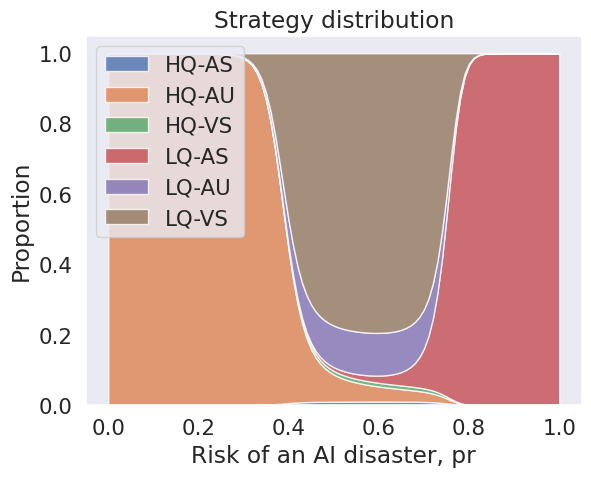

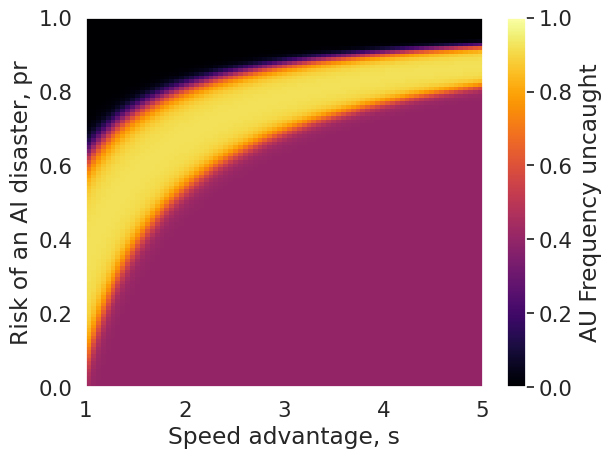

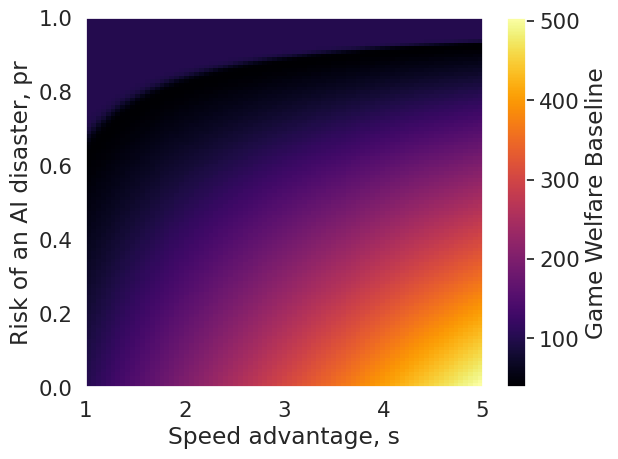

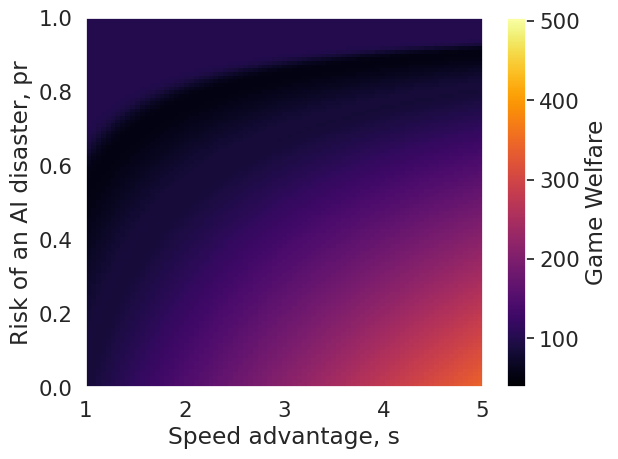

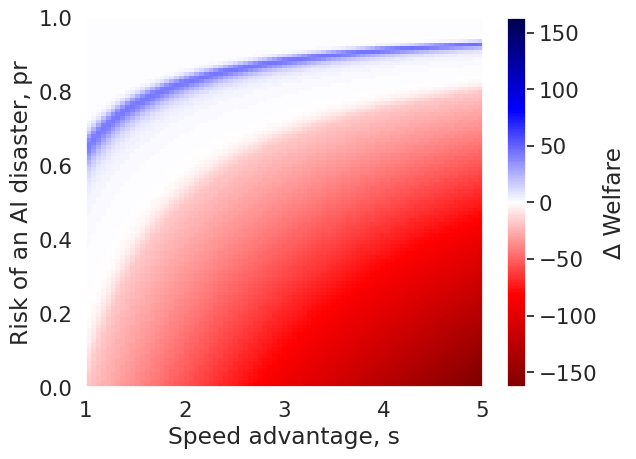

In [109]:
plot_data = df[df.incentive_mix==0]
plot_useful_figs1(plot_data,
                    results['strategy_set'])
plot_useful_figs2(plot_data)
print({"new_welfare": plot_data["game_welfare"].mean(),
        "old_welfare": df_baseline["game_welfare"].mean()})

{'new_welfare': 166.3881177303548, 'old_welfare': 163.44309122359383}


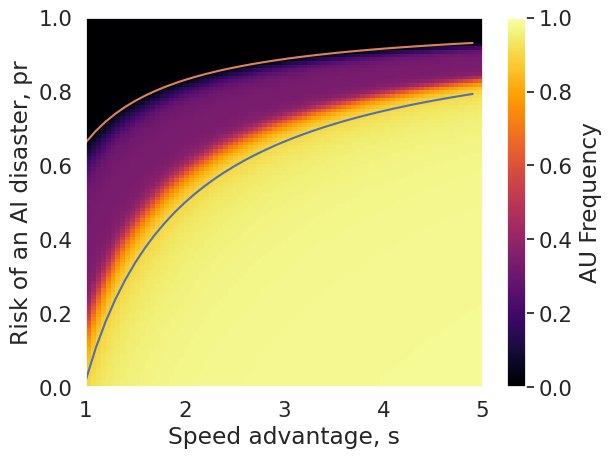

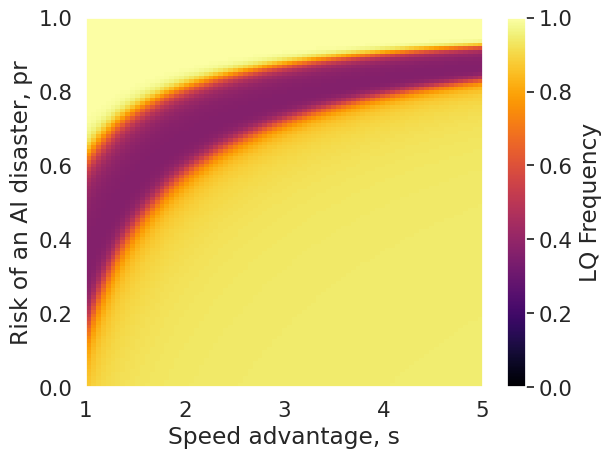

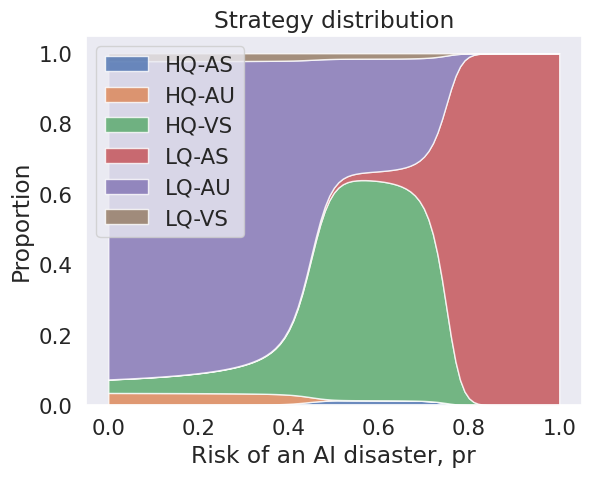

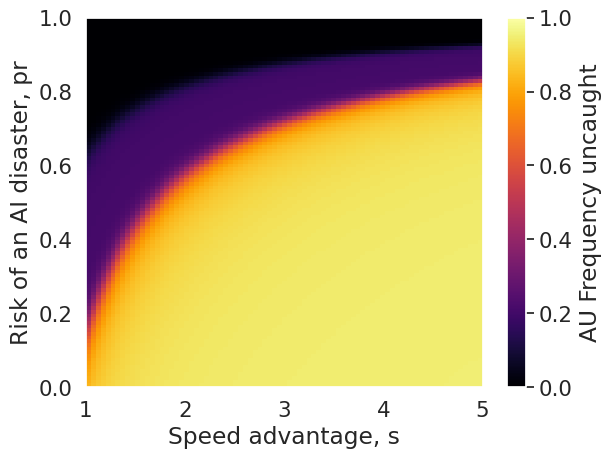

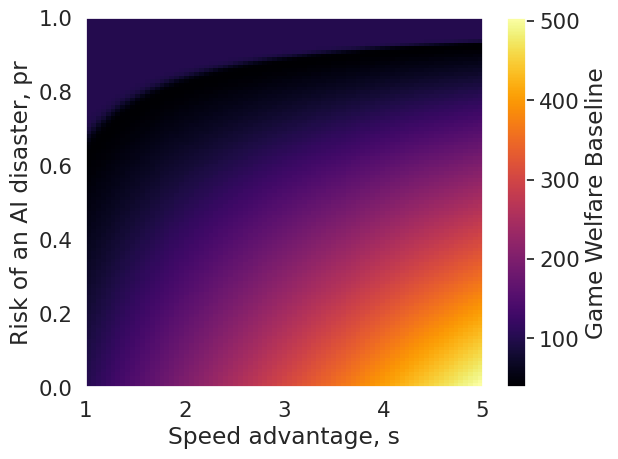

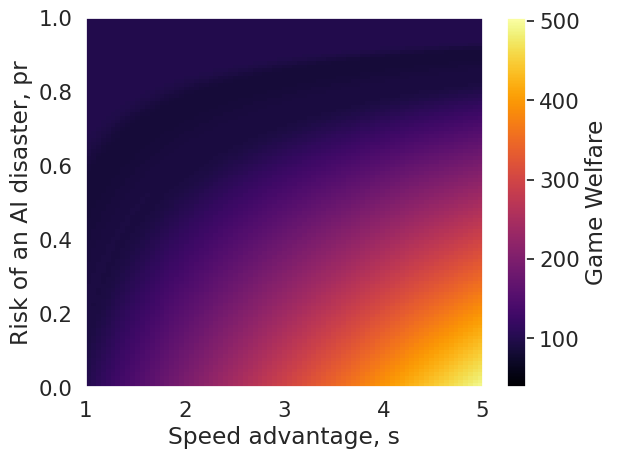

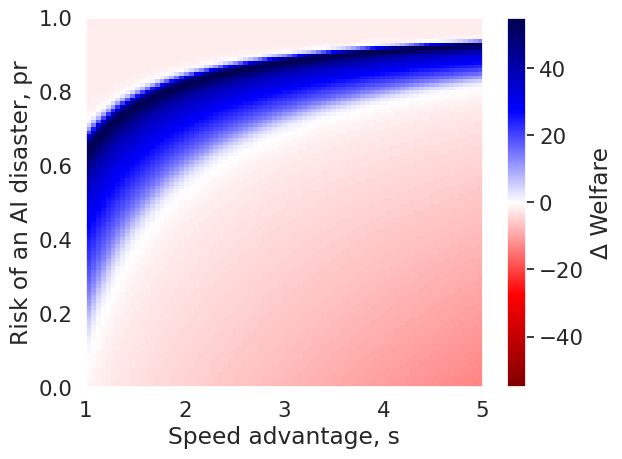

In [110]:
plot_data = df[df.incentive_mix==1]
plot_useful_figs1(plot_data,
                    results['strategy_set'])
plot_useful_figs2(plot_data)
print({"new_welfare": plot_data["game_welfare"].mean(),
        "old_welfare": df_baseline["game_welfare"].mean()})

### Extra notes

Remember that we can only assert that the speed advantage is great. To provide evidence that this is the case, we need to monitor AI developments to know what exactly is being skipped and what the expected benefits and risks will be.

Use interpolation to allow resampling and create the same figure as above as we vary the priors.

It would be nice if we can say that a strong prior of future risk is needed to make a regulatory market viable. This is because the dilemma zone is fairly small. 

It is worthile noting how using classical game theory alone is inappropriate for the assessment of regulatory markets. Classical game theory via solution methods such as Subgame Perfect Nash Equilibria would suggest well-designed Regulatory markets could perfectly discriminate between scenarios where HQ regulation is needed and where LQ regulation would suffice. This is unrealistic given both the Collinridge Dillema and the process of learning that firms and regulators must undergo when exploring the space of possible strategies.

We model close competition between two AI companies. This may not be the most likely scenario for certain important markets for AI, which may be dominated by a particular company, and otherwise have high barriers to entry. We do not model such scenarios, mainly because a simple extension would not be very insightful. As has been documented elsewhere, unless there is a threat to their position in the race, leaders have less incentive to skip on safety precautions (though some models suggest that the riskiest races have additional firms not too far behind the leader). If externalities demand that these leaders be regulated anyways, then the model here would suggest that this task would be easier than in an equivalent close competition (where the incentives to be unsafe are larger). Of course, this model ignores the possibilities of corruption and collusion, which may be larger problems when AI companies are more powerful and the speed advantage from skipping safety precautions is great. 

## Regulatory Market model

### Create parameter space

In [ ]:
show_doc(build_reg_market)

---

[source](https://github.com/PaoloBova/gh-pages-example/blob/main/gh_pages_example/models.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### build_reg_market

>      build_reg_market (b:Union[float,list[float],numpy.ndarray,dict]=4,
>                        c:Union[float,list[float],numpy.ndarray,dict]=1,
>                        s:Union[float,list[float],numpy.ndarray,dict]={'start':
>                        1, 'stop': 5.1, 'step': 0.1},
>                        p:Union[float,list[float],numpy.ndarray,dict]={'start':
>                        0, 'stop': 1.02, 'step': 0.02},
>                        B:Union[float,list[float],numpy.ndarray,dict]=10000,
>                        W:Union[float,list[float],numpy.ndarray,dict]=100,
>                        pfo_l:Union[float,list[float],numpy.ndarray,dict]=0,
>                        pfo_h:Union[float,list[float],numpy.ndarray,dict]=0.5,
>                        λ:Union[float,list[float],numpy.ndarray,dict]=0,
>                        r_l:Union[float,list[float],numpy.ndarray,dict]=0,
>                        r_h:Union[float,list[float],numpy.ndarray,dict]=-1,
>                        g:Union[float,list[float],numpy.ndarray,dict]=1,
>                        phi_h:Union[float,list[float],numpy.ndarray,dict]=0,
>                        phi2_h:Union[float,list[float],numpy.ndarray,dict]=0, e
>                        xternality:Union[float,list[float],numpy.ndarray,dict]=
>                        0, decisiveness:Union[float,list[float],numpy.ndarray,d
>                        ict]=1, incentive_mix:Union[float,list[float],numpy.nda
>                        rray,dict]=1, collective_risk:Union[float,list[float],n
>                        umpy.ndarray,dict]=0,
>                        β:Union[float,list[float],numpy.ndarray,dict]=1,
>                        Z:dict={'S1': 50, 'S2': 50},
>                        strategy_set:list[str]=['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-
>                        AS', 'LQ-AU', 'LQ-VS'], exclude_args:list[str]=['Z',
>                        'strategy_set'], override:bool=False,
>                        drop_args:list[str]=['override', 'exclude_args',
>                        'drop_args'])

Initialise Regulatory Market models for all combinations of the provided
parameter valules.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| b | Union | 4 | benefit: The size of the per round benefit of leading the AI development race, b>0 |
| c | Union | 1 | cost: The cost of implementing safety recommendations per round, c>0 |
| s | Union | {'start': 1, 'stop': 5.1, 'step': 0.1} | speed: The speed advantage from choosing to ignore safety recommendations, s>1 |
| p | Union | {'start': 0, 'stop': 1.02, 'step': 0.02} | avoid_risk: The probability that unsafe firms avoid an AI disaster, p ∈ [0, 1] |
| B | Union | 10000 | prize: The size of the prize from winning the AI development race, B>>b |
| W | Union | 100 | timeline: The anticipated timeline until the development race has a winner if everyone behaves safely, W ∈ [10, 10**6] |
| pfo_l | Union | 0 | detection_risk_lq: The probability that firms who ignore safety precautions are found out by high quality regulators, pfo_h ∈ [0, 1] |
| pfo_h | Union | 0.5 | detection_risk_hq: The probability that firms who ignore safety precautions are found out by low quality regulators, pfo_h ∈ [0, 1] |
| λ | Union | 0 | disaster_penalty: The penalty levied to regulators in case of a disaster |
| r_l | Union | 0 | profit_lq: profits for low quality regulators before including government incentives, r_l ∈ R |
| r_h | Union | -1 | profit_hq: profits for high quality regulators before including government incentives, r_h ∈ R |
| g | Union | 1 | government budget allocated to regulators per firm regulated, g > 0 |
| phi_h | Union | 0 | regulator_impact: how much do regulators punish unsafe firms they detect, by default detected firms always lose the race. |
| phi2_h | Union | 0 | regulator_impact: how much do regulators punish 2 unsafe firms they detect, by default detected firms always lose the race. |
| externality | Union | 0 | externality: damage caused to society when an AI disaster occurs |
| decisiveness | Union | 1 | How decisive the race is after a regulator gets involved |
| incentive_mix | Union | 1 | Composition of incentives, by default government always pays regulator but rescinds payment if unsafe company discovered |
| collective_risk | Union | 0 | The likelihood that a disaster affects all actors |
| β | Union | 1 | learning_rate: the rate at which players imitate each other |
| Z | dict | {'S1': 50, 'S2': 50} | population_size: the number of firms and regulators |
| strategy_set | list | ['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS'] |  |
| exclude_args | list | ['Z', 'strategy_set'] | a list of arguments that should be returned as they are |
| override | bool | False | whether to build the grid if it is very large |
| drop_args | list | ['override', 'exclude_args', 'drop_args'] | a list of arguments to drop from the final result |
| **Returns** | **dict** |  | **A dictionary containing items from `ModelTypeRegMarket` and `ModelTypeEGT`** |

In [ ]:
#| exec_doc
#| echo:true
models = build_reg_market()

In [ ]:
#| hide
models

{'s': array([1., 1., 1., ..., 5., 5., 5.]),
 'p': array([0.  , 0.02, 0.04, ..., 0.96, 0.98, 1.  ]),
 'b': array([4, 4, 4, ..., 4, 4, 4]),
 'c': array([1, 1, 1, ..., 1, 1, 1]),
 'B': array([10000, 10000, 10000, ..., 10000, 10000, 10000]),
 'W': array([100, 100, 100, ..., 100, 100, 100]),
 'pfo_l': array([0, 0, 0, ..., 0, 0, 0]),
 'pfo_h': array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]),
 'λ': array([0, 0, 0, ..., 0, 0, 0]),
 'r_l': array([0, 0, 0, ..., 0, 0, 0]),
 'r_h': array([-1, -1, -1, ..., -1, -1, -1]),
 'g': array([1, 1, 1, ..., 1, 1, 1]),
 'collective_risk': array([0, 0, 0, ..., 0, 0, 0]),
 'β': array([1, 1, 1, ..., 1, 1, 1]),
 'Z': {'S1': 50, 'S2': 50},
 'strategy_set': ['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS']}

In [ ]:
#| hide
{k:v.shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s': (2091,),
 'p': (2091,),
 'b': (2091,),
 'c': (2091,),
 'B': (2091,),
 'W': (2091,),
 'pfo_l': (2091,),
 'pfo_h': (2091,),
 'λ': (2091,),
 'r_l': (2091,),
 'r_h': (2091,),
 'g': (2091,),
 'collective_risk': (2091,),
 'β': (2091,)}

### Run the model

I use `thread_macro` to pipe the `models` I created earlier through each function that follows.

I first build the payoff matrices for each model, and compute some analytical thresholds that will be useful in our discussion. Finally, I pass the result to `markov_chain`, a method for computing the distribution of strategies that will be present in the population in the long run.

In [ ]:
# | export
Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3],}
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"],}
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1_reward_after",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

results = thread_macro(models,
                      create_profiles,
                      apply_profile_filters,
                      build_payoffs,
                      build_transition_matrix,
                      find_ergodic_distribution,
                      )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


In [ ]:
list(results.keys())

['s',
 'p',
 'b',
 'c',
 'B',
 'W',
 'pfo_l',
 'pfo_h',
 'λ',
 'r_l',
 'r_h',
 'g',
 'collective_risk',
 'β',
 'Z',
 'strategy_set',
 'dispatch-type',
 'payoffs_key',
 'allowed_sectors',
 'sector_strategies',
 'profiles',
 'profile_filter_rule',
 'profiles_filtered',
 'payoffs',
 'transition_matrix',
 'recurrent_states',
 'n_models',
 'ergodic']

In [ ]:
#| hide
{k:v.shape for k,v in results.items() if isinstance(v, np.ndarray)}

{'s': (2091,),
 'p': (2091,),
 'b': (2091,),
 'c': (2091,),
 'B': (2091,),
 'W': (2091,),
 'pfo_l': (2091,),
 'pfo_h': (2091,),
 'λ': (2091,),
 'r_l': (2091,),
 'r_h': (2091,),
 'g': (2091,),
 'collective_risk': (2091,),
 'transition_matrix': (2091, 6, 6),
 'ergodic': (2091, 6)}

### Process the results

Now that we have collected some results, we need to process them so that we can display what we want to.

The general approach I follow is to flatten the `results` dictionary and convert it into a [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) dataframe. I have a convenience function called `results_to_dataframe_egt` for this purpose.

In `process_dsair_data`, we also compute the risk of an AI related disaster, $p_{risk} = 1 - p$

In [ ]:
results['recurrent_states']

['4-1', '4-2', '4-3', '5-1', '5-2', '5-3']

In [ ]:
#| exec_doc
df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])

In [ ]:
#| echo:false
df

s     p  b  c      B    W  pfo_l  pfo_h  λ  r_l  ...  collective_risk  \
0     1.0  0.00  4  1  10000  100      0    0.5  0    0  ...                0   
1     1.0  0.02  4  1  10000  100      0    0.5  0    0  ...                0   
2     1.0  0.04  4  1  10000  100      0    0.5  0    0  ...                0   
3     1.0  0.06  4  1  10000  100      0    0.5  0    0  ...                0   
4     1.0  0.08  4  1  10000  100      0    0.5  0    0  ...                0   
...   ...   ... .. ..    ...  ...    ...    ... ..  ...  ...              ...   
2086  5.0  0.92  4  1  10000  100      0    0.5  0    0  ...                0   
2087  5.0  0.94  4  1  10000  100      0    0.5  0    0  ...                0   
2088  5.0  0.96  4  1  10000  100      0    0.5  0    0  ...                0   
2089  5.0  0.98  4  1  10000  100      0    0.5  0    0  ...                0   
2090  5.0  1.00  4  1  10000  100      0    0.5  0    0  ...                0   

      HQ-AS_frequency  HQ-AU_frequency  HQ-VS_frequency  LQ-AS_frequency  \
0        1.032874e-15     2.355413e-16     2.970101e-16     1.000000e+00   
1        2.195226e-16     2.400893e-16     3.622137e-16     1.000000e+00   
2        6.490571e-15     2.392133e-16     5.466525e-16     1.000000e+00   
3        1.577203e-15     4.881819e-16     3.849126e-16     1.000000e+00   
4        3.454447e-15     6.758701e-16     9.387085e-18     1.000000e+00   
...               ...              ...              ...              ...   
2086     5.669585e-16     3.333333e-01     2.721401e-16     1.814267e-16   
2087     5.669585e-16     3.333333e-01     2.721401e-16     1.814267e-16   
2088     5.669585e-16     3.333333e-01     2.721401e-16     1.814267e-16   
2089     5.669585e-16     3.333333e-01     2.721401e-16     1.814267e-16   
2090     5.669585e-16     3.333333e-01     2.721401e-16     1.814267e-16   

      LQ-AU_frequency  LQ-VS_frequency    pr  AU_frequency  LQ_frequency  
0        7.587295e-18     2.570075e-16  1.00  5.001361e-16      1.000000  
1        2.881991e-17     5.015857e-16  0.98  7.704949e-16      1.000000  
2        5.188928e-16     6.172721e-15  0.96  6.930827e-15      1.000000  
3        1.431687e-15     3.421028e-14  0.94  3.613015e-14      1.000000  
4        8.644566e-14     7.708674e-14  0.92  1.642083e-13      1.000000  
...               ...              ...   ...           ...           ...  
2086     3.333333e-01     3.333333e-01  0.08  1.000000e+00      0.666667  
2087     3.333333e-01     3.333333e-01  0.06  1.000000e+00      0.666667  
2088     3.333333e-01     3.333333e-01  0.04  1.000000e+00      0.666667  
2089     3.333333e-01     3.333333e-01  0.02  1.000000e+00      0.666667  
2090     3.333333e-01     3.333333e-01  0.00  1.000000e+00      0.666667  

[2091 rows x 22 columns]

### Visualise results and explain what we observe

I am using the [Matplotlib](https://matplotlib.org/stable/index.html) library to visualize our data.

#| hide

:::{.callout-note}
Note that there are five types of callouts, including: 
`note`, `tip`, `warning`, `caution`, and `important`.
:::

In [ ]:
#| hide
sns.set_theme(style='darkgrid',palette='deep' ,font='sans-serif', font_scale=1.4)
plt.rcParams["axes.grid"] = False

### Some basic results

I first replicate Figure 1 from The Anh Han et al. 2021

The figure describes how the the frequency of Always Unsafe (**AU**) varies with both the speed advantage given to those who play **AU**, $s$, and the risk that such firms cause an AI disaster, $p_{risk}$. We have also plotted two lines, the lower line shows the boundary where society is indifferent between the two strategies. A greater risk or a slower speed advantage from this boundary implies society prefers players to play Always Safe (**AS**). The higher line shows the threshold for which **AU** is risk dominant over **AS**. For this baseline model, risk dominance implies that the strategy will be selected for by evolution (which is why the line follows the boundary where players switch from **AU** to **AS**). As with the lower line, any higher risk or lower speed implies that **AS** will instead by risk dominant over **AU**.

These lines therefore split the heatmap into 3 regions. 
(i) Society prefers **AS** and **AS** is selected by social learning.
(ii) Society prefers **AS** but **AU** is selected by social learning
(iii) Society prefers **AU** and **AU** is selected by social learning

In region (i) companies will be alligned with Society's preference for safety. In region (iii), society is willing to accept the risks as they anticipate greater benefits from innovation. In region (ii), we see a dilemma where all players are choosing to play **AU**, even though society prefers them to play **AS**. We can refer to this region as the *Dilemma zone*.

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: xlabel='Speed avantage, s', ylabel='Risk of an AI disaster, pr'>)

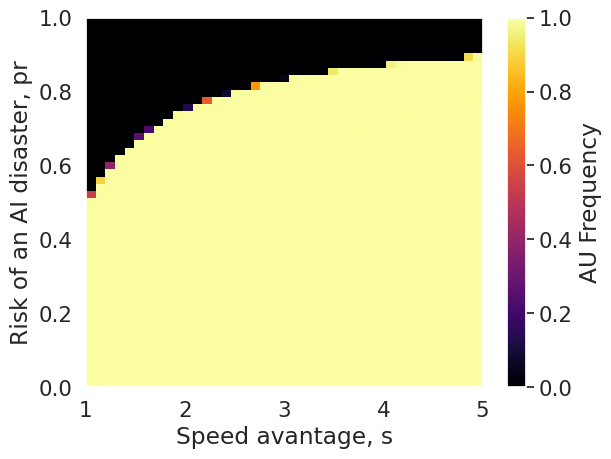

In [ ]:
#| echo:false
table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: xlabel='Speed avantage, s', ylabel='Risk of an AI disaster, pr'>)

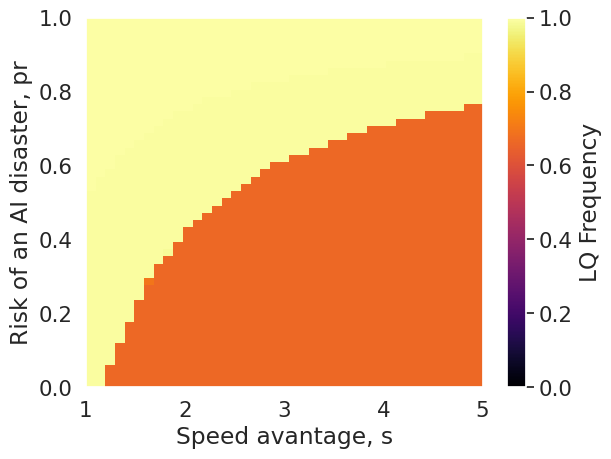

In [ ]:
#| echo:false
table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
            )

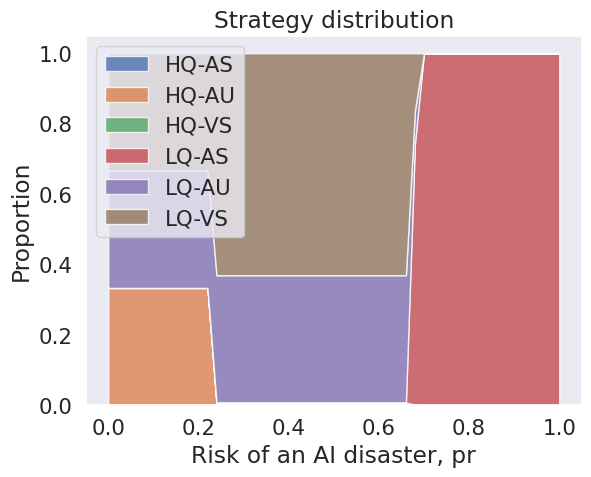

In [ ]:
#| echo:false
plot_strategy_distribution(df[df.s==1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                          )

The model above shows that in a plausible scenario where the government only rewards regulators for catching unsafe firms, the regulatory market will fail to produce high quality regulators and shrink the dilemma zone where firms are unsafe despite high risks of an AI disaster.

In the default scenario presented above, low quality regulators do not care what companies do as they have no chance of catching unsafe firms and face no penalty from the authorities should they preside over unsafe firms. They are never rewarded as they cannot catch unsafe firms and on net they do not receive any profits from providing their service. It is reasonable to interpret this type as choosing not to regulate at all. 

In contrast, high quality regulators (or equivalently for this scenario, those who remain in the regulatory  market) want companies to be unsafe because that is the only way they will be rewarded. However, even without looking at the incentives of firms, we know that this approach is unsustainable for this scenario, the expected reward from catching firms is no better than their outside option (of being low quality). 

The state distribution as we change the disaster risk, $pr$, illustrates how only when the risk is very low, is there even the possibility that firms would consider playing $AU$ when regulators are of a high quality. There is neutral drift between the 3 states where the firms prefer a strategy which involves being unsafe, since regulators earn the same payoff in each. Once thr risk rises, firms would not risk being unsafe if firms were of a high quality. Moreover, regulators don't won't to be high quality if there are no unsafe firms to catch, so we will spend essentially no time in the HQ-AU state. Most of that time is instead spend in LQ-VS, as the conditional strategy preforms well for firms even if they did come across a high quality regulator. For high enough risk, firms will always want to be safe, as seen in the original DSAIR model, and since regulators will only want to be of low quality, we will only see the state LQ-AU.

We next consider what happens as we modify the detection risk for high quality regulators. 

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


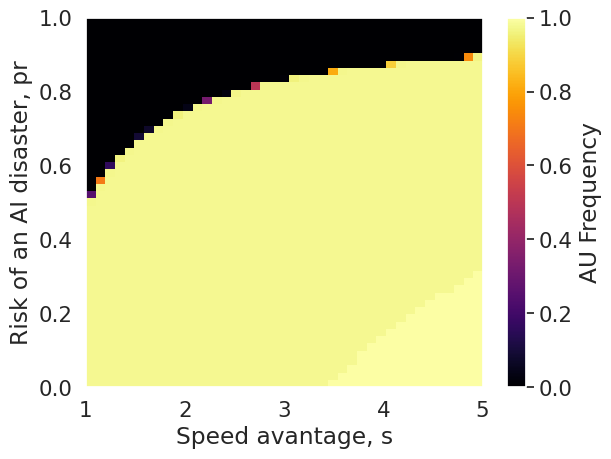

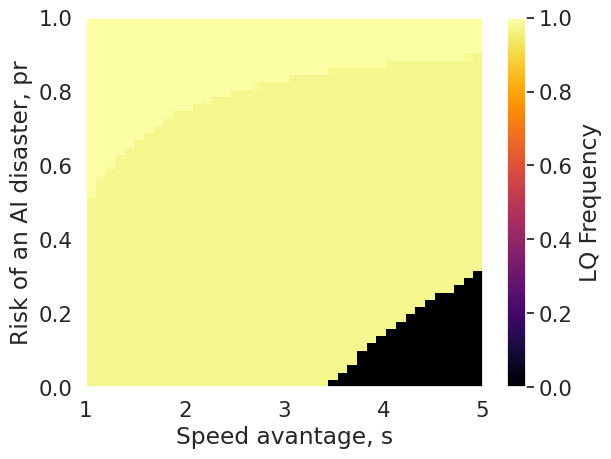

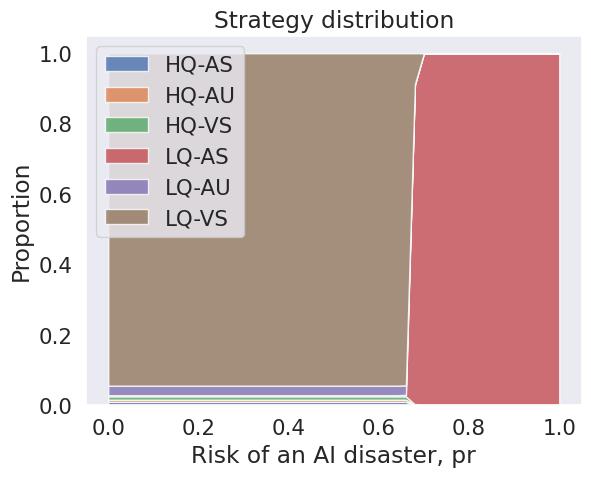

In [ ]:
# | export
Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3],}
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"],}
models = build_reg_market(pfo_h=0.8, g=1)
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1_reward_after",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

results = thread_macro(models,
                      create_profiles,
                      apply_profile_filters,
                      build_payoffs,
                      build_transition_matrix,
                      find_ergodic_distribution,
                      )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
            )

plot_strategy_distribution(df[df.s==1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                          )

Increasing the high quality detection risk means that if will be more profitable for regulators to be high quality, as long as companies will be unsafe. However, as companies can choose to be safe conditional on seeing that regulators will be of high quality, we end up mostly being in the states LQ-VS (when risks aren't too high) and LQ-AS (when the risks are high enough that companies always wish to be safe). 

Only when firms really want to be unsafe (which requires not just that the risks are low, but also that the speed advantage is great) will regulators be able to benefit from catching unsafe firms. It should be noted that unsafe behviour is not deterred by these high quality regulators, and since the firms which are caught only pose a low level of risk, the funding of these regulators is likely to be huge misallocation of resources.

It may be worth noting that high quality regulators perform much better when the selection rate is low (e.g. $\beta=0.01$), and so do have a mitigating effect on the dilemma zone (an effect which is not seen in the absense of regulation), without discouraging innovation when the risk is low. But it is still an expensive incentive mechanism to employ if the risk happens to be low and it would be unsettling to rely on a mechanism which is unstable where the selection rate to be higher than expected.

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


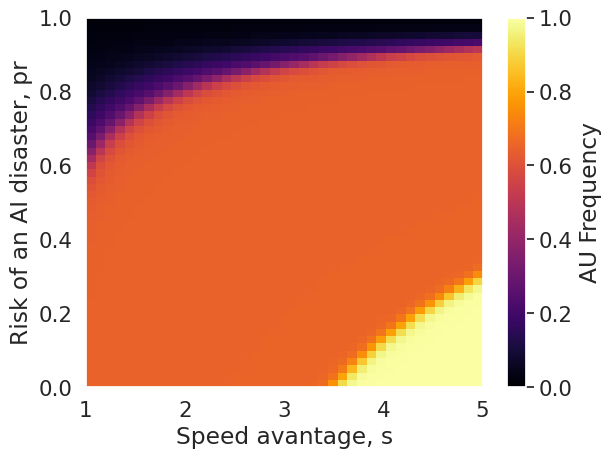

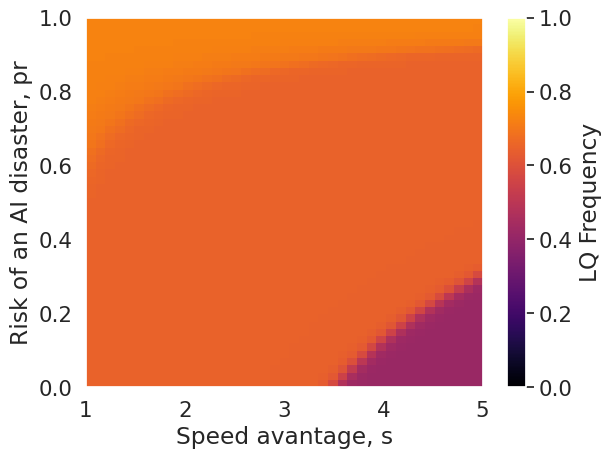

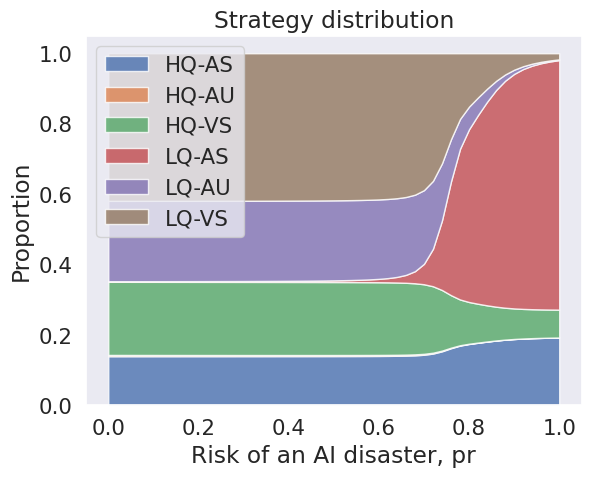

In [ ]:
# | export
Z = {"S2": 100, "S1": 100}
β = 0.01
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3],}
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"],}
models = build_reg_market(pfo_h=0.8)
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1_reward_after",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

results = thread_macro(models,
                      create_profiles,
                      apply_profile_filters,
                      build_payoffs,
                      build_transition_matrix,
                      find_ergodic_distribution,
                      )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
            )

plot_strategy_distribution(df[df.s==1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                          )

### Ex-ante vs Ex-post incentives

We now investigate the same scenario but this time reward regulators in advance, only taking away their reward if they fail to catch unsafe firms. The government is in a way viewing these regulators as providing a public service worth paying for, but follows a policy which refuses to tolerate collusive or lazy behaviour.

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


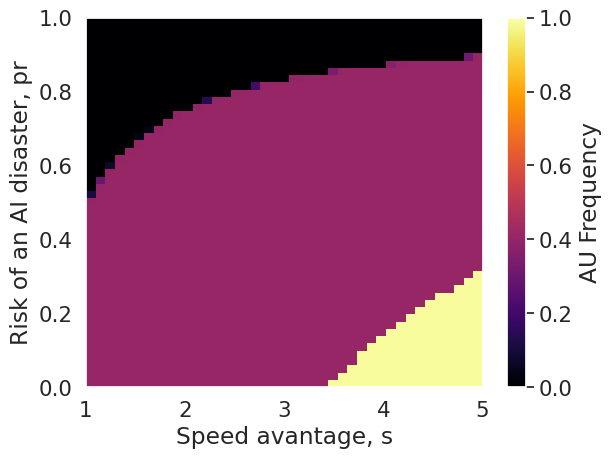

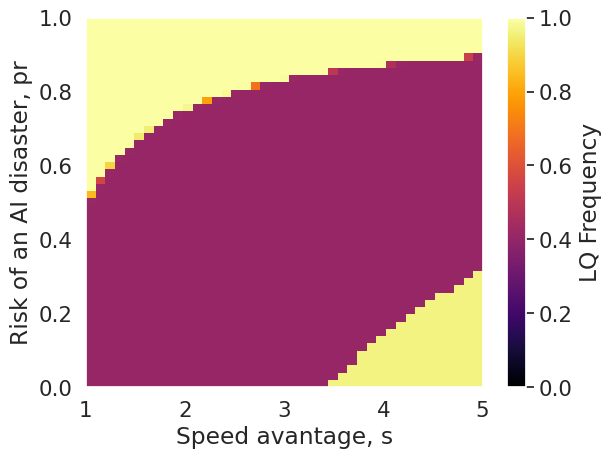

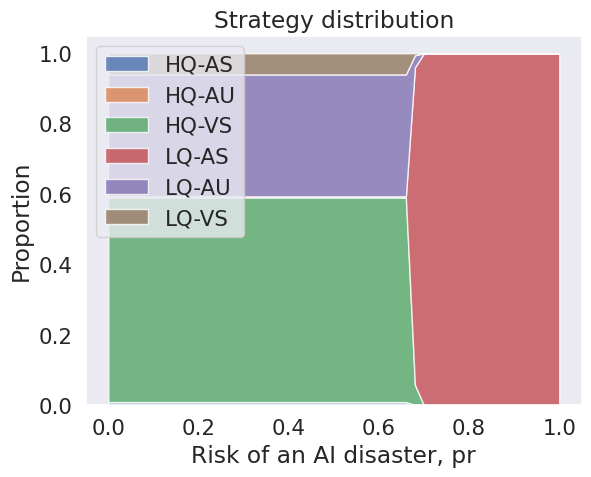

In [ ]:
# | export
Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3],}
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"],}
models = build_reg_market(pfo_h=0.8, g=1.1)
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1_reward_before",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

results = thread_macro(models,
                      create_profiles,
                      apply_profile_filters,
                      build_payoffs,
                      build_transition_matrix,
                      find_ergodic_distribution,
                      )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
            )

plot_strategy_distribution(df[df.s==1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                          )

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


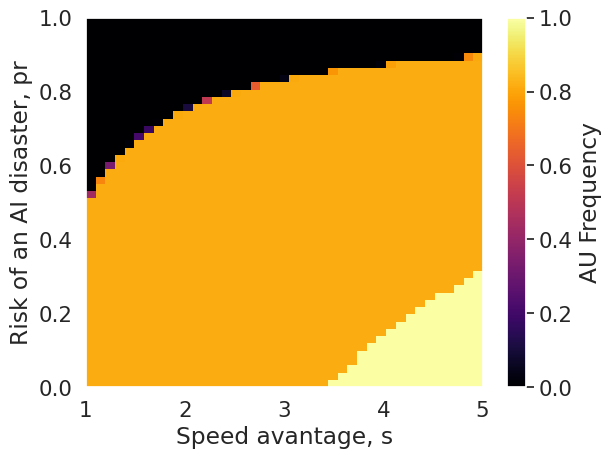

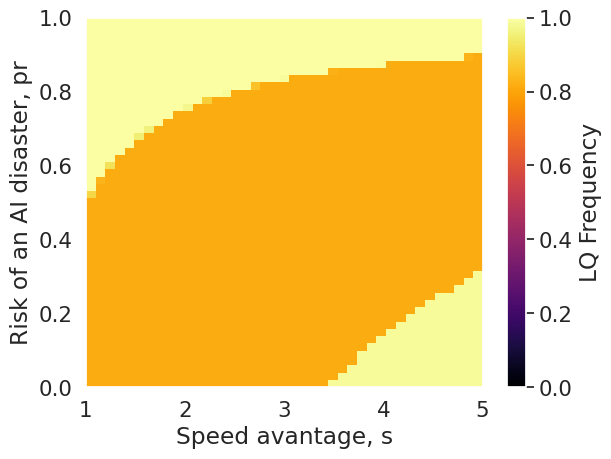

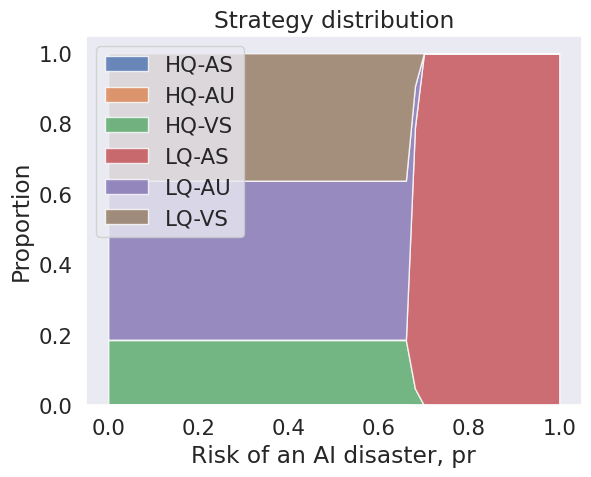

In [ ]:
# | export
Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3],}
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"],}
models = build_reg_market(pfo_h=0.8, g=1)
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1_reward_before",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

results = thread_macro(models,
                      create_profiles,
                      apply_profile_filters,
                      build_payoffs,
                      build_transition_matrix,
                      find_ergodic_distribution,
                      )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
            )

plot_strategy_distribution(df[df.s==1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                          )

The first notable result is that the level of government incentive matters greatly. Although we can mitigate the dilemma zone with a government incentive which only fills in the gap between high quality losses and their outside option, we can significantly detter unsafe behaviour in the dilemma zone with even slightly stronger incentives (e.g. $g=1.1$). This is not possible with the posterior reward sceheme since high quality regulator rarely encounter unsafe firms who could net them the stronger reward.

We can also note that the positive benefits of the regulatory market are even greater than suggested in the plots above. After all, the presence of high quality regulators means that those firms who are unsafe are far less likely to avoid detection. 

We should also highlight how this incentive is given to every regulator. Even low quality regulators (who may put no effort into checking for unsafe behaviour) receive the incentive upfront, and these incentives will onyl be partially recouped when regulators fail to catch unsafe firms, which as we have mentioned are now less common than before. With all that said, it is still a much more efficient scheme than its bounty-hunting contender. Notably, when firms have incentive to always be unsafe, most, if not all, of the incentives given to low quality regulators can be recouped.

While one could argue that when firms choose to be alway safe, we will end up paying regulators the maximum amount to do very little, this may be missing the point. It may be that only though such payments it is possible to encourage high quality regulation where it is most needed. 

There is another potential cost. If society values the risks and rewards of AI progress in a similar way as companies do, then the regulatory market under this scheme can discourage risk-taking behaviour when it would be preffered by society. 

Can we use a regulatory market to make some inferences as to what speed advantage firms expect to receive?

How might competition or a disaster penalty be used to design better incentives?

How would we know if there are better incentive schemes out there? Which assumptions is this sensitive to?

- Firms can act conditional on the choices made by regulators
- Incentives must be consistent (ruling out dynamic incentive schemes)
- Incentives must be designed under uncertainty (incentives can only condition on what the government currently knows or will observe at some stage)

An exhaustive analysis would (i) weaken the above assumptions, and (ii) consider all possible incentives given the available information (and other interventions may be able to help obtain more information over time).

Let's start by weakening the first assumption:

It is crucial that firms are able to observe the quality of regulators before commiting to their behaviour. Notice that if we remove the conditional strategy, $VS$, that the outcome will be identical to a scenario where there is no regulatory market, albeit with the possibility of shelling large, publicly funded, incentives on low quality regulators.

If we found evidence to suggest that firms are not responsive to the efforts of regulators, then it is highly likely our regulatory market is failing. 

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):


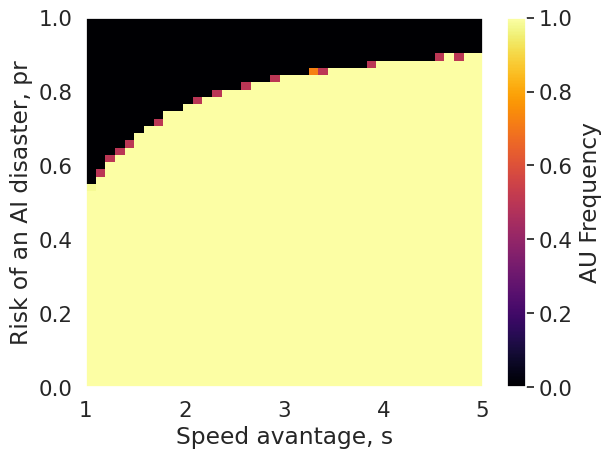

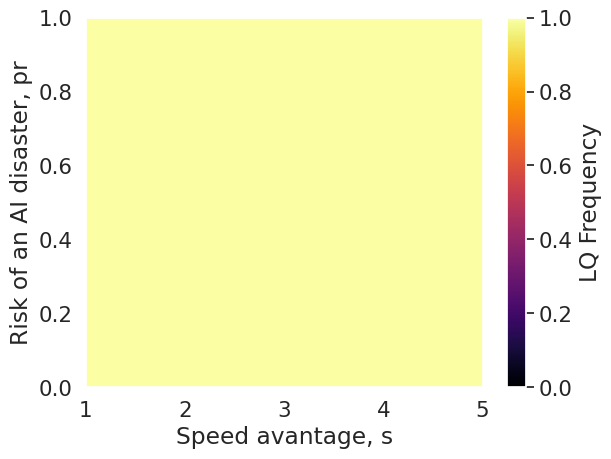

In [ ]:
# | export
Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2],}
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"],}
models = build_reg_market(pfo_h=0.8, g=1.1, strategy_set=["HQ-AS", "HQ-AU",
                                                          "LQ-AS", "LQ-AU"])
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1_reward_before",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

results = thread_macro(models,
                      create_profiles,
                      apply_profile_filters,
                      build_payoffs,
                      build_transition_matrix,
                      find_ergodic_distribution,
                      )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency'])

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
            )

plot_strategy_distribution(df[df.s==1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                          )

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


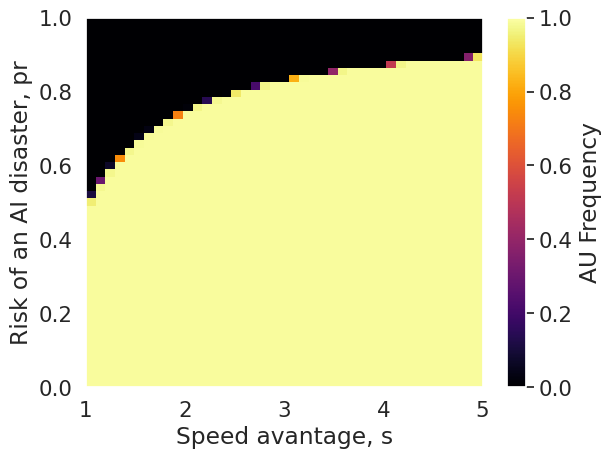

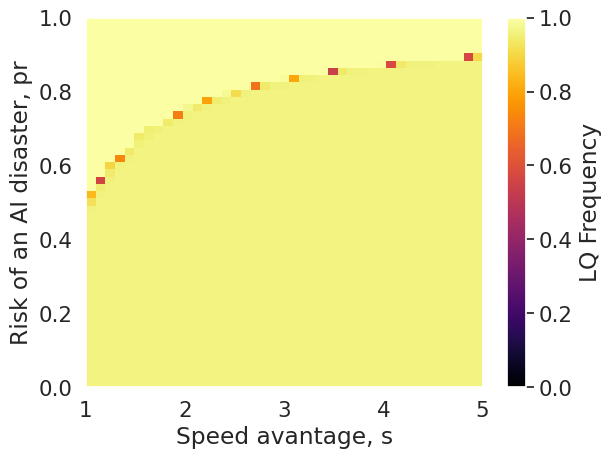

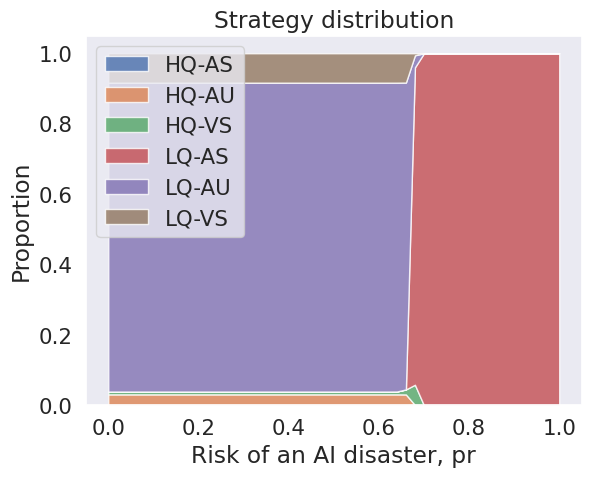

In [ ]:
# | export
Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3],}
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"],}
models = build_reg_market(pfo_h=0.8, g=1.1)
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1a_reward_before",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

results = thread_macro(models,
                      create_profiles,
                      apply_profile_filters,
                      build_payoffs,
                      build_transition_matrix,
                      find_ergodic_distribution,
                      )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
            )

plot_strategy_distribution(df[df.s==1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                          )

What happens when we mix over the two incentives strategies?

The results below suggest that if we mostly use the ex-ante incentive, that the benefits of this incentive are completely overpowered by the ex-post strategy as long as g is not too large.

However, for large enough $g$, some mix can strengthen regulatory markets, though too much mixing towards the ex-post incentive will ruin the regulatory market.
This could be useful to know if we wanted to reduce the overall cost to the government of publicy funding a regulatory market. Unfortunately, this design requires
detailed knowledge of the funding requirements of regulators and their outside options. This information is easier to elicit than accurately predicting the future of technology and its value to AI companies, but it may not be reliable enough to justify mixing a more effective incentive approach with one which threatens to unravel the entire regulatory market.

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


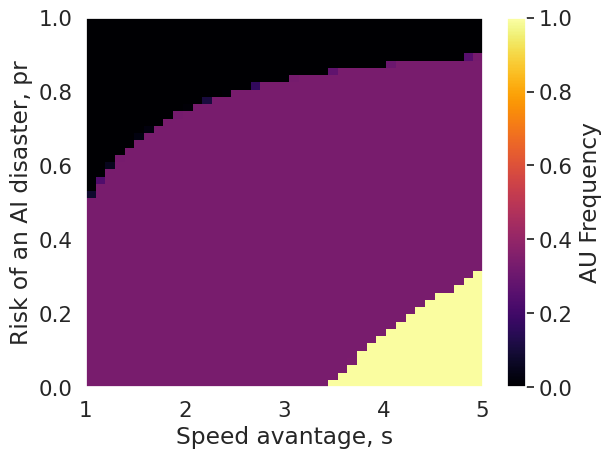

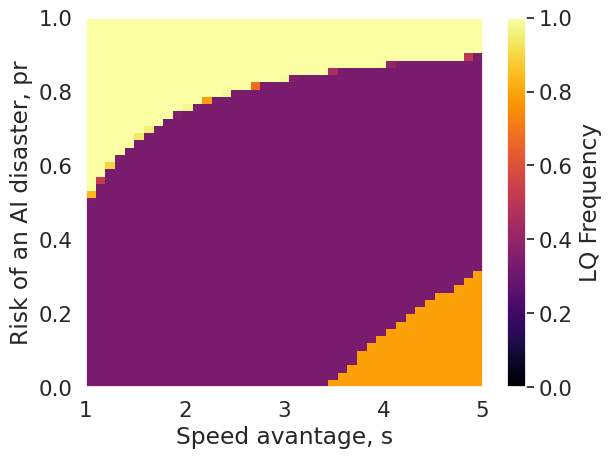

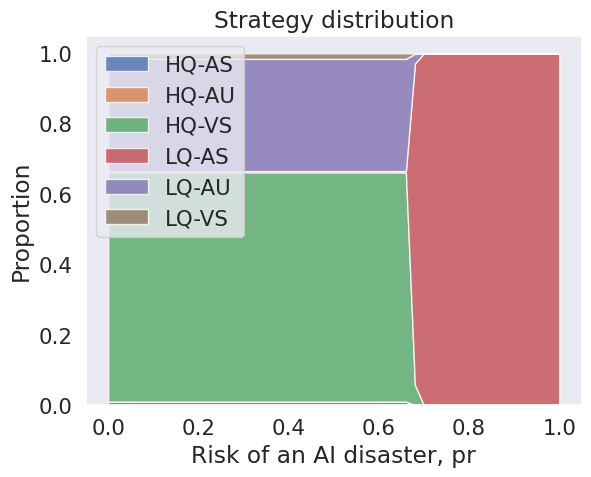

In [ ]:
# | export
Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3],}
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"],}
models = build_reg_market(pfo_h=0.8, g=1.5)
models['incentive_mix'] = 1
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1_reward_mixed",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

results = thread_macro(models,
                      create_profiles,
                      apply_profile_filters,
                      build_payoffs,
                      build_transition_matrix,
                      find_ergodic_distribution,
                      )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
            )

plot_strategy_distribution(df[df.s==1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                          )

I have also considered an alternative model closer to the original DSAIR model.

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: xlabel='Speed avantage, s', ylabel='Risk of an AI disaster, pr'>)

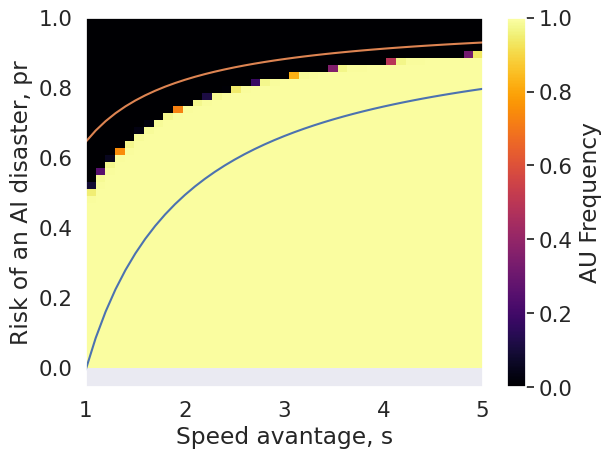

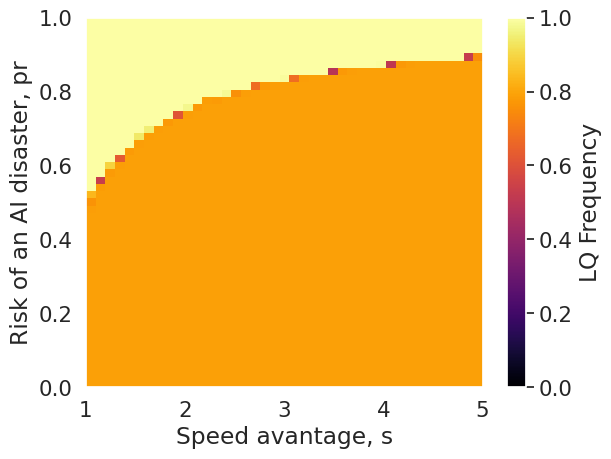

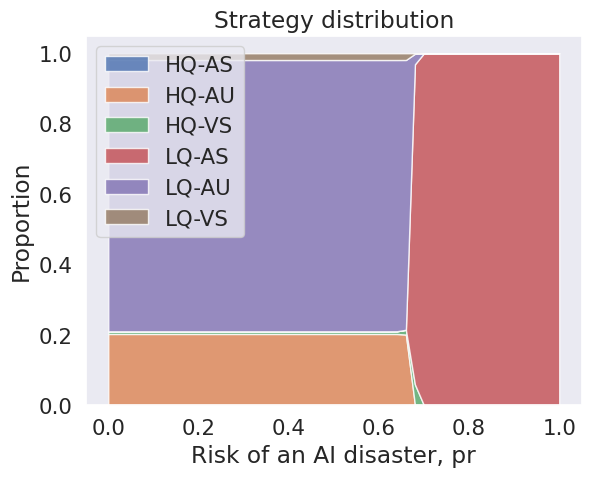

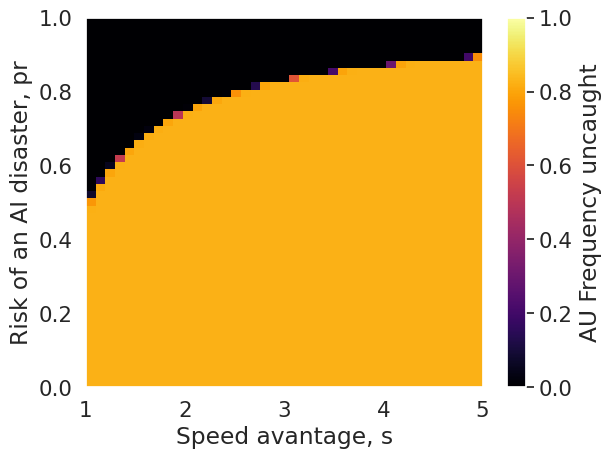

In [ ]:
# | export
Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3], }
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"], }
models = build_reg_market(pfo_h=0.8, g=1.5)
models['incentive_mix'] = 1
models['pfo'] = 0.8
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1a_reward_before",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

results = thread_macro(models,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['AU_frequency_uncaught'] = (df['AU_frequency']
                               * ((1- df['LQ_frequency']) * (1 - df['pfo_h'])
                                  + df['LQ_frequency'] * (1 - df['pfo_l'])))

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
             )

# Add threshold boundaries to convey dilemma region
plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety']);

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
             )

plot_strategy_distribution(df[df.s == 1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                           )

table = df.pivot_table(index='pr', columns='s', values='AU_frequency_uncaught')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency uncaught',
             cmap='inferno',
             )


### Weflare for different sizes of externality

We can also compute the social welfare and deadweight loss.

Assume social welfare is equal to the sum of the AI company payoffs
First, we can show what the deadweight loss is for given parameter values in the same heatmap.
Second, we can assume uniform priors over risk and speed advantage and compute the expected deadweight loss of funding the regulatory market.

Assume social welfare is equal to the sum of the AI company payoffs - an externality associated with the risk, called Damage.
Compute the expected deadweight loss assuming:
    - Uniform priors
    - A heatmap of mean and variance of the risk and speed advantage (3 by 3 grid of heatmaps)

We can have exact analytical solutions if we stick to our simple SPNE game. 

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: xlabel='Speed avantage, s', ylabel='Risk of an AI disaster, pr'>)

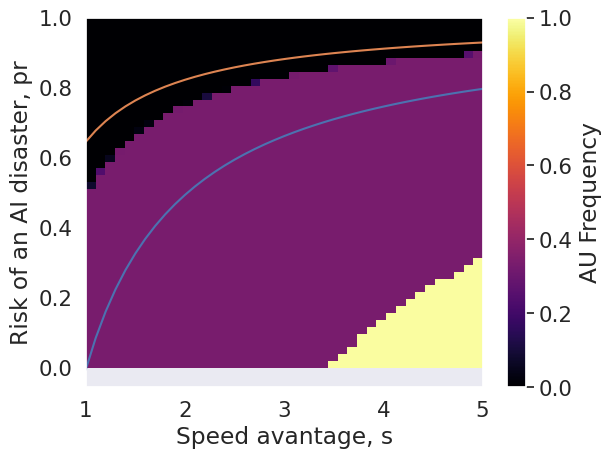

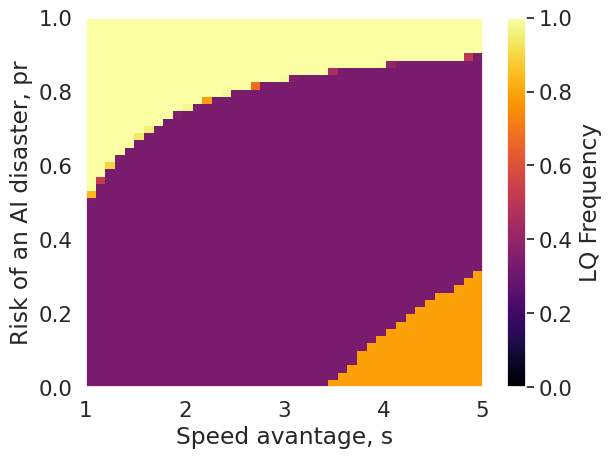

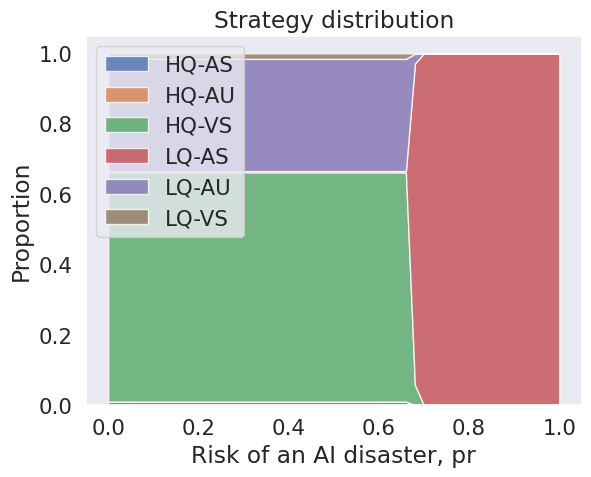

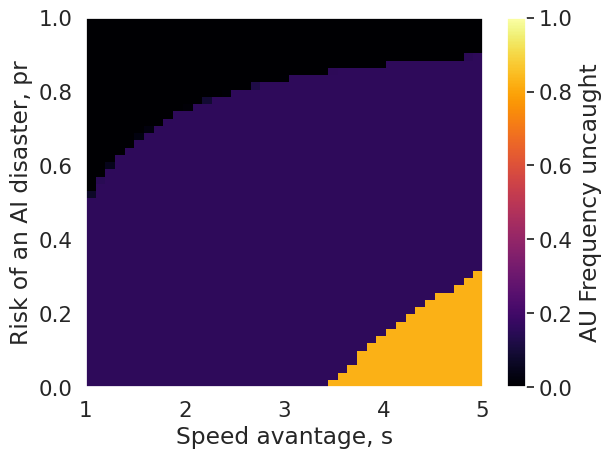

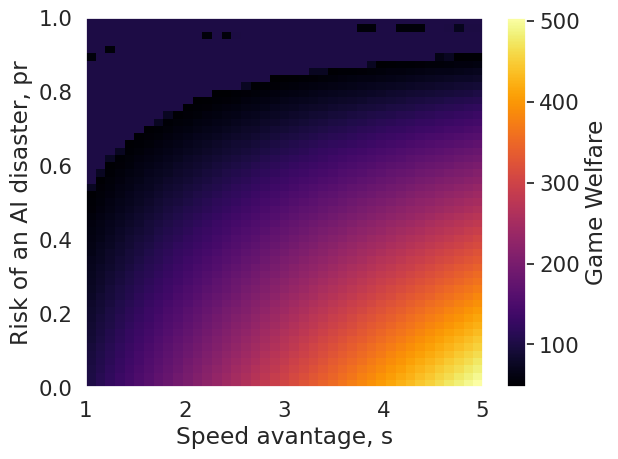

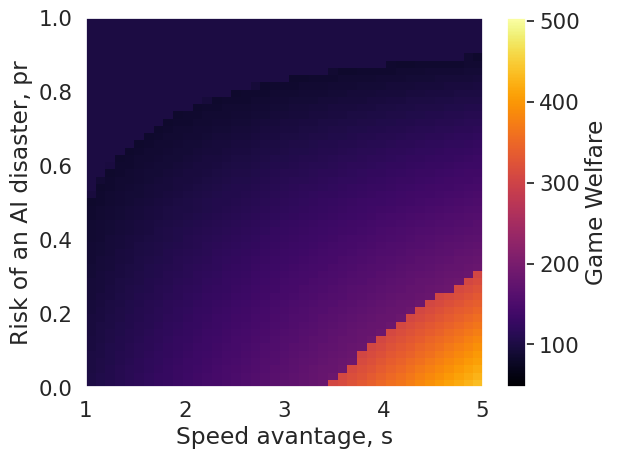

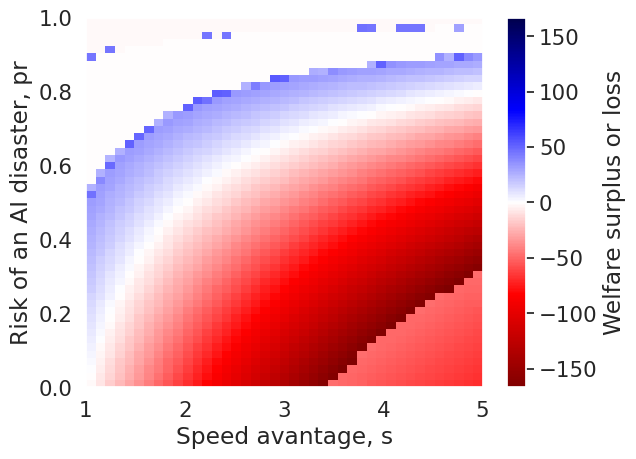

In [ ]:

Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3], }
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"], }
models = build_reg_market(pfo_h=0.8, g=1.5)
models['incentive_mix'] = 1
models['pfo'] = 0.8
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1_reward_before",
          "game_welfare_rule": "regulatory_markets_v1_reward_before",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

models_baseline = copy.deepcopy(models)
models_baseline['pfo_h'] *= 0
models_baseline['g'] *= 0
results_baseline = thread_macro(models_baseline,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare,
                       )

results = thread_macro(models,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare,
                       )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['AU_frequency_uncaught'] = (df['AU_frequency']
                               * ((1- df['LQ_frequency']) * (1 - df['pfo_h'])
                                  + df['LQ_frequency'] * (1 - df['pfo_l'])))

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
             )

# Add threshold boundaries to convey dilemma region
plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety']);

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
             )

plot_strategy_distribution(df[df.s == 1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                           )

table = df.pivot_table(index='pr', columns='s', values='AU_frequency_uncaught')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency uncaught',
             cmap='inferno',
             )

df["game_welfare_baseline"] = results_baseline["game_welfare"]
df["deadweight_loss"] = df.game_welfare - df.game_welfare_baseline

table = df.pivot_table(index='pr', columns='s', values='game_welfare_baseline')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Game Welfare',
             cmap='inferno',
             zmin=df.game_welfare_baseline.min(),
             zmax=df.game_welfare_baseline.max()
             )


table = df.pivot_table(index='pr', columns='s', values='game_welfare')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Game Welfare',
             cmap='inferno',
             zmin=df.game_welfare_baseline.min(),
             zmax=df.game_welfare_baseline.max()
             )


table = df.pivot_table(index='pr', columns='s', values='deadweight_loss')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Welfare surplus or loss',
             cmap='seismic_r',
             zmin=df.deadweight_loss.min(),
             zmax=-df.deadweight_loss.min()
             )


We have seen above that in the absense of exteralities, that a regulatory market is likely to lead to a loss in social welfare. Only a small fraction of this loss is due to spending on regulators by the government, almost all welfare losses come from slowing the development of AI. This is because the size of the benefits of advanced AI systems is $B$, and there is a large region the collective payoffs to unsafe firms will be greater than if they were safe. 

If the externality is fairly small, e.g. avoidig a 10% chance of the disaster
happening would only be worth giving up 0.5% of the benefits of an AI race, then
the effects of a regulatory market on social welfare are somewhat ambiguous

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: xlabel='Speed avantage, s', ylabel='Risk of an AI disaster, pr'>)

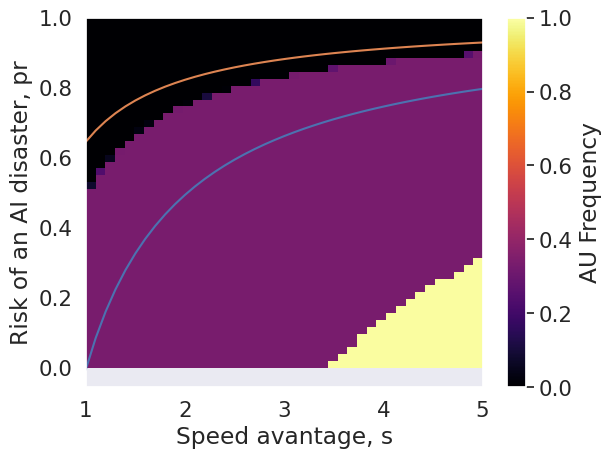

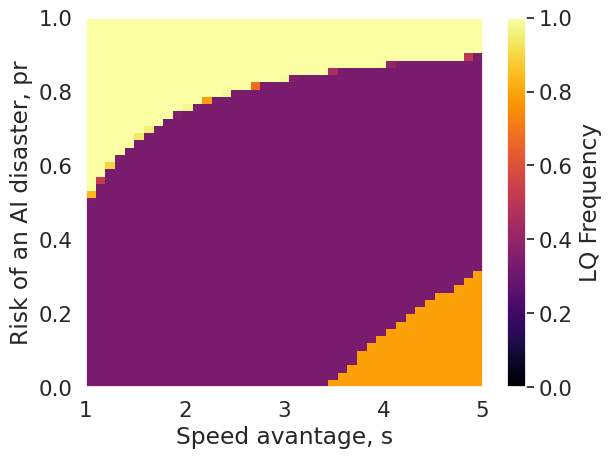

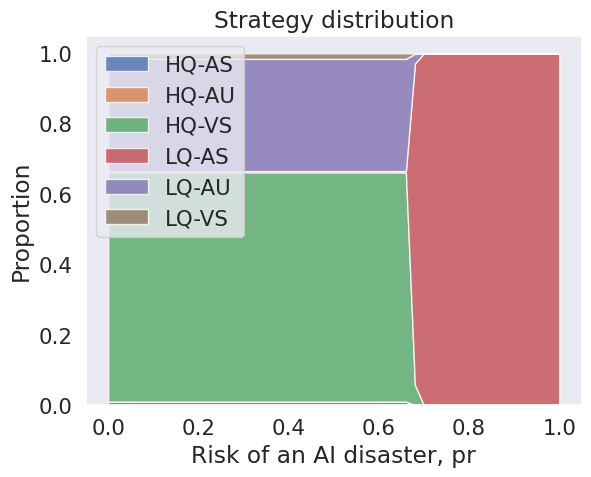

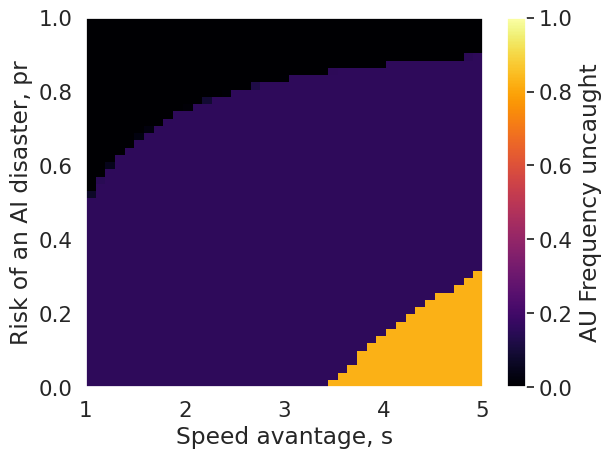

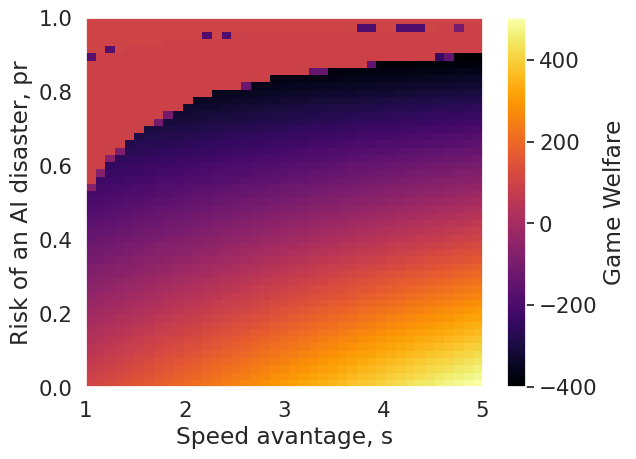

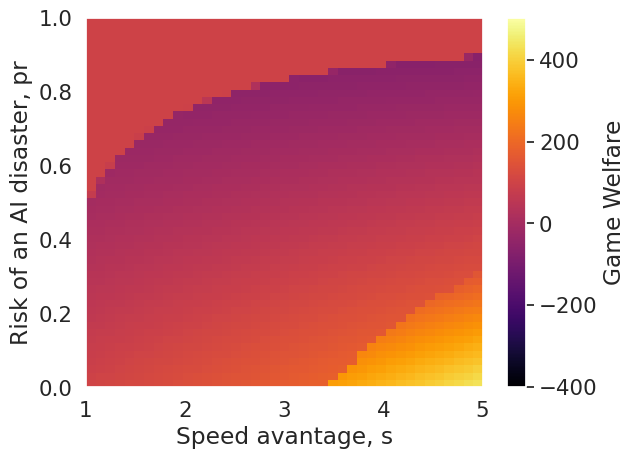

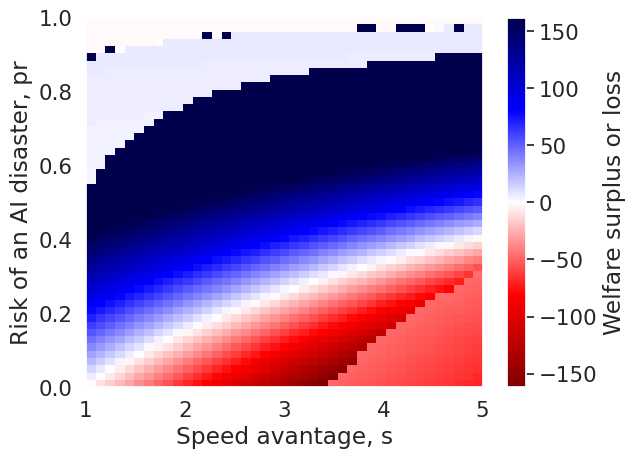

In [ ]:
Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3], }
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"], }
models = build_reg_market(pfo_h=0.8, g=1.5)
models['incentive_mix'] = 1
models['pfo'] = 0.8
models['externality'] = models['B'] / 20
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1_reward_before",
          "game_welfare_rule": "regulatory_markets_v1_reward_before",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

models_baseline = copy.deepcopy(models)
models_baseline['pfo_h'] *= 0
models_baseline['g'] *= 0
results_baseline = thread_macro(models_baseline,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare,
                       )


results = thread_macro(models,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare,
                       )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['AU_frequency_uncaught'] = (df['AU_frequency']
                               * ((1- df['LQ_frequency']) * (1 - df['pfo_h'])
                                  + df['LQ_frequency'] * (1 - df['pfo_l'])))

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
             )

# Add threshold boundaries to convey dilemma region
plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety']);

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
             )

plot_strategy_distribution(df[df.s == 1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                           )

table = df.pivot_table(index='pr', columns='s', values='AU_frequency_uncaught')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency uncaught',
             cmap='inferno',
             )

df["game_welfare_baseline"] = results_baseline["game_welfare"]
df["deadweight_loss"] = df.game_welfare - df.game_welfare_baseline

table = df.pivot_table(index='pr', columns='s', values='game_welfare_baseline')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Game Welfare',
             cmap='inferno',
             zmin=df.game_welfare_baseline.min(),
             zmax=df.game_welfare_baseline.max()
             )


table = df.pivot_table(index='pr', columns='s', values='game_welfare')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Game Welfare',
             cmap='inferno',
             zmin=df.game_welfare_baseline.min(),
             zmax=df.game_welfare_baseline.max()
             )


table = df.pivot_table(index='pr', columns='s', values='deadweight_loss')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Welfare surplus or loss',
             cmap='seismic_r',
             zmin=df.deadweight_loss.min(),
             zmax=-df.deadweight_loss.min()
             )


If the externality of an AI disaster is so large that avoiding a 10% chance
of it happening would be worth giving up 5% of the benefits of an AI race,
then a regulatory market is very likely to generate a large increase in social
welfare.

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: xlabel='Speed avantage, s', ylabel='Risk of an AI disaster, pr'>)

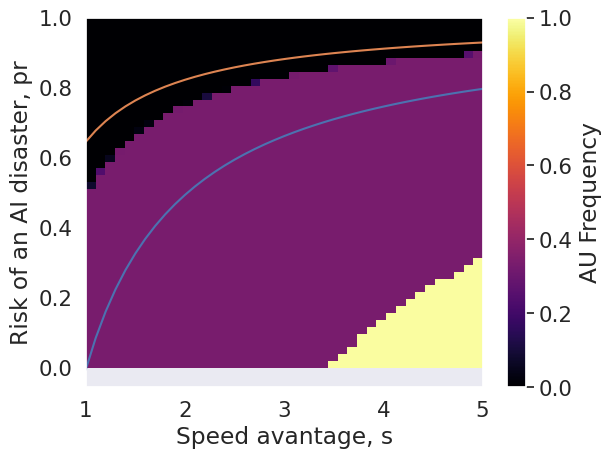

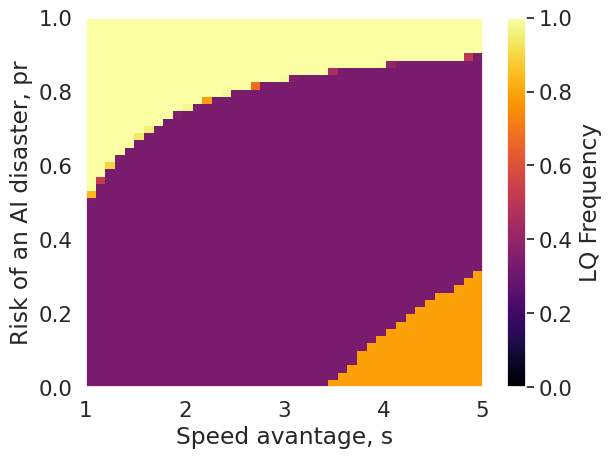

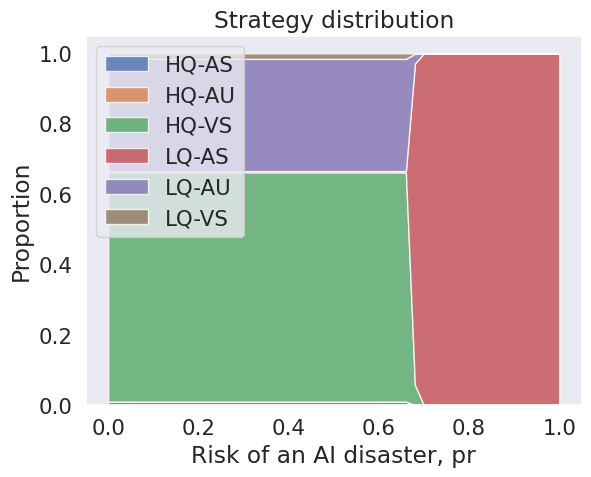

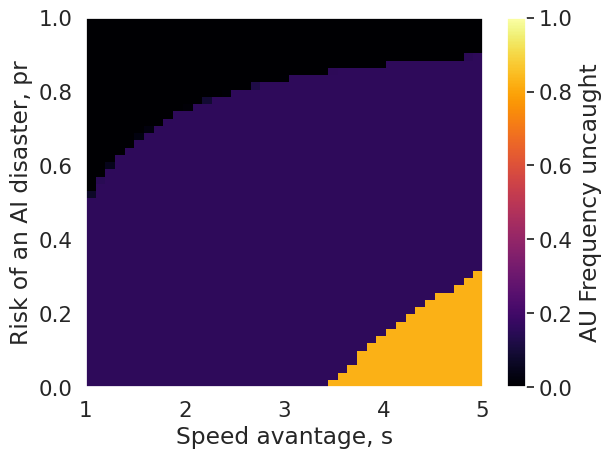

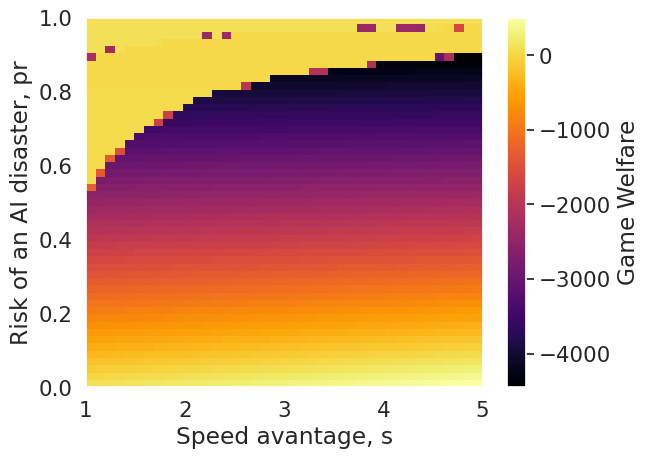

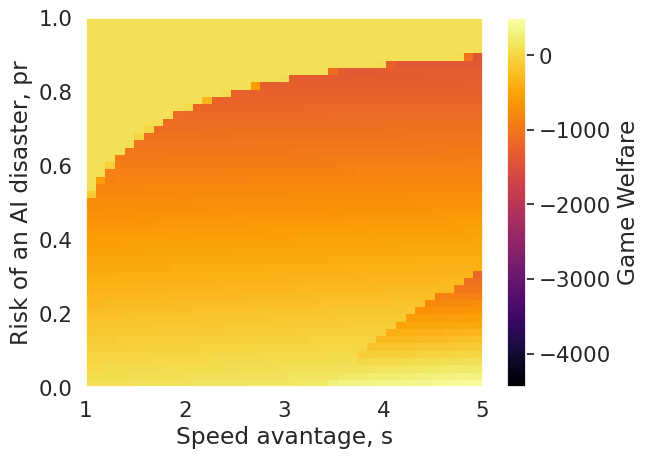

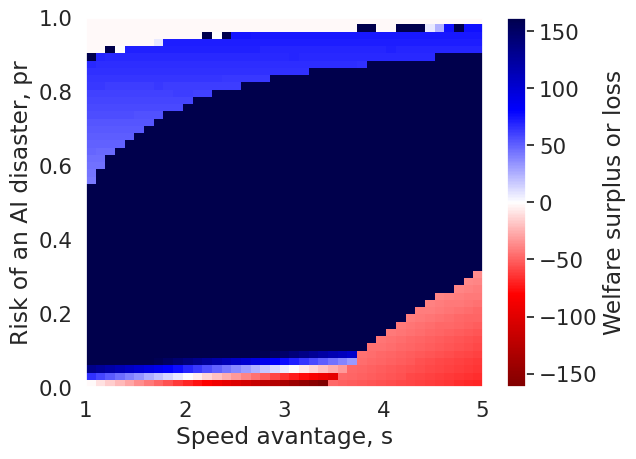

In [ ]:
Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3], }
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"], }
models = build_reg_market(pfo_h=0.8, g=1.5)
models['incentive_mix'] = 1
models['pfo'] = 0.8
models['externality'] = models['B'] / 2
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v1_reward_before",
          "game_welfare_rule": "regulatory_markets_v1_reward_before",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

models_baseline = copy.deepcopy(models)
models_baseline['pfo_h'] *= 0
models_baseline['g'] *= 0
results_baseline = thread_macro(models_baseline,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare,
                       )


results = thread_macro(models,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare,
                       )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['AU_frequency_uncaught'] = (df['AU_frequency']
                               * ((1- df['LQ_frequency']) * (1 - df['pfo_h'])
                                  + df['LQ_frequency'] * (1 - df['pfo_l'])))

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
             )

# Add threshold boundaries to convey dilemma region
plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety']);

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
             )

plot_strategy_distribution(df[df.s == 1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                           )

table = df.pivot_table(index='pr', columns='s', values='AU_frequency_uncaught')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency uncaught',
             cmap='inferno',
             )

df["game_welfare_baseline"] = results_baseline["game_welfare"]
df["deadweight_loss"] = df.game_welfare - df.game_welfare_baseline

table = df.pivot_table(index='pr', columns='s', values='game_welfare_baseline')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Game Welfare',
             cmap='inferno',
             zmin=df.game_welfare_baseline.min(),
             zmax=df.game_welfare_baseline.max()
             )


table = df.pivot_table(index='pr', columns='s', values='game_welfare')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Game Welfare',
             cmap='inferno',
             zmin=df.game_welfare_baseline.min(),
             zmax=df.game_welfare_baseline.max()
             )


table = df.pivot_table(index='pr', columns='s', values='deadweight_loss')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Welfare surplus or loss',
             cmap='seismic_r',
             zmin=df.deadweight_loss.min(),
             zmax=-df.deadweight_loss.min()
             )


### A revised model which permits less strict blacklisting

In this revised model, we accept that it is probably not possible to stop firms
from developing their transformative AI projects completely, just because their
current offerrings fail the regulator's safety checks.

With this in mind, who wins the race will be probabilistic. Similar to the
competition in current AI markets for the small prize, $b$, I implement a 
tullock contest between the safe firm, with speed, $1$, and the unsafe firm,
who faces a speed of $(1 - pfo_h) * s$ (if they are caught in $pfo_h * W$
periods and in those periods their speed grounds to a halt, then this expression
gives their average speed). However, this contest is generalized so that
the speeds are first raised to a power, $k$, before computing the likelihood of
each winning - this captures how decisive the contest is after the regulators
intervene.

I first verified that for large $k$, that the results are the same as with
strict blacklisting when the speed advantage is low enough. Notice that in our
scenario, the detection rate of high quality regulators is high enough to
reduce the average speed below that of safe firms for most values of $s$ that we
consider. A large $k$ will therefore ensure that unsafe firms are almost surely
barred from winning the AI race. You can see in the figure that only for the
highest $s$ we consider will blacklisting fail, meaning that the unsafe firm
wins and intervention fails in these cases to reduce unsafe behaviour.

After this check, I reduced $k$, finding that
overregulation continued to fall, without affecting the dilemma zone.

Encouraged by this discovery, I decreased $k$ below $1$, and observed what
occurred as $k \rightarrow 0$. Overregulation becomes very small. In fact,
for the scenario we analysed above, Always Unsafe becomes viable for almost
the entire region where that strategy is preferred by the collective industry
to playing Always Safe. At $k=0$, this is the equivalent of saying that once
caught, the regulator only does what it needs to do to ensure that the safe
and the attempted unsafe firm are on a level playing field. This is a promising
result since achieving a level playing field is a convenient heuristic to ask
regulators to follow. 

I also looked at small negative values of $k$, which effectively assume that
the unsafe companies speed in this case will be somewhat greater than the 
unsafe firms. Overregulation does fall slightly further, but when negative
enough, unsafe behaviour begins to rise in the dilemma zone.

While the Tullock contest formulation above is fairly intuitive, it may not
be a very direct way of communicating how a regulator might influence the
speed of the two companies. If a regulator does what they can to persistently
make the company safe, which they will do if they observe enough safety
violations, then that would be the same as perfoming a similar tullock contest,
but reducing their speed back to 1. We could convey the success with which they
achieve this by some scaling parameter to indicate whether their regulation
effectively levels the playing field or whether one company is at a
disadvantage.

Why is overregulation reduced so much when the playing field is level? The
answer lies in the original payoff matrix of the model. Where both to be safe
or unsafe,they would each have an equal shot of winning the race. So, as long
as detection risk is high enough, leveling the playing field is a great way
to reduce the incentives to act unsafely if both are currently safe, whilst
ensuring that if both preferred to be unsafe originally, that we don't
encourage anyone to become overly cautious. A similar logic is likely to hold
if the companies had different levels of capability, and I suspect that a
heuristic of enforcing that companies stick to the safe speed will result in
similar outcomes (of course the difference in capabilities would remain).

While these results present a promising compromise between those who see promise
in promoting AI regulation, and those who fear the burden of overregulation,
it is important that we identify an important challenge to these findings.

The proposed heuristic strongly encourages regulators and companies to be on
excellent terms, so much so that causing a safety violation is met with only
a slap on the wrist, a watchful eye, and guidance back to the safe path of
AI development. These conditions are perfect for the emergence of collusion
and corruption, which outside of the dynamics discussed in the current model are
the biggest obstacles that regulatory markets (indeed, any regulatory regimes)
face in achieving their goals.

Note: If both firms are unsafe, then the regulator reserves the right to
blacklist both of them (this might be an reasonable assumption, so I'll weaken
this later on).

/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/model_utils.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/mnt/d/Paolo-Work/git/gh-pages-example/gh_pages_example/methods.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: xlabel='Speed avantage, s', ylabel='Risk of an AI disaster, pr'>)

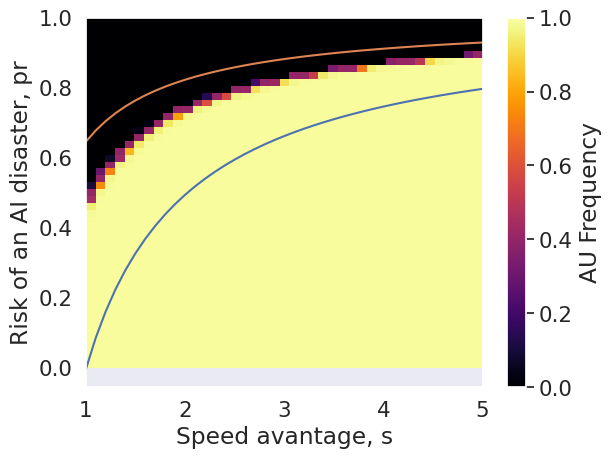

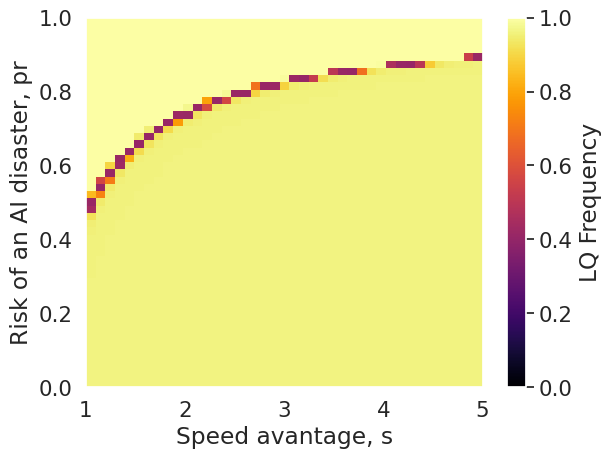

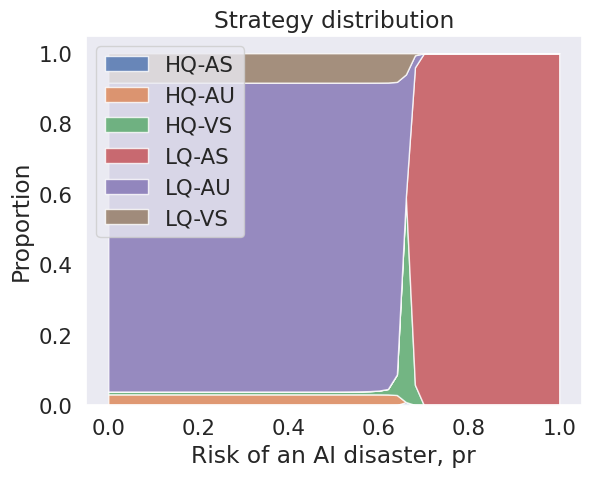

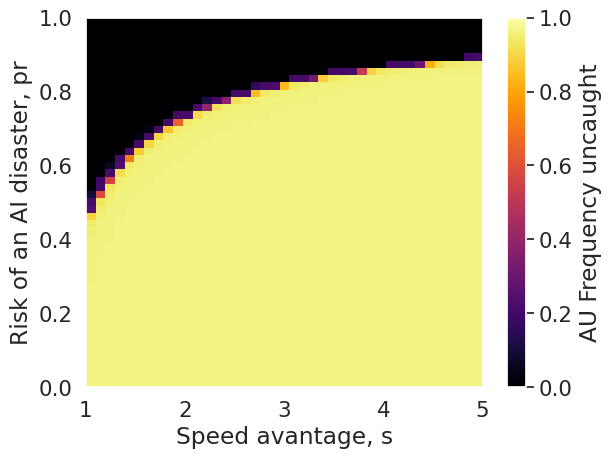

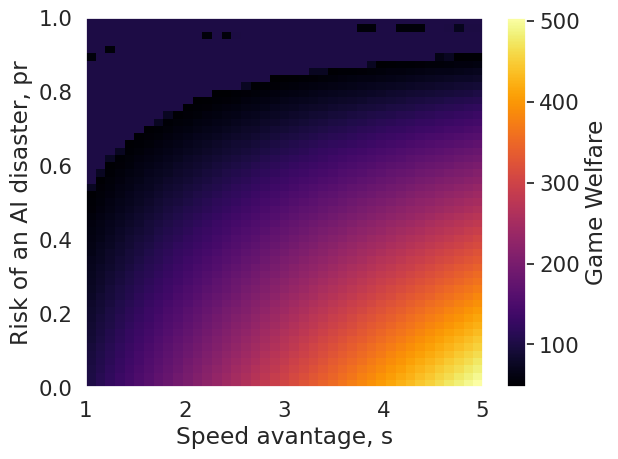

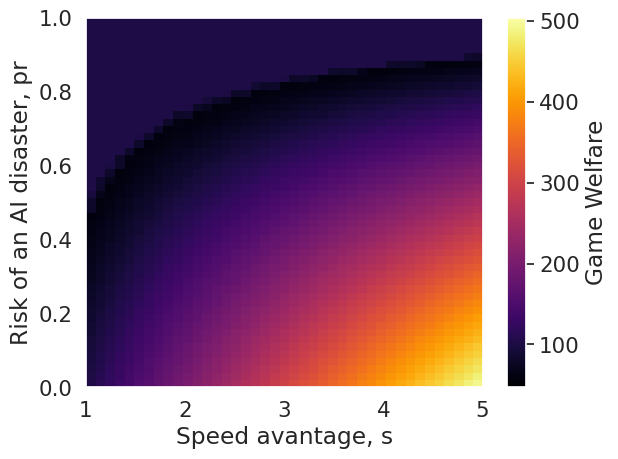

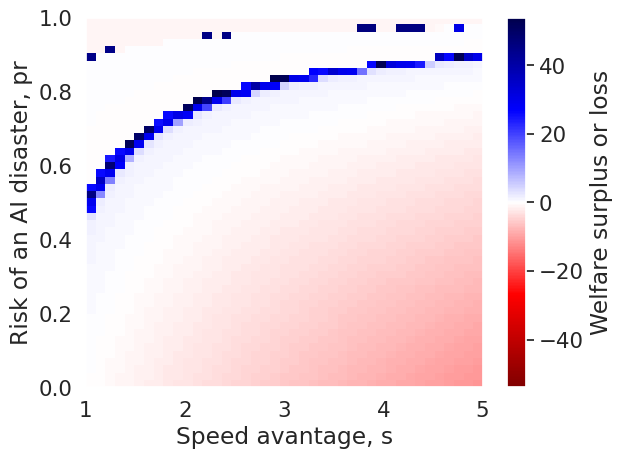

In [ ]:

Z = {"S2": 100, "S1": 100}
β = 1
sector_strategies = {"S2": [4, 5],
                     "S1": [1, 2, 3], }
allowed_sectors = {"P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"], }
models = build_reg_market(pfo_h=0.8, g=1.1)
models['incentive_mix'] = 1
models['pfo'] = 0.8
models['decisiveness'] = 0
# models['externality'] = models['B'] / 20
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "regulatory_markets_v2_reward_mixed",
          "game_welfare_rule": "regulatory_markets_v1_reward_mixed",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

models_baseline = copy.deepcopy(models)
models_baseline['pfo_h'] *= 0
models_baseline['g'] *= 0
results_baseline = thread_macro(models_baseline,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare,
                       )

results = thread_macro(models,
                       payoffs_sr_pfo_extension,
                       threshold_risk_dominant_safety_dsair,
                       threshold_society_prefers_safety_dsair,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_game_welfare,
                       )
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

df = thread_macro(results,
                  results_to_dataframe_egt,
                  process_dsair_data)
df['AU_frequency'] = (df['HQ-AU_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['LQ_frequency'] = (df['LQ-AS_frequency']
                      + df['LQ-AU_frequency']
                      + df['LQ-VS_frequency'])
df['AU_frequency_uncaught'] = (df['AU_frequency']
                               * ((1- df['LQ_frequency']) * (1 - df['pfo_h'])
                                  + df['LQ_frequency'] * (1 - df['pfo_l'])))

table = df.pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
             )

# Add threshold boundaries to convey dilemma region
plt.plot(table.columns, df[df.pr==1]['threshold_society_prefers_safety'])
plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety']);

table = df.pivot_table(index='pr', columns='s', values='LQ_frequency')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='LQ Frequency',
             cmap='inferno',
             )

plot_strategy_distribution(df[df.s == 1.5],
                           results['strategy_set'],
                           x="pr",
                           thresholds=None,
                           )

table = df.pivot_table(index='pr', columns='s', values='AU_frequency_uncaught')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency uncaught',
             cmap='inferno',
             )

df["game_welfare_baseline"] = results_baseline["game_welfare"]
df["deadweight_loss"] = df.game_welfare - df.game_welfare_baseline

table = df.pivot_table(index='pr', columns='s', values='game_welfare_baseline')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Game Welfare',
             cmap='inferno',
             zmin=df.game_welfare_baseline.min(),
             zmax=df.game_welfare_baseline.max()
             )


table = df.pivot_table(index='pr', columns='s', values='game_welfare')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Game Welfare',
             cmap='inferno',
             zmin=df.game_welfare_baseline.min(),
             zmax=df.game_welfare_baseline.max()
             )

table = df.pivot_table(index='pr', columns='s', values='deadweight_loss')
plot_heatmap(table,
             xlabel='Speed advantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='Welfare surplus or loss',
             cmap='seismic_r',
             zmin=None,
             zmax=None,
             norm=mpl.colors.CenteredNorm()
             )


## Outlines

Let's return to discussing the space of possible incentives.

We want to answer several questions
- Who gives the incentive?
- Who receives the incentive?
- What incentive do they receive and why?
- What information can we base the size and nature of the incentive on?
- When do we give the incentive?
- How do we target the incentive in terms of size, duration, and recipients?
- participation and incentive compatability constraints
- Another useful consideration is whether the incentives act as a signal about hidden or partially observable information received by the players

Clearly the number of possibilities is extremely large. Fortunately, the current scenario allows us to naturally restrict ourselve to a few scenarios.
- It is an institutional incentive given by a government or some department who the responsibility has been delegated to. We only consider a national scenario and do not consider the possibilty of multiple competing international actors.
- Regulators receive the incentive. However, which regulators receive the incentive and how much they receive is open for debate.
- Incentives are monetary in nature and represent a single-dimensional reward. This is a simplification but on its own it doesn't restrict us too much.
- We consider that institutions (and for the most part, regulators) act under uncertainty. The information available to the institution when giving the incentive need not be complete, though we will want the model to specify any consequences the insitution follows through with upon learning more information. 
- The information available in the model includes:
  - Number of regulators
  - Number of unsafe firms (after regulation has occured, possibly only partially observed)
  - The size and extent of a disaster (probably probabilistic) if one occurs
- The information we might expect to be available in this context of a market for AI regulation includes:
  - Open letters about differential AI developments
  - A database of AI incidents
  - Worker activism over an issue that requires scrutiny
  - Safety benchmark data (this idea and the others above are all signals of disaster risk or damages, though they may occur at different times in a technology's lifecycle)
  - Claims about the activities of one's peers (ignore this one since it can be captured as a private assessment strategy of the actors instead)
  - User reports or testimonials regarding the benefits or dangers of a product (could potentially excuse technologies where risk is worth the benefits; could be a good extension, especially if we can clarify when overconfidence or fake benefits are likely)
  - internal audits about the activities that a company or regulator engages in (leads to plausible chance of discovering unsafe companies and complacent regulators)
- Issues:
  - legal processes can take a long time
  - companies may have spent the incentive already, so claims may invoke bankruptcy, and bankruptcy is politically more difficult if there are few regulators to take their place (e.g. financial sector and credit rating crises)
  - how feasible is it to achieve a high detection rate (in the absense of collusion)? We should test this in practise.
- Assessment of model coverage:
  - We appear to capture a range of useful indicators in a fairly simple model. What information is used to target incentives is fairly well addressed by my model.
  - How that information is used to design incentives gives us many options for a given interaction: 
    - At least 3 relevant terms (disaster penalty, complacent penalty, ideal government payment) for regulators
    - Insitutional punishments or rewards for unsafe companies (out of the scope of this paper)
    - Pooled funding for incentives (out of the scope of this paper)
    - Dynamic shifting of regulator cost burden to safe AI companies when most companies are safe
  - We may want to consider that governments could shape the interaction between regulators and companies further:
    - extent of regulator competition
    - the number of companies to regulate
    - the plausibility of conditional strategies
    - the timing of regulator activities via randomly incentivised audits (which may force companies to precommit to actions)
    - knowledge sharing between regulators
  - We may want to consider that regulators may be forced out of the market and that replacement requires setup or switching incentives from the government
  - We may want to consider the challenges to combining multiple signals in practise and whether to target only a portion of the activities of a regulator
  - We may want to consider when to respond to information - at a consistent time or as soon as that information becomes available to the government
  - If that information is mainly provided by the regulatory market, then consider the possibility that regulators ommit or ammend data to appear better. This is of course collusion and appears less likely in more competitive regulatory markets.

Important issue: Corruption

Regulators may choose to fake data:
    - They may create fake data to claim that firms are unsafe
    - They may create fake data to make unsafe firms (that they may be friendly with) appear safe

Corruption which involves making unsafe firms appear safe is likely to be more problematic when a regulator has higher market concentration.

Different types of corruption occur depending on the incentives the government may give:
    - Bounty-hunting encourages even small regulators to fake unsafe data
    - Ex-ante rewards encourage making unsafe firms appear safe

Some efforts to address corruption include:
    - Setting external targets for what it means to be unsafe and external audits to prevent data forgery
    - External audits of AI companies to check for complacency
    - Healthy regulatory market competition so that companies can choose regulators who will be fair
    - A plausible reputation system for regulators

Need an imperfect competition model to determine the quality of regulation, the price it commands on the market, and the market concentration.

We need to consider good examples of applying regulatory markets to AI
  - LAWS (outside the scope of a regulatory market and requires international nonproliferation agreements and conventions against their use)
  - High risk domain-specific AI applications (anti-toxin and toxin discovery - this example might lean to heavily to weapons development so may lie outside the scope of a regulatory market)
  - General purose AI systems (with potentially transformative effects, e.g. large language models, social media algorithms, automated economic planning)
  - A possible implementation of regulatory markets via a regulatory sandbox

Most interesting possible visuals for regulatory markets:
- Regulatory market concentration as we vary incentives
- Success of regulatory markets (total risk, total spent) as we vary regulatory market concentration
- Gradient of selection for regulators and companies as we vary incentives or market concentration

Varying incentives is somewhat straightforward as we have two interesting incentive regimes which we could smoothly mix between.
Varying market concentration is harder since we may not have an interesting way to capture market concentration yet. My current
approaches are very simple and so explicitly label it as harmful which misses the nuances of debate surrounding economies of
scale, natural monopolies, preemptive buyout motives, and innovative effort. I should wait for a future (perhaps published) paper
to discuss the nuances of market concentration in detail. 

I could extend frame low quality and high quality regulators in a different way. Perhaps it is useful to say that regulators are
driven mainly by a profit/survial motive, but their mission is to provide efficient regulation. Regulation is only efficient if it
requires less of lower risk applications or require less of companies which are assessed to be safe (but of course, this type of
private or public assessment may be notorious for causing issues e.g the credit crunch of 2008). With this framing, low quality
regulation is not necessarily bad if it more efficient.

Interesting idea:

Have a set of actors (possible external) who allocate effort to influence
the set of future beliefs (or strategy types) considered by actors in the next
state/time-period. Greater prevelance of some beliefs may be more likely, which
shapes how likely players are to avoid conflict. Moreover, there can be path
dependency in terms of the set of future beliefs (or strategy types) that are
combinations of or responses to existing beliefs.

This would be a very cool extension to the SERI paper and we should aim to use
the theory of non-stationary stochastic games for this.

An interesting opinion:

We can use modeling to generate strategies which are robustly safe and if appropriately designed meet a set of criteria which are desirable for powerful actors.

#| hide

# References

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()